In [2]:
%pylab inline
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
from IPython.display import clear_output
import time
#from time import sleep
import numpy as np
import pandas as pd
from sklearn import linear_model
import math
import gym
import myfrozen
import pickle

Populating the interactive namespace from numpy and matplotlib


In [2]:
import img_utils

In [3]:
pkl_file = open('saved/collected.pkl', 'rb')
full = pickle.load(pkl_file)
pkl_file2 = open('saved/collected2.pkl', 'rb')
full2 = pickle.load(pkl_file2)

/anaconda/envs/drl/lib/python2.7/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LinearRegression from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [4]:
def get_data(dictionary):
    models = []
    i = 0
    for k, v in dictionary.items():
        for kp, vp in v.items():
            if kp == 'model':
                models.append(vp)
    models = np.array([models[i].coef_ for i in xrange(len(models)) if len(models[i].coef_)==125])
    return models

def mix_data():
    x = get_data(full)
    y = get_data(full2)
    z = np.concatenate((x, y))
    return z

In [5]:
models = mix_data()

In [7]:
models.shape

(182, 125)

(array([124.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.00122158,  0.0988752 ,  0.19897198,  0.29906876,  0.39916554,
         0.49926232,  0.5993591 ,  0.69945588,  0.79955265,  0.89964943,
         0.99974621]),
 <a list of 10 Patch objects>)

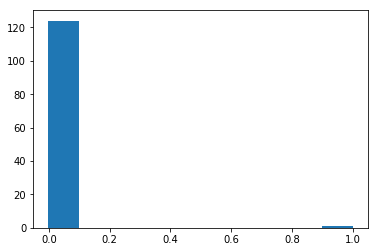

In [6]:
a = models[20]
plt.hist(a) 

In [7]:
zs = {12, 21, 29, 37, 44, 52, 58}

In [8]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

Using TensorFlow backend.


In [9]:
class GAN():
    def __init__(self):
        self.img_rows = 125
        self.img_cols = 1
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 8

        optimizer = Adam(0.0001, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='sigmoid'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)
    
    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(Dense(256))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)
    
    def train(self, epochs, batch_size=128, sample_interval=50):
        
        D = {}
        X_train = mix_data()
        X_train = np.expand_dims(X_train, axis=3)
        X_train = np.expand_dims(X_train, axis=4)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator 
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                D = self.sample_images(epoch,D)
        return D
    
    def sample_images(self, epoch,D):
        
        OBSERVATION_SPACE = 64
        ACTION_SPACE = 4
        
        def to_onehot(size,value):
          my_onehot = np.zeros((size))
          my_onehot[value] = 1.0
          return my_onehot
    
        def heatmap2d(hm_mat, title='', fig_num=1, text=True):
            plt.figure(fig_num)
            plt.imshow(hm_mat, interpolation='nearest')
            plt.title(title)
            plt.colorbar()
            
            if text:
                for y in range(hm_mat.shape[0]):
                  for x in range(hm_mat.shape[1]):
                    plt.text(x, y, '%.1f' % hm_mat[y, x],
                     horizontalalignment='center',
                     verticalalignment='center',
                     )
                    
            plt.savefig("rewardsamples/%d.png" % fig_num, format='png')
            
        def compute_reward(s,new_s,a,gen_imgs):
            zerostates = {12, 21, 29, 37, 44, 52, 58}
            s = to_onehot(OBSERVATION_SPACE,s)
            new_s = to_onehot(OBSERVATION_SPACE,new_s)
            a = to_onehot(ACTION_SPACE,a)
            vectorized = np.hstack((s,new_s,a))
            index = list(zerostates)
            vectorized = np.delete(vectorized, index)
            return np.dot(gen_imgs,vectorized)

        def fill_rewards(gen_imgs):
            tofill = np.zeros((OBSERVATION_SPACE,OBSERVATION_SPACE,ACTION_SPACE)) 
            for s in xrange(0,OBSERVATION_SPACE):
                for new_s in xrange(0,OBSERVATION_SPACE):
                    for a in xrange(0,ACTION_SPACE):
                        tofill[(s,new_s,a)] = compute_reward(s,new_s,a,gen_imgs)
            sub = tofill[0, :, :]
            sub = np.max(sub,axis=1)
            return sub
        
        r, c = 1, 1
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        gen_imgs = np.squeeze(gen_imgs, axis=0)
        gen_imgs = np.squeeze(gen_imgs, axis=2)
        gen_imgs = np.squeeze(gen_imgs, axis=1)
        
        hm_mat = fill_rewards(gen_imgs)
        hm_mat = np.expand_dims(hm_mat,axis=1)
        
        heatmap2d(np.reshape(hm_mat, (8, 8)), title='', fig_num=epoch, text=True)
        
        D[str(epoch)] = {}
        D[str(epoch)]["rewards"] = hm_mat
        D[str(epoch)]["coeff"] = gen_imgs
        return D

In [10]:
gan = GAN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 125)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 126       
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               2304      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Den

/anaconda/envs/drl/lib/python2.7/site-packages/ipykernel/__main__.py:79: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/anaconda/envs/drl/lib/python2.7/site-packages/ipykernel/__main__.py:80: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/anaconda/envs/drl/lib/python2.7/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.660489, acc.: 83.33%] [G loss: 0.790331]
1 [D loss: 0.657521, acc.: 70.00%] [G loss: 0.781768]
2 [D loss: 0.667944, acc.: 66.67%] [G loss: 0.777516]
3 [D loss: 0.694325, acc.: 56.67%] [G loss: 0.775545]
4 [D loss: 0.658016, acc.: 71.67%] [G loss: 0.766536]
5 [D loss: 0.664948, acc.: 68.33%] [G loss: 0.760977]
6 [D loss: 0.677613, acc.: 63.33%] [G loss: 0.768221]
7 [D loss: 0.690841, acc.: 58.33%] [G loss: 0.763343]
8 [D loss: 0.681892, acc.: 56.67%] [G loss: 0.740454]
9 [D loss: 0.666305, acc.: 65.00%] [G loss: 0.743682]
10 [D loss: 0.660570, acc.: 66.67%] [G loss: 0.734067]
11 [D loss: 0.687220, acc.: 50.00%] [G loss: 0.734308]
12 [D loss: 0.669549, acc.: 66.67%] [G loss: 0.729993]
13 [D loss: 0.682509, acc.: 63.33%] [G loss: 0.731272]
14 [D loss: 0.693355, acc.: 51.67%] [G loss: 0.732271]
15 [D loss: 0.696983, acc.: 56.67%] [G loss: 0.730416]
16 [D loss: 0.678602, acc.: 63.33%] [G loss: 0.732755]
17 [D loss: 0.711622, acc.: 51.67%] [G loss: 0.715832]
18 [D loss: 0.708438

152 [D loss: 0.719275, acc.: 48.33%] [G loss: 0.779958]
153 [D loss: 0.705184, acc.: 50.00%] [G loss: 0.762546]
154 [D loss: 0.736315, acc.: 45.00%] [G loss: 0.780851]
155 [D loss: 0.755293, acc.: 48.33%] [G loss: 0.659303]
156 [D loss: 0.725222, acc.: 41.67%] [G loss: 0.715010]
157 [D loss: 0.738520, acc.: 40.00%] [G loss: 0.770505]
158 [D loss: 0.726006, acc.: 45.00%] [G loss: 0.756765]
159 [D loss: 0.726003, acc.: 46.67%] [G loss: 0.760249]
160 [D loss: 0.708281, acc.: 50.00%] [G loss: 0.718230]
161 [D loss: 0.719499, acc.: 45.00%] [G loss: 0.788031]
162 [D loss: 0.728304, acc.: 40.00%] [G loss: 0.799779]
163 [D loss: 0.704935, acc.: 50.00%] [G loss: 0.777035]
164 [D loss: 0.720988, acc.: 41.67%] [G loss: 0.806086]
165 [D loss: 0.739014, acc.: 41.67%] [G loss: 0.748037]
166 [D loss: 0.713183, acc.: 50.00%] [G loss: 0.681732]
167 [D loss: 0.696558, acc.: 48.33%] [G loss: 0.687074]
168 [D loss: 0.760065, acc.: 35.00%] [G loss: 0.815831]
169 [D loss: 0.683864, acc.: 58.33%] [G loss: 0.

301 [D loss: 0.719983, acc.: 41.67%] [G loss: 0.823692]
302 [D loss: 0.671298, acc.: 60.00%] [G loss: 0.846495]
303 [D loss: 0.680965, acc.: 50.00%] [G loss: 0.792393]
304 [D loss: 0.728266, acc.: 48.33%] [G loss: 0.868408]
305 [D loss: 0.713689, acc.: 51.67%] [G loss: 0.797621]
306 [D loss: 0.736714, acc.: 38.33%] [G loss: 0.855078]
307 [D loss: 0.709014, acc.: 46.67%] [G loss: 0.835192]
308 [D loss: 0.739560, acc.: 41.67%] [G loss: 0.791591]
309 [D loss: 0.705706, acc.: 50.00%] [G loss: 0.810339]
310 [D loss: 0.695175, acc.: 58.33%] [G loss: 0.843025]
311 [D loss: 0.711315, acc.: 48.33%] [G loss: 0.863306]
312 [D loss: 0.723737, acc.: 46.67%] [G loss: 0.808062]
313 [D loss: 0.720582, acc.: 46.67%] [G loss: 0.805271]
314 [D loss: 0.700852, acc.: 50.00%] [G loss: 0.718583]
315 [D loss: 0.738884, acc.: 45.00%] [G loss: 0.939803]
316 [D loss: 0.688399, acc.: 53.33%] [G loss: 0.962080]
317 [D loss: 0.728044, acc.: 46.67%] [G loss: 0.968556]
318 [D loss: 0.660776, acc.: 63.33%] [G loss: 0.

449 [D loss: 0.717621, acc.: 45.00%] [G loss: 0.915213]
450 [D loss: 0.661489, acc.: 53.33%] [G loss: 1.208452]
451 [D loss: 0.634362, acc.: 50.00%] [G loss: 1.001595]
452 [D loss: 0.609549, acc.: 60.00%] [G loss: 0.966715]
453 [D loss: 0.725621, acc.: 43.33%] [G loss: 1.036017]
454 [D loss: 0.748093, acc.: 40.00%] [G loss: 0.790520]
455 [D loss: 0.710835, acc.: 51.67%] [G loss: 0.955101]
456 [D loss: 0.753824, acc.: 50.00%] [G loss: 0.913659]
457 [D loss: 0.663453, acc.: 60.00%] [G loss: 0.839164]
458 [D loss: 0.747686, acc.: 50.00%] [G loss: 0.899047]
459 [D loss: 0.692467, acc.: 55.00%] [G loss: 1.073132]
460 [D loss: 0.664494, acc.: 48.33%] [G loss: 0.905366]
461 [D loss: 0.696128, acc.: 48.33%] [G loss: 0.898404]
462 [D loss: 0.683704, acc.: 55.00%] [G loss: 0.904013]
463 [D loss: 0.630514, acc.: 63.33%] [G loss: 0.893089]
464 [D loss: 0.687619, acc.: 51.67%] [G loss: 1.053314]
465 [D loss: 0.740492, acc.: 50.00%] [G loss: 0.880386]
466 [D loss: 0.706013, acc.: 50.00%] [G loss: 0.

599 [D loss: 0.659018, acc.: 53.33%] [G loss: 0.834338]
600 [D loss: 0.795993, acc.: 33.33%] [G loss: 0.879013]
601 [D loss: 0.817989, acc.: 36.67%] [G loss: 0.819714]
602 [D loss: 0.767585, acc.: 40.00%] [G loss: 0.791291]
603 [D loss: 0.711780, acc.: 40.00%] [G loss: 0.864594]
604 [D loss: 0.737699, acc.: 38.33%] [G loss: 0.801908]
605 [D loss: 0.765806, acc.: 43.33%] [G loss: 0.848318]
606 [D loss: 0.726299, acc.: 46.67%] [G loss: 1.002123]
607 [D loss: 0.739005, acc.: 35.00%] [G loss: 0.974907]
608 [D loss: 0.761402, acc.: 33.33%] [G loss: 0.811235]
609 [D loss: 0.730672, acc.: 36.67%] [G loss: 0.769909]
610 [D loss: 0.745700, acc.: 41.67%] [G loss: 0.916955]
611 [D loss: 0.780185, acc.: 36.67%] [G loss: 0.759387]
612 [D loss: 0.789868, acc.: 40.00%] [G loss: 0.894514]
613 [D loss: 0.756180, acc.: 50.00%] [G loss: 0.858508]
614 [D loss: 0.760333, acc.: 36.67%] [G loss: 0.880992]
615 [D loss: 0.774823, acc.: 36.67%] [G loss: 0.968973]
616 [D loss: 0.672786, acc.: 48.33%] [G loss: 0.

746 [D loss: 0.712591, acc.: 31.67%] [G loss: 0.816513]
747 [D loss: 0.739998, acc.: 30.00%] [G loss: 0.735067]
748 [D loss: 0.708726, acc.: 30.00%] [G loss: 0.801898]
749 [D loss: 0.751223, acc.: 28.33%] [G loss: 0.774365]
750 [D loss: 0.752812, acc.: 20.00%] [G loss: 0.785698]
751 [D loss: 0.708274, acc.: 43.33%] [G loss: 0.791681]
752 [D loss: 0.707753, acc.: 38.33%] [G loss: 0.747671]
753 [D loss: 0.704672, acc.: 35.00%] [G loss: 0.803097]
754 [D loss: 0.706372, acc.: 40.00%] [G loss: 0.755107]
755 [D loss: 0.725156, acc.: 26.67%] [G loss: 0.784414]
756 [D loss: 0.711100, acc.: 35.00%] [G loss: 0.696804]
757 [D loss: 0.695452, acc.: 31.67%] [G loss: 0.761391]
758 [D loss: 0.741555, acc.: 31.67%] [G loss: 0.771142]
759 [D loss: 0.732448, acc.: 35.00%] [G loss: 0.817728]
760 [D loss: 0.721243, acc.: 31.67%] [G loss: 0.798546]
761 [D loss: 0.731063, acc.: 36.67%] [G loss: 0.790272]
762 [D loss: 0.729337, acc.: 26.67%] [G loss: 0.752470]
763 [D loss: 0.721933, acc.: 23.33%] [G loss: 0.

897 [D loss: 0.699163, acc.: 31.67%] [G loss: 0.709739]
898 [D loss: 0.696041, acc.: 36.67%] [G loss: 0.709677]
899 [D loss: 0.695492, acc.: 41.67%] [G loss: 0.705226]
900 [D loss: 0.700116, acc.: 41.67%] [G loss: 0.711035]
901 [D loss: 0.698156, acc.: 43.33%] [G loss: 0.699260]
902 [D loss: 0.708365, acc.: 38.33%] [G loss: 0.718939]
903 [D loss: 0.684111, acc.: 45.00%] [G loss: 0.714911]
904 [D loss: 0.692562, acc.: 38.33%] [G loss: 0.712792]
905 [D loss: 0.692348, acc.: 56.67%] [G loss: 0.711956]
906 [D loss: 0.695793, acc.: 51.67%] [G loss: 0.715974]
907 [D loss: 0.688977, acc.: 48.33%] [G loss: 0.705353]
908 [D loss: 0.707516, acc.: 36.67%] [G loss: 0.707660]
909 [D loss: 0.704900, acc.: 43.33%] [G loss: 0.721806]
910 [D loss: 0.707120, acc.: 45.00%] [G loss: 0.720196]
911 [D loss: 0.701048, acc.: 31.67%] [G loss: 0.712488]
912 [D loss: 0.701032, acc.: 48.33%] [G loss: 0.722096]
913 [D loss: 0.697028, acc.: 50.00%] [G loss: 0.711863]
914 [D loss: 0.696149, acc.: 38.33%] [G loss: 0.

1045 [D loss: 0.647497, acc.: 63.33%] [G loss: 0.842067]
1046 [D loss: 0.648826, acc.: 65.00%] [G loss: 0.843808]
1047 [D loss: 0.637566, acc.: 68.33%] [G loss: 0.841378]
1048 [D loss: 0.645537, acc.: 65.00%] [G loss: 0.841058]
1049 [D loss: 0.640635, acc.: 70.00%] [G loss: 0.844834]
1050 [D loss: 0.650945, acc.: 68.33%] [G loss: 0.848580]
1051 [D loss: 0.646650, acc.: 61.67%] [G loss: 0.841943]
1052 [D loss: 0.644168, acc.: 65.00%] [G loss: 0.851222]
1053 [D loss: 0.641132, acc.: 63.33%] [G loss: 0.850162]
1054 [D loss: 0.641466, acc.: 65.00%] [G loss: 0.843339]
1055 [D loss: 0.647881, acc.: 66.67%] [G loss: 0.845054]
1056 [D loss: 0.636070, acc.: 71.67%] [G loss: 0.848451]
1057 [D loss: 0.649180, acc.: 61.67%] [G loss: 0.843581]
1058 [D loss: 0.642913, acc.: 58.33%] [G loss: 0.850019]
1059 [D loss: 0.637858, acc.: 71.67%] [G loss: 0.857493]
1060 [D loss: 0.640117, acc.: 63.33%] [G loss: 0.848820]
1061 [D loss: 0.636947, acc.: 70.00%] [G loss: 0.852779]
1062 [D loss: 0.646550, acc.: 7

1193 [D loss: 0.622972, acc.: 65.00%] [G loss: 0.927574]
1194 [D loss: 0.610964, acc.: 70.00%] [G loss: 0.928104]
1195 [D loss: 0.612665, acc.: 66.67%] [G loss: 0.938626]
1196 [D loss: 0.608513, acc.: 68.33%] [G loss: 0.927857]
1197 [D loss: 0.613619, acc.: 63.33%] [G loss: 0.933216]
1198 [D loss: 0.609893, acc.: 76.67%] [G loss: 0.925798]
1199 [D loss: 0.624383, acc.: 63.33%] [G loss: 0.933946]
1200 [D loss: 0.609916, acc.: 70.00%] [G loss: 0.935434]
1201 [D loss: 0.610073, acc.: 70.00%] [G loss: 0.939518]
1202 [D loss: 0.620767, acc.: 65.00%] [G loss: 0.934813]
1203 [D loss: 0.600588, acc.: 70.00%] [G loss: 0.941175]
1204 [D loss: 0.610120, acc.: 70.00%] [G loss: 0.931006]
1205 [D loss: 0.603576, acc.: 75.00%] [G loss: 0.930130]
1206 [D loss: 0.608730, acc.: 66.67%] [G loss: 0.936596]
1207 [D loss: 0.620697, acc.: 66.67%] [G loss: 0.930279]
1208 [D loss: 0.608964, acc.: 70.00%] [G loss: 0.937216]
1209 [D loss: 0.605218, acc.: 73.33%] [G loss: 0.930654]
1210 [D loss: 0.603531, acc.: 7

1343 [D loss: 0.605187, acc.: 65.00%] [G loss: 0.953363]
1344 [D loss: 0.592115, acc.: 71.67%] [G loss: 0.965608]
1345 [D loss: 0.590913, acc.: 65.00%] [G loss: 0.960563]
1346 [D loss: 0.600716, acc.: 66.67%] [G loss: 0.955358]
1347 [D loss: 0.603669, acc.: 70.00%] [G loss: 0.953385]
1348 [D loss: 0.604676, acc.: 63.33%] [G loss: 0.942564]
1349 [D loss: 0.603288, acc.: 66.67%] [G loss: 0.962619]
1350 [D loss: 0.594006, acc.: 63.33%] [G loss: 0.958044]
1351 [D loss: 0.609927, acc.: 68.33%] [G loss: 0.951588]
1352 [D loss: 0.591949, acc.: 70.00%] [G loss: 0.959063]
1353 [D loss: 0.599343, acc.: 66.67%] [G loss: 0.948222]
1354 [D loss: 0.608080, acc.: 61.67%] [G loss: 0.960129]
1355 [D loss: 0.596844, acc.: 68.33%] [G loss: 0.953467]
1356 [D loss: 0.605632, acc.: 65.00%] [G loss: 0.961969]
1357 [D loss: 0.601354, acc.: 61.67%] [G loss: 0.945740]
1358 [D loss: 0.604307, acc.: 63.33%] [G loss: 0.956039]
1359 [D loss: 0.596137, acc.: 68.33%] [G loss: 0.946528]
1360 [D loss: 0.611407, acc.: 6

1492 [D loss: 0.606862, acc.: 66.67%] [G loss: 0.943459]
1493 [D loss: 0.601184, acc.: 73.33%] [G loss: 0.937865]
1494 [D loss: 0.594991, acc.: 65.00%] [G loss: 0.944006]
1495 [D loss: 0.600760, acc.: 68.33%] [G loss: 0.964481]
1496 [D loss: 0.604238, acc.: 60.00%] [G loss: 0.926804]
1497 [D loss: 0.585395, acc.: 70.00%] [G loss: 0.961145]
1498 [D loss: 0.616217, acc.: 60.00%] [G loss: 0.944647]
1499 [D loss: 0.612290, acc.: 63.33%] [G loss: 0.954899]
1500 [D loss: 0.600215, acc.: 61.67%] [G loss: 0.944285]
1501 [D loss: 0.621848, acc.: 68.33%] [G loss: 0.959402]
1502 [D loss: 0.604038, acc.: 65.00%] [G loss: 0.946361]
1503 [D loss: 0.597301, acc.: 66.67%] [G loss: 0.932267]
1504 [D loss: 0.616905, acc.: 61.67%] [G loss: 0.951587]
1505 [D loss: 0.608389, acc.: 60.00%] [G loss: 0.967445]
1506 [D loss: 0.609963, acc.: 60.00%] [G loss: 0.957867]
1507 [D loss: 0.611662, acc.: 61.67%] [G loss: 0.945296]
1508 [D loss: 0.611962, acc.: 60.00%] [G loss: 0.939612]
1509 [D loss: 0.604805, acc.: 6

1641 [D loss: 0.632063, acc.: 61.67%] [G loss: 0.905268]
1642 [D loss: 0.636115, acc.: 65.00%] [G loss: 0.883785]
1643 [D loss: 0.624776, acc.: 61.67%] [G loss: 0.915430]
1644 [D loss: 0.657986, acc.: 58.33%] [G loss: 0.893526]
1645 [D loss: 0.644102, acc.: 70.00%] [G loss: 0.899744]
1646 [D loss: 0.636171, acc.: 63.33%] [G loss: 0.915657]
1647 [D loss: 0.645087, acc.: 58.33%] [G loss: 0.868221]
1648 [D loss: 0.643820, acc.: 58.33%] [G loss: 0.896314]
1649 [D loss: 0.642547, acc.: 58.33%] [G loss: 0.878888]
1650 [D loss: 0.622221, acc.: 61.67%] [G loss: 0.912396]
1651 [D loss: 0.627089, acc.: 63.33%] [G loss: 0.885765]
1652 [D loss: 0.630946, acc.: 68.33%] [G loss: 0.894315]
1653 [D loss: 0.642098, acc.: 58.33%] [G loss: 0.894591]
1654 [D loss: 0.615153, acc.: 65.00%] [G loss: 0.884364]
1655 [D loss: 0.618848, acc.: 65.00%] [G loss: 0.893101]
1656 [D loss: 0.620208, acc.: 70.00%] [G loss: 0.894814]
1657 [D loss: 0.638899, acc.: 65.00%] [G loss: 0.906950]
1658 [D loss: 0.637772, acc.: 6

1786 [D loss: 0.663400, acc.: 45.00%] [G loss: 0.855913]
1787 [D loss: 0.648603, acc.: 50.00%] [G loss: 0.866737]
1788 [D loss: 0.642635, acc.: 61.67%] [G loss: 0.832393]
1789 [D loss: 0.649709, acc.: 48.33%] [G loss: 0.853774]
1790 [D loss: 0.628742, acc.: 56.67%] [G loss: 0.841457]
1791 [D loss: 0.640083, acc.: 53.33%] [G loss: 0.820522]
1792 [D loss: 0.639329, acc.: 58.33%] [G loss: 0.867524]
1793 [D loss: 0.634951, acc.: 48.33%] [G loss: 0.846975]
1794 [D loss: 0.662198, acc.: 53.33%] [G loss: 0.844728]
1795 [D loss: 0.642739, acc.: 60.00%] [G loss: 0.845788]
1796 [D loss: 0.629442, acc.: 58.33%] [G loss: 0.855437]
1797 [D loss: 0.637966, acc.: 50.00%] [G loss: 0.837843]
1798 [D loss: 0.644358, acc.: 58.33%] [G loss: 0.835175]
1799 [D loss: 0.630843, acc.: 65.00%] [G loss: 0.849555]
1800 [D loss: 0.639045, acc.: 63.33%] [G loss: 0.837177]
1801 [D loss: 0.630422, acc.: 58.33%] [G loss: 0.836937]
1802 [D loss: 0.641870, acc.: 63.33%] [G loss: 0.839121]
1803 [D loss: 0.661624, acc.: 4

1933 [D loss: 0.648118, acc.: 66.67%] [G loss: 0.808983]
1934 [D loss: 0.616028, acc.: 73.33%] [G loss: 0.793333]
1935 [D loss: 0.631043, acc.: 70.00%] [G loss: 0.837462]
1936 [D loss: 0.675883, acc.: 68.33%] [G loss: 0.841371]
1937 [D loss: 0.637768, acc.: 70.00%] [G loss: 0.799224]
1938 [D loss: 0.640960, acc.: 70.00%] [G loss: 0.855608]
1939 [D loss: 0.635932, acc.: 65.00%] [G loss: 0.823210]
1940 [D loss: 0.644429, acc.: 61.67%] [G loss: 0.821065]
1941 [D loss: 0.651284, acc.: 66.67%] [G loss: 0.818694]
1942 [D loss: 0.652662, acc.: 61.67%] [G loss: 0.823081]
1943 [D loss: 0.663249, acc.: 68.33%] [G loss: 0.832359]
1944 [D loss: 0.628033, acc.: 73.33%] [G loss: 0.817649]
1945 [D loss: 0.662572, acc.: 68.33%] [G loss: 0.832159]
1946 [D loss: 0.639271, acc.: 78.33%] [G loss: 0.821602]
1947 [D loss: 0.642051, acc.: 70.00%] [G loss: 0.820430]
1948 [D loss: 0.647714, acc.: 66.67%] [G loss: 0.828620]
1949 [D loss: 0.646320, acc.: 58.33%] [G loss: 0.801778]
1950 [D loss: 0.665906, acc.: 7

/anaconda/envs/drl/lib/python2.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2001 [D loss: 0.659696, acc.: 65.00%] [G loss: 0.837057]
2002 [D loss: 0.653308, acc.: 61.67%] [G loss: 0.812827]
2003 [D loss: 0.661691, acc.: 61.67%] [G loss: 0.812947]
2004 [D loss: 0.640616, acc.: 70.00%] [G loss: 0.789593]
2005 [D loss: 0.637049, acc.: 70.00%] [G loss: 0.835026]
2006 [D loss: 0.664724, acc.: 56.67%] [G loss: 0.822256]
2007 [D loss: 0.667205, acc.: 50.00%] [G loss: 0.824879]
2008 [D loss: 0.645795, acc.: 70.00%] [G loss: 0.791101]
2009 [D loss: 0.671579, acc.: 58.33%] [G loss: 0.779555]
2010 [D loss: 0.668672, acc.: 60.00%] [G loss: 0.814532]
2011 [D loss: 0.657281, acc.: 56.67%] [G loss: 0.821526]
2012 [D loss: 0.661095, acc.: 56.67%] [G loss: 0.789145]
2013 [D loss: 0.667031, acc.: 58.33%] [G loss: 0.803322]
2014 [D loss: 0.663060, acc.: 55.00%] [G loss: 0.807411]
2015 [D loss: 0.655243, acc.: 65.00%] [G loss: 0.790010]
2016 [D loss: 0.659264, acc.: 60.00%] [G loss: 0.806496]
2017 [D loss: 0.634268, acc.: 63.33%] [G loss: 0.797735]
2018 [D loss: 0.644425, acc.: 6

2146 [D loss: 0.654156, acc.: 48.33%] [G loss: 0.776726]
2147 [D loss: 0.661087, acc.: 61.67%] [G loss: 0.783148]
2148 [D loss: 0.643481, acc.: 63.33%] [G loss: 0.774643]
2149 [D loss: 0.639777, acc.: 53.33%] [G loss: 0.788787]
2150 [D loss: 0.675613, acc.: 48.33%] [G loss: 0.811613]
2151 [D loss: 0.678427, acc.: 41.67%] [G loss: 0.764415]
2152 [D loss: 0.641344, acc.: 56.67%] [G loss: 0.800262]
2153 [D loss: 0.658788, acc.: 46.67%] [G loss: 0.774670]
2154 [D loss: 0.673509, acc.: 50.00%] [G loss: 0.779790]
2155 [D loss: 0.679944, acc.: 38.33%] [G loss: 0.774738]
2156 [D loss: 0.649588, acc.: 51.67%] [G loss: 0.788230]
2157 [D loss: 0.665020, acc.: 58.33%] [G loss: 0.783122]
2158 [D loss: 0.661299, acc.: 55.00%] [G loss: 0.796846]
2159 [D loss: 0.640207, acc.: 50.00%] [G loss: 0.777178]
2160 [D loss: 0.646014, acc.: 56.67%] [G loss: 0.828976]
2161 [D loss: 0.649168, acc.: 55.00%] [G loss: 0.807051]
2162 [D loss: 0.646237, acc.: 58.33%] [G loss: 0.809680]
2163 [D loss: 0.656046, acc.: 4

2297 [D loss: 0.676648, acc.: 46.67%] [G loss: 0.758815]
2298 [D loss: 0.674111, acc.: 46.67%] [G loss: 0.766904]
2299 [D loss: 0.669775, acc.: 46.67%] [G loss: 0.768710]
2300 [D loss: 0.660308, acc.: 50.00%] [G loss: 0.796253]
2301 [D loss: 0.652413, acc.: 55.00%] [G loss: 0.776450]
2302 [D loss: 0.655325, acc.: 48.33%] [G loss: 0.783310]
2303 [D loss: 0.660702, acc.: 50.00%] [G loss: 0.759211]
2304 [D loss: 0.653960, acc.: 53.33%] [G loss: 0.761546]
2305 [D loss: 0.647722, acc.: 48.33%] [G loss: 0.759305]
2306 [D loss: 0.671226, acc.: 46.67%] [G loss: 0.791058]
2307 [D loss: 0.675955, acc.: 40.00%] [G loss: 0.783987]
2308 [D loss: 0.650209, acc.: 48.33%] [G loss: 0.763674]
2309 [D loss: 0.674991, acc.: 46.67%] [G loss: 0.745658]
2310 [D loss: 0.681093, acc.: 43.33%] [G loss: 0.764400]
2311 [D loss: 0.667058, acc.: 46.67%] [G loss: 0.760015]
2312 [D loss: 0.648976, acc.: 50.00%] [G loss: 0.757206]
2313 [D loss: 0.673462, acc.: 50.00%] [G loss: 0.758276]
2314 [D loss: 0.671748, acc.: 4

2447 [D loss: 0.678873, acc.: 50.00%] [G loss: 0.718656]
2448 [D loss: 0.669219, acc.: 51.67%] [G loss: 0.770303]
2449 [D loss: 0.662955, acc.: 53.33%] [G loss: 0.758958]
2450 [D loss: 0.679537, acc.: 45.00%] [G loss: 0.714587]
2451 [D loss: 0.651930, acc.: 65.00%] [G loss: 0.732585]
2452 [D loss: 0.685123, acc.: 50.00%] [G loss: 0.752195]
2453 [D loss: 0.685997, acc.: 45.00%] [G loss: 0.736020]
2454 [D loss: 0.666593, acc.: 51.67%] [G loss: 0.749943]
2455 [D loss: 0.676422, acc.: 51.67%] [G loss: 0.725524]
2456 [D loss: 0.668799, acc.: 55.00%] [G loss: 0.741754]
2457 [D loss: 0.656002, acc.: 45.00%] [G loss: 0.732754]
2458 [D loss: 0.671283, acc.: 46.67%] [G loss: 0.753865]
2459 [D loss: 0.669321, acc.: 45.00%] [G loss: 0.743802]
2460 [D loss: 0.685317, acc.: 43.33%] [G loss: 0.716620]
2461 [D loss: 0.669858, acc.: 51.67%] [G loss: 0.757544]
2462 [D loss: 0.671248, acc.: 45.00%] [G loss: 0.769448]
2463 [D loss: 0.669056, acc.: 46.67%] [G loss: 0.736568]
2464 [D loss: 0.675590, acc.: 4

2597 [D loss: 0.676904, acc.: 40.00%] [G loss: 0.719277]
2598 [D loss: 0.674466, acc.: 40.00%] [G loss: 0.734991]
2599 [D loss: 0.666185, acc.: 46.67%] [G loss: 0.765231]
2600 [D loss: 0.663428, acc.: 50.00%] [G loss: 0.731555]
2601 [D loss: 0.669610, acc.: 53.33%] [G loss: 0.737121]
2602 [D loss: 0.664440, acc.: 45.00%] [G loss: 0.734058]
2603 [D loss: 0.651935, acc.: 60.00%] [G loss: 0.711506]
2604 [D loss: 0.685006, acc.: 41.67%] [G loss: 0.733368]
2605 [D loss: 0.663552, acc.: 51.67%] [G loss: 0.740303]
2606 [D loss: 0.676614, acc.: 40.00%] [G loss: 0.733883]
2607 [D loss: 0.656498, acc.: 53.33%] [G loss: 0.706810]
2608 [D loss: 0.670715, acc.: 48.33%] [G loss: 0.716513]
2609 [D loss: 0.681396, acc.: 38.33%] [G loss: 0.708182]
2610 [D loss: 0.672365, acc.: 50.00%] [G loss: 0.727216]
2611 [D loss: 0.674696, acc.: 40.00%] [G loss: 0.733609]
2612 [D loss: 0.676325, acc.: 43.33%] [G loss: 0.728636]
2613 [D loss: 0.664106, acc.: 48.33%] [G loss: 0.726801]
2614 [D loss: 0.657814, acc.: 4

2743 [D loss: 0.673226, acc.: 50.00%] [G loss: 0.727910]
2744 [D loss: 0.682700, acc.: 45.00%] [G loss: 0.719484]
2745 [D loss: 0.678669, acc.: 48.33%] [G loss: 0.718559]
2746 [D loss: 0.674144, acc.: 41.67%] [G loss: 0.720229]
2747 [D loss: 0.673592, acc.: 53.33%] [G loss: 0.720690]
2748 [D loss: 0.677523, acc.: 48.33%] [G loss: 0.734073]
2749 [D loss: 0.651494, acc.: 53.33%] [G loss: 0.738102]
2750 [D loss: 0.666410, acc.: 53.33%] [G loss: 0.733743]
2751 [D loss: 0.683598, acc.: 45.00%] [G loss: 0.722098]
2752 [D loss: 0.670856, acc.: 50.00%] [G loss: 0.705613]
2753 [D loss: 0.689849, acc.: 38.33%] [G loss: 0.724417]
2754 [D loss: 0.662371, acc.: 53.33%] [G loss: 0.718398]
2755 [D loss: 0.664433, acc.: 51.67%] [G loss: 0.704759]
2756 [D loss: 0.681986, acc.: 50.00%] [G loss: 0.709247]
2757 [D loss: 0.656149, acc.: 51.67%] [G loss: 0.726000]
2758 [D loss: 0.671202, acc.: 43.33%] [G loss: 0.737350]
2759 [D loss: 0.664354, acc.: 55.00%] [G loss: 0.729288]
2760 [D loss: 0.678587, acc.: 4

2891 [D loss: 0.680478, acc.: 45.00%] [G loss: 0.710901]
2892 [D loss: 0.662759, acc.: 55.00%] [G loss: 0.713053]
2893 [D loss: 0.664789, acc.: 51.67%] [G loss: 0.717263]
2894 [D loss: 0.672707, acc.: 48.33%] [G loss: 0.724483]
2895 [D loss: 0.665612, acc.: 51.67%] [G loss: 0.705173]
2896 [D loss: 0.670522, acc.: 50.00%] [G loss: 0.711075]
2897 [D loss: 0.676583, acc.: 46.67%] [G loss: 0.710829]
2898 [D loss: 0.674928, acc.: 48.33%] [G loss: 0.745943]
2899 [D loss: 0.662360, acc.: 51.67%] [G loss: 0.709095]
2900 [D loss: 0.672032, acc.: 51.67%] [G loss: 0.699637]
2901 [D loss: 0.677362, acc.: 46.67%] [G loss: 0.712691]
2902 [D loss: 0.674924, acc.: 50.00%] [G loss: 0.705038]
2903 [D loss: 0.670812, acc.: 50.00%] [G loss: 0.704780]
2904 [D loss: 0.678395, acc.: 46.67%] [G loss: 0.710097]
2905 [D loss: 0.677737, acc.: 43.33%] [G loss: 0.708555]
2906 [D loss: 0.681452, acc.: 46.67%] [G loss: 0.725855]
2907 [D loss: 0.673687, acc.: 55.00%] [G loss: 0.723351]
2908 [D loss: 0.670453, acc.: 5

3038 [D loss: 0.674508, acc.: 55.00%] [G loss: 0.699957]
3039 [D loss: 0.683558, acc.: 50.00%] [G loss: 0.700957]
3040 [D loss: 0.677677, acc.: 48.33%] [G loss: 0.714274]
3041 [D loss: 0.680701, acc.: 48.33%] [G loss: 0.702112]
3042 [D loss: 0.676932, acc.: 51.67%] [G loss: 0.701289]
3043 [D loss: 0.683625, acc.: 48.33%] [G loss: 0.710787]
3044 [D loss: 0.672658, acc.: 46.67%] [G loss: 0.719779]
3045 [D loss: 0.675368, acc.: 46.67%] [G loss: 0.709589]
3046 [D loss: 0.680639, acc.: 48.33%] [G loss: 0.710904]
3047 [D loss: 0.677819, acc.: 51.67%] [G loss: 0.724600]
3048 [D loss: 0.678323, acc.: 50.00%] [G loss: 0.715177]
3049 [D loss: 0.684200, acc.: 48.33%] [G loss: 0.700509]
3050 [D loss: 0.684054, acc.: 45.00%] [G loss: 0.711261]
3051 [D loss: 0.679027, acc.: 46.67%] [G loss: 0.715445]
3052 [D loss: 0.681134, acc.: 45.00%] [G loss: 0.732440]
3053 [D loss: 0.672101, acc.: 51.67%] [G loss: 0.713335]
3054 [D loss: 0.680312, acc.: 46.67%] [G loss: 0.702296]
3055 [D loss: 0.685674, acc.: 4

3186 [D loss: 0.666880, acc.: 48.33%] [G loss: 0.710504]
3187 [D loss: 0.684548, acc.: 46.67%] [G loss: 0.710374]
3188 [D loss: 0.665170, acc.: 55.00%] [G loss: 0.757630]
3189 [D loss: 0.673814, acc.: 50.00%] [G loss: 0.708677]
3190 [D loss: 0.674335, acc.: 45.00%] [G loss: 0.714722]
3191 [D loss: 0.674399, acc.: 48.33%] [G loss: 0.710492]
3192 [D loss: 0.673272, acc.: 51.67%] [G loss: 0.709339]
3193 [D loss: 0.650728, acc.: 53.33%] [G loss: 0.703449]
3194 [D loss: 0.655628, acc.: 50.00%] [G loss: 0.701352]
3195 [D loss: 0.673235, acc.: 46.67%] [G loss: 0.702029]
3196 [D loss: 0.678017, acc.: 48.33%] [G loss: 0.734760]
3197 [D loss: 0.682375, acc.: 51.67%] [G loss: 0.701775]
3198 [D loss: 0.678408, acc.: 41.67%] [G loss: 0.723984]
3199 [D loss: 0.669632, acc.: 43.33%] [G loss: 0.700964]
3200 [D loss: 0.664150, acc.: 60.00%] [G loss: 0.700280]
3201 [D loss: 0.678218, acc.: 46.67%] [G loss: 0.726998]
3202 [D loss: 0.664737, acc.: 56.67%] [G loss: 0.723574]
3203 [D loss: 0.682349, acc.: 4

3330 [D loss: 0.676551, acc.: 51.67%] [G loss: 0.673629]
3331 [D loss: 0.688404, acc.: 48.33%] [G loss: 0.670741]
3332 [D loss: 0.695730, acc.: 48.33%] [G loss: 0.675018]
3333 [D loss: 0.689760, acc.: 43.33%] [G loss: 0.680358]
3334 [D loss: 0.684013, acc.: 55.00%] [G loss: 0.669649]
3335 [D loss: 0.686440, acc.: 50.00%] [G loss: 0.677607]
3336 [D loss: 0.694849, acc.: 45.00%] [G loss: 0.677442]
3337 [D loss: 0.686447, acc.: 55.00%] [G loss: 0.687909]
3338 [D loss: 0.693260, acc.: 45.00%] [G loss: 0.668801]
3339 [D loss: 0.685441, acc.: 48.33%] [G loss: 0.684227]
3340 [D loss: 0.685094, acc.: 50.00%] [G loss: 0.697562]
3341 [D loss: 0.697812, acc.: 45.00%] [G loss: 0.682329]
3342 [D loss: 0.693729, acc.: 43.33%] [G loss: 0.672260]
3343 [D loss: 0.694323, acc.: 43.33%] [G loss: 0.674766]
3344 [D loss: 0.686462, acc.: 41.67%] [G loss: 0.674620]
3345 [D loss: 0.687122, acc.: 43.33%] [G loss: 0.680327]
3346 [D loss: 0.701276, acc.: 43.33%] [G loss: 0.673098]
3347 [D loss: 0.693514, acc.: 5

3478 [D loss: 0.680474, acc.: 50.00%] [G loss: 0.685476]
3479 [D loss: 0.677809, acc.: 50.00%] [G loss: 0.677483]
3480 [D loss: 0.684399, acc.: 51.67%] [G loss: 0.686495]
3481 [D loss: 0.692266, acc.: 45.00%] [G loss: 0.674833]
3482 [D loss: 0.685273, acc.: 46.67%] [G loss: 0.682681]
3483 [D loss: 0.686816, acc.: 48.33%] [G loss: 0.677649]
3484 [D loss: 0.687062, acc.: 50.00%] [G loss: 0.677290]
3485 [D loss: 0.682639, acc.: 48.33%] [G loss: 0.676267]
3486 [D loss: 0.684385, acc.: 38.33%] [G loss: 0.688726]
3487 [D loss: 0.671929, acc.: 53.33%] [G loss: 0.676459]
3488 [D loss: 0.690575, acc.: 45.00%] [G loss: 0.680757]
3489 [D loss: 0.692805, acc.: 46.67%] [G loss: 0.678445]
3490 [D loss: 0.686611, acc.: 46.67%] [G loss: 0.676650]
3491 [D loss: 0.694332, acc.: 46.67%] [G loss: 0.675481]
3492 [D loss: 0.693931, acc.: 43.33%] [G loss: 0.684735]
3493 [D loss: 0.694873, acc.: 41.67%] [G loss: 0.678356]
3494 [D loss: 0.694091, acc.: 41.67%] [G loss: 0.686131]
3495 [D loss: 0.691595, acc.: 4

3625 [D loss: 0.687092, acc.: 45.00%] [G loss: 0.673937]
3626 [D loss: 0.690073, acc.: 46.67%] [G loss: 0.676253]
3627 [D loss: 0.689369, acc.: 50.00%] [G loss: 0.675665]
3628 [D loss: 0.671368, acc.: 53.33%] [G loss: 0.676804]
3629 [D loss: 0.689545, acc.: 48.33%] [G loss: 0.674597]
3630 [D loss: 0.686397, acc.: 48.33%] [G loss: 0.677199]
3631 [D loss: 0.686429, acc.: 53.33%] [G loss: 0.674836]
3632 [D loss: 0.688282, acc.: 43.33%] [G loss: 0.672978]
3633 [D loss: 0.688764, acc.: 41.67%] [G loss: 0.673586]
3634 [D loss: 0.687143, acc.: 50.00%] [G loss: 0.673794]
3635 [D loss: 0.691846, acc.: 46.67%] [G loss: 0.675434]
3636 [D loss: 0.677644, acc.: 46.67%] [G loss: 0.675128]
3637 [D loss: 0.685600, acc.: 45.00%] [G loss: 0.674740]
3638 [D loss: 0.679573, acc.: 51.67%] [G loss: 0.674955]
3639 [D loss: 0.691814, acc.: 50.00%] [G loss: 0.676412]
3640 [D loss: 0.680389, acc.: 46.67%] [G loss: 0.673419]
3641 [D loss: 0.692642, acc.: 43.33%] [G loss: 0.672985]
3642 [D loss: 0.678288, acc.: 4

3769 [D loss: 0.685795, acc.: 45.00%] [G loss: 0.672292]
3770 [D loss: 0.688266, acc.: 48.33%] [G loss: 0.671949]
3771 [D loss: 0.691055, acc.: 48.33%] [G loss: 0.669847]
3772 [D loss: 0.694940, acc.: 40.00%] [G loss: 0.671841]
3773 [D loss: 0.687286, acc.: 46.67%] [G loss: 0.670928]
3774 [D loss: 0.699399, acc.: 38.33%] [G loss: 0.671861]
3775 [D loss: 0.692039, acc.: 41.67%] [G loss: 0.670424]
3776 [D loss: 0.691618, acc.: 50.00%] [G loss: 0.673332]
3777 [D loss: 0.690575, acc.: 46.67%] [G loss: 0.671969]
3778 [D loss: 0.693783, acc.: 41.67%] [G loss: 0.671652]
3779 [D loss: 0.692702, acc.: 48.33%] [G loss: 0.670287]
3780 [D loss: 0.687441, acc.: 45.00%] [G loss: 0.668502]
3781 [D loss: 0.691210, acc.: 48.33%] [G loss: 0.667636]
3782 [D loss: 0.693392, acc.: 46.67%] [G loss: 0.667610]
3783 [D loss: 0.700271, acc.: 40.00%] [G loss: 0.669344]
3784 [D loss: 0.690655, acc.: 45.00%] [G loss: 0.669908]
3785 [D loss: 0.693961, acc.: 45.00%] [G loss: 0.667411]
3786 [D loss: 0.696395, acc.: 4

3914 [D loss: 0.694607, acc.: 45.00%] [G loss: 0.669612]
3915 [D loss: 0.692188, acc.: 43.33%] [G loss: 0.669575]
3916 [D loss: 0.691972, acc.: 46.67%] [G loss: 0.667734]
3917 [D loss: 0.690132, acc.: 43.33%] [G loss: 0.668302]
3918 [D loss: 0.691340, acc.: 40.00%] [G loss: 0.670290]
3919 [D loss: 0.694099, acc.: 38.33%] [G loss: 0.668366]
3920 [D loss: 0.684226, acc.: 50.00%] [G loss: 0.671211]
3921 [D loss: 0.697018, acc.: 45.00%] [G loss: 0.670028]
3922 [D loss: 0.693270, acc.: 45.00%] [G loss: 0.670651]
3923 [D loss: 0.690109, acc.: 45.00%] [G loss: 0.671065]
3924 [D loss: 0.689540, acc.: 46.67%] [G loss: 0.671495]
3925 [D loss: 0.693051, acc.: 43.33%] [G loss: 0.669915]
3926 [D loss: 0.691303, acc.: 45.00%] [G loss: 0.671220]
3927 [D loss: 0.681298, acc.: 50.00%] [G loss: 0.672253]
3928 [D loss: 0.681155, acc.: 45.00%] [G loss: 0.670064]
3929 [D loss: 0.696735, acc.: 43.33%] [G loss: 0.671862]
3930 [D loss: 0.696553, acc.: 41.67%] [G loss: 0.670953]
3931 [D loss: 0.680048, acc.: 3

4062 [D loss: 0.672872, acc.: 48.33%] [G loss: 0.681808]
4063 [D loss: 0.690716, acc.: 45.00%] [G loss: 0.680216]
4064 [D loss: 0.679506, acc.: 45.00%] [G loss: 0.682409]
4065 [D loss: 0.683870, acc.: 43.33%] [G loss: 0.681174]
4066 [D loss: 0.687624, acc.: 46.67%] [G loss: 0.680856]
4067 [D loss: 0.689768, acc.: 40.00%] [G loss: 0.681257]
4068 [D loss: 0.684124, acc.: 50.00%] [G loss: 0.681327]
4069 [D loss: 0.687487, acc.: 48.33%] [G loss: 0.681368]
4070 [D loss: 0.688702, acc.: 41.67%] [G loss: 0.682049]
4071 [D loss: 0.682832, acc.: 50.00%] [G loss: 0.681070]
4072 [D loss: 0.684023, acc.: 46.67%] [G loss: 0.683027]
4073 [D loss: 0.664096, acc.: 45.00%] [G loss: 0.681843]
4074 [D loss: 0.684311, acc.: 48.33%] [G loss: 0.680634]
4075 [D loss: 0.685182, acc.: 46.67%] [G loss: 0.682746]
4076 [D loss: 0.680737, acc.: 48.33%] [G loss: 0.680996]
4077 [D loss: 0.688788, acc.: 43.33%] [G loss: 0.681670]
4078 [D loss: 0.688950, acc.: 48.33%] [G loss: 0.681258]
4079 [D loss: 0.683789, acc.: 4

4209 [D loss: 0.681789, acc.: 81.67%] [G loss: 0.694729]
4210 [D loss: 0.679017, acc.: 78.33%] [G loss: 0.695753]
4211 [D loss: 0.681404, acc.: 75.00%] [G loss: 0.694550]
4212 [D loss: 0.685116, acc.: 70.00%] [G loss: 0.695919]
4213 [D loss: 0.677217, acc.: 78.33%] [G loss: 0.695326]
4214 [D loss: 0.681710, acc.: 78.33%] [G loss: 0.695409]
4215 [D loss: 0.681786, acc.: 75.00%] [G loss: 0.695123]
4216 [D loss: 0.676831, acc.: 66.67%] [G loss: 0.695338]
4217 [D loss: 0.683086, acc.: 68.33%] [G loss: 0.697038]
4218 [D loss: 0.678227, acc.: 71.67%] [G loss: 0.697238]
4219 [D loss: 0.673923, acc.: 76.67%] [G loss: 0.697248]
4220 [D loss: 0.682867, acc.: 65.00%] [G loss: 0.695362]
4221 [D loss: 0.674412, acc.: 68.33%] [G loss: 0.699015]
4222 [D loss: 0.680010, acc.: 83.33%] [G loss: 0.696425]
4223 [D loss: 0.678875, acc.: 66.67%] [G loss: 0.696641]
4224 [D loss: 0.682507, acc.: 73.33%] [G loss: 0.697305]
4225 [D loss: 0.685647, acc.: 68.33%] [G loss: 0.699270]
4226 [D loss: 0.682317, acc.: 7

4355 [D loss: 0.682209, acc.: 61.67%] [G loss: 0.699684]
4356 [D loss: 0.682033, acc.: 65.00%] [G loss: 0.701892]
4357 [D loss: 0.672978, acc.: 65.00%] [G loss: 0.696813]
4358 [D loss: 0.684804, acc.: 70.00%] [G loss: 0.700112]
4359 [D loss: 0.679839, acc.: 73.33%] [G loss: 0.698381]
4360 [D loss: 0.690109, acc.: 51.67%] [G loss: 0.700229]
4361 [D loss: 0.674598, acc.: 70.00%] [G loss: 0.699369]
4362 [D loss: 0.681271, acc.: 65.00%] [G loss: 0.699678]
4363 [D loss: 0.680359, acc.: 63.33%] [G loss: 0.701100]
4364 [D loss: 0.687438, acc.: 66.67%] [G loss: 0.697456]
4365 [D loss: 0.682354, acc.: 65.00%] [G loss: 0.700530]
4366 [D loss: 0.686099, acc.: 68.33%] [G loss: 0.700132]
4367 [D loss: 0.685776, acc.: 58.33%] [G loss: 0.698966]
4368 [D loss: 0.673910, acc.: 70.00%] [G loss: 0.699516]
4369 [D loss: 0.683165, acc.: 66.67%] [G loss: 0.700478]
4370 [D loss: 0.684807, acc.: 63.33%] [G loss: 0.700592]
4371 [D loss: 0.676998, acc.: 73.33%] [G loss: 0.698381]
4372 [D loss: 0.678357, acc.: 6

4500 [D loss: 0.681891, acc.: 71.67%] [G loss: 0.691889]
4501 [D loss: 0.687574, acc.: 46.67%] [G loss: 0.691995]
4502 [D loss: 0.683836, acc.: 68.33%] [G loss: 0.692207]
4503 [D loss: 0.689188, acc.: 66.67%] [G loss: 0.691150]
4504 [D loss: 0.680780, acc.: 68.33%] [G loss: 0.693538]
4505 [D loss: 0.687832, acc.: 63.33%] [G loss: 0.692661]
4506 [D loss: 0.690690, acc.: 55.00%] [G loss: 0.692537]
4507 [D loss: 0.687040, acc.: 63.33%] [G loss: 0.692275]
4508 [D loss: 0.684556, acc.: 73.33%] [G loss: 0.693385]
4509 [D loss: 0.683345, acc.: 68.33%] [G loss: 0.692558]
4510 [D loss: 0.676329, acc.: 70.00%] [G loss: 0.692940]
4511 [D loss: 0.686107, acc.: 61.67%] [G loss: 0.693712]
4512 [D loss: 0.689516, acc.: 51.67%] [G loss: 0.692540]
4513 [D loss: 0.685332, acc.: 61.67%] [G loss: 0.693373]
4514 [D loss: 0.687158, acc.: 65.00%] [G loss: 0.692918]
4515 [D loss: 0.689804, acc.: 60.00%] [G loss: 0.694315]
4516 [D loss: 0.677687, acc.: 65.00%] [G loss: 0.692990]
4517 [D loss: 0.686646, acc.: 6

4649 [D loss: 0.688430, acc.: 46.67%] [G loss: 0.688019]
4650 [D loss: 0.692365, acc.: 45.00%] [G loss: 0.688334]
4651 [D loss: 0.684557, acc.: 48.33%] [G loss: 0.690204]
4652 [D loss: 0.693290, acc.: 38.33%] [G loss: 0.689806]
4653 [D loss: 0.685113, acc.: 50.00%] [G loss: 0.688329]
4654 [D loss: 0.686309, acc.: 38.33%] [G loss: 0.687672]
4655 [D loss: 0.686807, acc.: 56.67%] [G loss: 0.687287]
4656 [D loss: 0.682644, acc.: 43.33%] [G loss: 0.688064]
4657 [D loss: 0.691570, acc.: 43.33%] [G loss: 0.688714]
4658 [D loss: 0.670770, acc.: 55.00%] [G loss: 0.687087]
4659 [D loss: 0.676606, acc.: 46.67%] [G loss: 0.686441]
4660 [D loss: 0.682369, acc.: 53.33%] [G loss: 0.686182]
4661 [D loss: 0.687515, acc.: 51.67%] [G loss: 0.687212]
4662 [D loss: 0.681955, acc.: 45.00%] [G loss: 0.690183]
4663 [D loss: 0.697379, acc.: 43.33%] [G loss: 0.686549]
4664 [D loss: 0.684136, acc.: 51.67%] [G loss: 0.689481]
4665 [D loss: 0.690679, acc.: 45.00%] [G loss: 0.689028]
4666 [D loss: 0.671231, acc.: 5

4796 [D loss: 0.683024, acc.: 38.33%] [G loss: 0.688457]
4797 [D loss: 0.684882, acc.: 38.33%] [G loss: 0.684430]
4798 [D loss: 0.693560, acc.: 40.00%] [G loss: 0.686844]
4799 [D loss: 0.692996, acc.: 40.00%] [G loss: 0.685675]
4800 [D loss: 0.694180, acc.: 36.67%] [G loss: 0.686903]
4801 [D loss: 0.683127, acc.: 46.67%] [G loss: 0.686340]
4802 [D loss: 0.682172, acc.: 41.67%] [G loss: 0.686138]
4803 [D loss: 0.688503, acc.: 40.00%] [G loss: 0.687006]
4804 [D loss: 0.687340, acc.: 41.67%] [G loss: 0.684277]
4805 [D loss: 0.683949, acc.: 46.67%] [G loss: 0.685839]
4806 [D loss: 0.694057, acc.: 36.67%] [G loss: 0.686231]
4807 [D loss: 0.689882, acc.: 41.67%] [G loss: 0.685538]
4808 [D loss: 0.692074, acc.: 41.67%] [G loss: 0.687035]
4809 [D loss: 0.687945, acc.: 35.00%] [G loss: 0.686040]
4810 [D loss: 0.693351, acc.: 35.00%] [G loss: 0.685288]
4811 [D loss: 0.686727, acc.: 40.00%] [G loss: 0.686848]
4812 [D loss: 0.684319, acc.: 45.00%] [G loss: 0.684298]
4813 [D loss: 0.684670, acc.: 3

4946 [D loss: 0.696393, acc.: 43.33%] [G loss: 0.685062]
4947 [D loss: 0.692345, acc.: 38.33%] [G loss: 0.683202]
4948 [D loss: 0.690988, acc.: 40.00%] [G loss: 0.683225]
4949 [D loss: 0.690563, acc.: 33.33%] [G loss: 0.683309]
4950 [D loss: 0.691082, acc.: 40.00%] [G loss: 0.683214]
4951 [D loss: 0.690571, acc.: 38.33%] [G loss: 0.684787]
4952 [D loss: 0.693875, acc.: 36.67%] [G loss: 0.684328]
4953 [D loss: 0.692237, acc.: 43.33%] [G loss: 0.684996]
4954 [D loss: 0.683554, acc.: 45.00%] [G loss: 0.683281]
4955 [D loss: 0.683637, acc.: 41.67%] [G loss: 0.684155]
4956 [D loss: 0.685906, acc.: 41.67%] [G loss: 0.685146]
4957 [D loss: 0.677824, acc.: 46.67%] [G loss: 0.684102]
4958 [D loss: 0.691043, acc.: 33.33%] [G loss: 0.683468]
4959 [D loss: 0.683745, acc.: 43.33%] [G loss: 0.684033]
4960 [D loss: 0.688749, acc.: 43.33%] [G loss: 0.684003]
4961 [D loss: 0.693797, acc.: 40.00%] [G loss: 0.684069]
4962 [D loss: 0.691064, acc.: 43.33%] [G loss: 0.684141]
4963 [D loss: 0.690110, acc.: 4

5091 [D loss: 0.682618, acc.: 48.33%] [G loss: 0.682274]
5092 [D loss: 0.687555, acc.: 38.33%] [G loss: 0.681833]
5093 [D loss: 0.690791, acc.: 41.67%] [G loss: 0.681790]
5094 [D loss: 0.686161, acc.: 45.00%] [G loss: 0.680919]
5095 [D loss: 0.696773, acc.: 38.33%] [G loss: 0.681138]
5096 [D loss: 0.690399, acc.: 41.67%] [G loss: 0.680414]
5097 [D loss: 0.691629, acc.: 41.67%] [G loss: 0.680250]
5098 [D loss: 0.685540, acc.: 43.33%] [G loss: 0.680124]
5099 [D loss: 0.690020, acc.: 45.00%] [G loss: 0.680602]
5100 [D loss: 0.686367, acc.: 41.67%] [G loss: 0.679695]
5101 [D loss: 0.685130, acc.: 45.00%] [G loss: 0.679557]
5102 [D loss: 0.688188, acc.: 40.00%] [G loss: 0.678723]
5103 [D loss: 0.686804, acc.: 41.67%] [G loss: 0.680198]
5104 [D loss: 0.683860, acc.: 43.33%] [G loss: 0.678372]
5105 [D loss: 0.691280, acc.: 41.67%] [G loss: 0.679020]
5106 [D loss: 0.694202, acc.: 40.00%] [G loss: 0.678473]
5107 [D loss: 0.689395, acc.: 40.00%] [G loss: 0.678235]
5108 [D loss: 0.687461, acc.: 4

5235 [D loss: 0.687161, acc.: 38.33%] [G loss: 0.684897]
5236 [D loss: 0.687495, acc.: 41.67%] [G loss: 0.685270]
5237 [D loss: 0.684013, acc.: 41.67%] [G loss: 0.684522]
5238 [D loss: 0.675514, acc.: 45.00%] [G loss: 0.685487]
5239 [D loss: 0.685968, acc.: 36.67%] [G loss: 0.684422]
5240 [D loss: 0.677303, acc.: 40.00%] [G loss: 0.685301]
5241 [D loss: 0.683064, acc.: 40.00%] [G loss: 0.685234]
5242 [D loss: 0.691619, acc.: 38.33%] [G loss: 0.685285]
5243 [D loss: 0.690829, acc.: 35.00%] [G loss: 0.684896]
5244 [D loss: 0.684429, acc.: 43.33%] [G loss: 0.684876]
5245 [D loss: 0.682572, acc.: 43.33%] [G loss: 0.684920]
5246 [D loss: 0.688438, acc.: 38.33%] [G loss: 0.684472]
5247 [D loss: 0.688245, acc.: 35.00%] [G loss: 0.684801]
5248 [D loss: 0.686254, acc.: 41.67%] [G loss: 0.683672]
5249 [D loss: 0.680823, acc.: 40.00%] [G loss: 0.683544]
5250 [D loss: 0.695221, acc.: 26.67%] [G loss: 0.684992]
5251 [D loss: 0.686553, acc.: 41.67%] [G loss: 0.684658]
5252 [D loss: 0.683655, acc.: 4

5381 [D loss: 0.690096, acc.: 33.33%] [G loss: 0.682606]
5382 [D loss: 0.697815, acc.: 33.33%] [G loss: 0.681257]
5383 [D loss: 0.690288, acc.: 38.33%] [G loss: 0.681343]
5384 [D loss: 0.689548, acc.: 40.00%] [G loss: 0.682349]
5385 [D loss: 0.681503, acc.: 48.33%] [G loss: 0.681749]
5386 [D loss: 0.692127, acc.: 38.33%] [G loss: 0.682682]
5387 [D loss: 0.686854, acc.: 40.00%] [G loss: 0.682319]
5388 [D loss: 0.683010, acc.: 41.67%] [G loss: 0.681641]
5389 [D loss: 0.685763, acc.: 38.33%] [G loss: 0.681097]
5390 [D loss: 0.680871, acc.: 40.00%] [G loss: 0.682139]
5391 [D loss: 0.691295, acc.: 36.67%] [G loss: 0.682481]
5392 [D loss: 0.692284, acc.: 36.67%] [G loss: 0.681665]
5393 [D loss: 0.687646, acc.: 38.33%] [G loss: 0.682055]
5394 [D loss: 0.692202, acc.: 35.00%] [G loss: 0.682006]
5395 [D loss: 0.687974, acc.: 38.33%] [G loss: 0.682204]
5396 [D loss: 0.686682, acc.: 35.00%] [G loss: 0.681803]
5397 [D loss: 0.691161, acc.: 31.67%] [G loss: 0.682114]
5398 [D loss: 0.689179, acc.: 3

5531 [D loss: 0.692640, acc.: 40.00%] [G loss: 0.679543]
5532 [D loss: 0.682357, acc.: 43.33%] [G loss: 0.680327]
5533 [D loss: 0.690855, acc.: 40.00%] [G loss: 0.679923]
5534 [D loss: 0.688020, acc.: 41.67%] [G loss: 0.680170]
5535 [D loss: 0.691516, acc.: 41.67%] [G loss: 0.680585]
5536 [D loss: 0.690345, acc.: 36.67%] [G loss: 0.680312]
5537 [D loss: 0.690961, acc.: 45.00%] [G loss: 0.680095]
5538 [D loss: 0.678241, acc.: 46.67%] [G loss: 0.680083]
5539 [D loss: 0.693877, acc.: 35.00%] [G loss: 0.680461]
5540 [D loss: 0.687480, acc.: 40.00%] [G loss: 0.680384]
5541 [D loss: 0.686794, acc.: 46.67%] [G loss: 0.680550]
5542 [D loss: 0.689701, acc.: 41.67%] [G loss: 0.680213]
5543 [D loss: 0.679827, acc.: 46.67%] [G loss: 0.679966]
5544 [D loss: 0.690773, acc.: 40.00%] [G loss: 0.680654]
5545 [D loss: 0.682291, acc.: 40.00%] [G loss: 0.680342]
5546 [D loss: 0.687283, acc.: 46.67%] [G loss: 0.679898]
5547 [D loss: 0.675735, acc.: 43.33%] [G loss: 0.680746]
5548 [D loss: 0.687071, acc.: 4

5681 [D loss: 0.687575, acc.: 43.33%] [G loss: 0.682550]
5682 [D loss: 0.689712, acc.: 35.00%] [G loss: 0.682505]
5683 [D loss: 0.689264, acc.: 41.67%] [G loss: 0.682633]
5684 [D loss: 0.679107, acc.: 43.33%] [G loss: 0.682519]
5685 [D loss: 0.686086, acc.: 41.67%] [G loss: 0.682718]
5686 [D loss: 0.691209, acc.: 33.33%] [G loss: 0.682594]
5687 [D loss: 0.683687, acc.: 40.00%] [G loss: 0.682617]
5688 [D loss: 0.684068, acc.: 41.67%] [G loss: 0.682599]
5689 [D loss: 0.691119, acc.: 38.33%] [G loss: 0.682761]
5690 [D loss: 0.686317, acc.: 35.00%] [G loss: 0.682619]
5691 [D loss: 0.681943, acc.: 41.67%] [G loss: 0.682658]
5692 [D loss: 0.683676, acc.: 45.00%] [G loss: 0.682609]
5693 [D loss: 0.685805, acc.: 38.33%] [G loss: 0.682710]
5694 [D loss: 0.688282, acc.: 36.67%] [G loss: 0.682730]
5695 [D loss: 0.686785, acc.: 40.00%] [G loss: 0.682658]
5696 [D loss: 0.683837, acc.: 40.00%] [G loss: 0.682853]
5697 [D loss: 0.694604, acc.: 35.00%] [G loss: 0.682889]
5698 [D loss: 0.689022, acc.: 3

5832 [D loss: 0.682837, acc.: 45.00%] [G loss: 0.679794]
5833 [D loss: 0.690160, acc.: 40.00%] [G loss: 0.680545]
5834 [D loss: 0.691637, acc.: 33.33%] [G loss: 0.680190]
5835 [D loss: 0.687386, acc.: 40.00%] [G loss: 0.679124]
5836 [D loss: 0.689290, acc.: 36.67%] [G loss: 0.679810]
5837 [D loss: 0.689615, acc.: 43.33%] [G loss: 0.679491]
5838 [D loss: 0.681205, acc.: 46.67%] [G loss: 0.678656]
5839 [D loss: 0.689084, acc.: 43.33%] [G loss: 0.678725]
5840 [D loss: 0.685498, acc.: 38.33%] [G loss: 0.677740]
5841 [D loss: 0.686774, acc.: 43.33%] [G loss: 0.677920]
5842 [D loss: 0.688742, acc.: 35.00%] [G loss: 0.678845]
5843 [D loss: 0.673352, acc.: 45.00%] [G loss: 0.679264]
5844 [D loss: 0.687402, acc.: 41.67%] [G loss: 0.678283]
5845 [D loss: 0.690403, acc.: 36.67%] [G loss: 0.678534]
5846 [D loss: 0.683587, acc.: 41.67%] [G loss: 0.678997]
5847 [D loss: 0.691865, acc.: 35.00%] [G loss: 0.680260]
5848 [D loss: 0.688565, acc.: 40.00%] [G loss: 0.678433]
5849 [D loss: 0.686101, acc.: 3

5977 [D loss: 0.675871, acc.: 48.33%] [G loss: 0.676617]
5978 [D loss: 0.686387, acc.: 40.00%] [G loss: 0.676152]
5979 [D loss: 0.688602, acc.: 40.00%] [G loss: 0.674862]
5980 [D loss: 0.683514, acc.: 43.33%] [G loss: 0.675244]
5981 [D loss: 0.688461, acc.: 45.00%] [G loss: 0.677265]
5982 [D loss: 0.694559, acc.: 35.00%] [G loss: 0.676600]
5983 [D loss: 0.687541, acc.: 41.67%] [G loss: 0.676409]
5984 [D loss: 0.689485, acc.: 45.00%] [G loss: 0.675475]
5985 [D loss: 0.682316, acc.: 41.67%] [G loss: 0.675318]
5986 [D loss: 0.685456, acc.: 40.00%] [G loss: 0.676957]
5987 [D loss: 0.677161, acc.: 50.00%] [G loss: 0.676311]
5988 [D loss: 0.684363, acc.: 41.67%] [G loss: 0.676742]
5989 [D loss: 0.692141, acc.: 36.67%] [G loss: 0.677296]
5990 [D loss: 0.688007, acc.: 41.67%] [G loss: 0.676662]
5991 [D loss: 0.680430, acc.: 40.00%] [G loss: 0.674684]
5992 [D loss: 0.685172, acc.: 38.33%] [G loss: 0.676726]
5993 [D loss: 0.684864, acc.: 38.33%] [G loss: 0.676825]
5994 [D loss: 0.678380, acc.: 4

6121 [D loss: 0.687037, acc.: 36.67%] [G loss: 0.682974]
6122 [D loss: 0.688999, acc.: 33.33%] [G loss: 0.683463]
6123 [D loss: 0.687720, acc.: 33.33%] [G loss: 0.682944]
6124 [D loss: 0.684959, acc.: 36.67%] [G loss: 0.682756]
6125 [D loss: 0.683776, acc.: 48.33%] [G loss: 0.682691]
6126 [D loss: 0.686153, acc.: 36.67%] [G loss: 0.683193]
6127 [D loss: 0.687121, acc.: 40.00%] [G loss: 0.683357]
6128 [D loss: 0.690869, acc.: 35.00%] [G loss: 0.683294]
6129 [D loss: 0.683358, acc.: 41.67%] [G loss: 0.682853]
6130 [D loss: 0.690258, acc.: 36.67%] [G loss: 0.682932]
6131 [D loss: 0.670218, acc.: 43.33%] [G loss: 0.682917]
6132 [D loss: 0.690859, acc.: 36.67%] [G loss: 0.683386]
6133 [D loss: 0.681960, acc.: 46.67%] [G loss: 0.683018]
6134 [D loss: 0.686452, acc.: 40.00%] [G loss: 0.683371]
6135 [D loss: 0.689704, acc.: 36.67%] [G loss: 0.683013]
6136 [D loss: 0.679593, acc.: 41.67%] [G loss: 0.682932]
6137 [D loss: 0.686402, acc.: 41.67%] [G loss: 0.682826]
6138 [D loss: 0.691486, acc.: 3

6272 [D loss: 0.690023, acc.: 36.67%] [G loss: 0.687861]
6273 [D loss: 0.693934, acc.: 30.00%] [G loss: 0.686992]
6274 [D loss: 0.683151, acc.: 36.67%] [G loss: 0.687437]
6275 [D loss: 0.686285, acc.: 40.00%] [G loss: 0.687279]
6276 [D loss: 0.678542, acc.: 43.33%] [G loss: 0.687961]
6277 [D loss: 0.684690, acc.: 38.33%] [G loss: 0.687006]
6278 [D loss: 0.687329, acc.: 30.00%] [G loss: 0.687700]
6279 [D loss: 0.682200, acc.: 35.00%] [G loss: 0.687716]
6280 [D loss: 0.685683, acc.: 36.67%] [G loss: 0.687329]
6281 [D loss: 0.683159, acc.: 41.67%] [G loss: 0.687652]
6282 [D loss: 0.682806, acc.: 41.67%] [G loss: 0.687705]
6283 [D loss: 0.679396, acc.: 36.67%] [G loss: 0.687597]
6284 [D loss: 0.675114, acc.: 35.00%] [G loss: 0.688055]
6285 [D loss: 0.690162, acc.: 40.00%] [G loss: 0.687556]
6286 [D loss: 0.683115, acc.: 36.67%] [G loss: 0.687678]
6287 [D loss: 0.680450, acc.: 38.33%] [G loss: 0.687573]
6288 [D loss: 0.674776, acc.: 40.00%] [G loss: 0.687706]
6289 [D loss: 0.691052, acc.: 3

6416 [D loss: 0.695237, acc.: 43.33%] [G loss: 0.680922]
6417 [D loss: 0.688951, acc.: 48.33%] [G loss: 0.681987]
6418 [D loss: 0.681037, acc.: 61.67%] [G loss: 0.682322]
6419 [D loss: 0.673506, acc.: 55.00%] [G loss: 0.682443]
6420 [D loss: 0.693552, acc.: 48.33%] [G loss: 0.681562]
6421 [D loss: 0.678562, acc.: 61.67%] [G loss: 0.679989]
6422 [D loss: 0.675745, acc.: 56.67%] [G loss: 0.684192]
6423 [D loss: 0.681242, acc.: 70.00%] [G loss: 0.681531]
6424 [D loss: 0.692538, acc.: 63.33%] [G loss: 0.679856]
6425 [D loss: 0.676971, acc.: 66.67%] [G loss: 0.681523]
6426 [D loss: 0.680498, acc.: 55.00%] [G loss: 0.682070]
6427 [D loss: 0.681439, acc.: 58.33%] [G loss: 0.681503]
6428 [D loss: 0.682209, acc.: 56.67%] [G loss: 0.682193]
6429 [D loss: 0.676841, acc.: 56.67%] [G loss: 0.683122]
6430 [D loss: 0.684788, acc.: 48.33%] [G loss: 0.682481]
6431 [D loss: 0.683188, acc.: 56.67%] [G loss: 0.682884]
6432 [D loss: 0.691834, acc.: 56.67%] [G loss: 0.681241]
6433 [D loss: 0.696481, acc.: 4

6561 [D loss: 0.676621, acc.: 45.00%] [G loss: 0.680350]
6562 [D loss: 0.680993, acc.: 40.00%] [G loss: 0.681311]
6563 [D loss: 0.686451, acc.: 45.00%] [G loss: 0.681103]
6564 [D loss: 0.687557, acc.: 35.00%] [G loss: 0.681130]
6565 [D loss: 0.679318, acc.: 43.33%] [G loss: 0.680912]
6566 [D loss: 0.683421, acc.: 38.33%] [G loss: 0.681052]
6567 [D loss: 0.688017, acc.: 36.67%] [G loss: 0.681175]
6568 [D loss: 0.687003, acc.: 38.33%] [G loss: 0.680964]
6569 [D loss: 0.681400, acc.: 38.33%] [G loss: 0.680994]
6570 [D loss: 0.684320, acc.: 43.33%] [G loss: 0.681702]
6571 [D loss: 0.684645, acc.: 35.00%] [G loss: 0.681041]
6572 [D loss: 0.681524, acc.: 38.33%] [G loss: 0.681553]
6573 [D loss: 0.673848, acc.: 40.00%] [G loss: 0.680714]
6574 [D loss: 0.681117, acc.: 46.67%] [G loss: 0.681555]
6575 [D loss: 0.690351, acc.: 35.00%] [G loss: 0.681931]
6576 [D loss: 0.687898, acc.: 38.33%] [G loss: 0.681340]
6577 [D loss: 0.671460, acc.: 43.33%] [G loss: 0.681364]
6578 [D loss: 0.688847, acc.: 3

6707 [D loss: 0.687773, acc.: 38.33%] [G loss: 0.682946]
6708 [D loss: 0.682847, acc.: 38.33%] [G loss: 0.683765]
6709 [D loss: 0.692744, acc.: 36.67%] [G loss: 0.683531]
6710 [D loss: 0.691499, acc.: 31.67%] [G loss: 0.685083]
6711 [D loss: 0.681824, acc.: 36.67%] [G loss: 0.683392]
6712 [D loss: 0.673573, acc.: 38.33%] [G loss: 0.683516]
6713 [D loss: 0.693833, acc.: 30.00%] [G loss: 0.683369]
6714 [D loss: 0.682121, acc.: 41.67%] [G loss: 0.683904]
6715 [D loss: 0.690886, acc.: 35.00%] [G loss: 0.682821]
6716 [D loss: 0.671593, acc.: 41.67%] [G loss: 0.684167]
6717 [D loss: 0.674951, acc.: 38.33%] [G loss: 0.683732]
6718 [D loss: 0.674520, acc.: 50.00%] [G loss: 0.683537]
6719 [D loss: 0.673388, acc.: 38.33%] [G loss: 0.684201]
6720 [D loss: 0.681245, acc.: 35.00%] [G loss: 0.684359]
6721 [D loss: 0.686683, acc.: 33.33%] [G loss: 0.684579]
6722 [D loss: 0.685563, acc.: 38.33%] [G loss: 0.684544]
6723 [D loss: 0.687636, acc.: 40.00%] [G loss: 0.684803]
6724 [D loss: 0.683751, acc.: 4

6855 [D loss: 0.674643, acc.: 58.33%] [G loss: 0.693033]
6856 [D loss: 0.677185, acc.: 66.67%] [G loss: 0.693563]
6857 [D loss: 0.685893, acc.: 46.67%] [G loss: 0.693796]
6858 [D loss: 0.673477, acc.: 55.00%] [G loss: 0.692295]
6859 [D loss: 0.676575, acc.: 61.67%] [G loss: 0.692543]
6860 [D loss: 0.695597, acc.: 46.67%] [G loss: 0.694147]
6861 [D loss: 0.687003, acc.: 56.67%] [G loss: 0.693006]
6862 [D loss: 0.675935, acc.: 55.00%] [G loss: 0.692441]
6863 [D loss: 0.678326, acc.: 55.00%] [G loss: 0.693520]
6864 [D loss: 0.688713, acc.: 41.67%] [G loss: 0.692483]
6865 [D loss: 0.685691, acc.: 56.67%] [G loss: 0.693332]
6866 [D loss: 0.688036, acc.: 56.67%] [G loss: 0.690915]
6867 [D loss: 0.677634, acc.: 58.33%] [G loss: 0.694146]
6868 [D loss: 0.685940, acc.: 55.00%] [G loss: 0.693013]
6869 [D loss: 0.680364, acc.: 58.33%] [G loss: 0.693641]
6870 [D loss: 0.685393, acc.: 48.33%] [G loss: 0.691434]
6871 [D loss: 0.681124, acc.: 55.00%] [G loss: 0.692204]
6872 [D loss: 0.677550, acc.: 4

7001 [D loss: 0.691356, acc.: 31.67%] [G loss: 0.686611]
7002 [D loss: 0.693348, acc.: 35.00%] [G loss: 0.686183]
7003 [D loss: 0.684096, acc.: 35.00%] [G loss: 0.686373]
7004 [D loss: 0.691714, acc.: 30.00%] [G loss: 0.686487]
7005 [D loss: 0.691903, acc.: 23.33%] [G loss: 0.686177]
7006 [D loss: 0.682948, acc.: 35.00%] [G loss: 0.686337]
7007 [D loss: 0.683808, acc.: 38.33%] [G loss: 0.685713]
7008 [D loss: 0.688175, acc.: 33.33%] [G loss: 0.686391]
7009 [D loss: 0.686276, acc.: 35.00%] [G loss: 0.685889]
7010 [D loss: 0.682724, acc.: 38.33%] [G loss: 0.685789]
7011 [D loss: 0.690878, acc.: 36.67%] [G loss: 0.686665]
7012 [D loss: 0.690789, acc.: 31.67%] [G loss: 0.686179]
7013 [D loss: 0.689521, acc.: 31.67%] [G loss: 0.685944]
7014 [D loss: 0.682152, acc.: 35.00%] [G loss: 0.686318]
7015 [D loss: 0.677909, acc.: 36.67%] [G loss: 0.685634]
7016 [D loss: 0.685397, acc.: 48.33%] [G loss: 0.685527]
7017 [D loss: 0.692669, acc.: 38.33%] [G loss: 0.686244]
7018 [D loss: 0.692847, acc.: 3

7150 [D loss: 0.677502, acc.: 35.00%] [G loss: 0.685120]
7151 [D loss: 0.688887, acc.: 33.33%] [G loss: 0.685093]
7152 [D loss: 0.693175, acc.: 33.33%] [G loss: 0.685031]
7153 [D loss: 0.675804, acc.: 35.00%] [G loss: 0.685104]
7154 [D loss: 0.673413, acc.: 36.67%] [G loss: 0.685078]
7155 [D loss: 0.685512, acc.: 35.00%] [G loss: 0.685102]
7156 [D loss: 0.683725, acc.: 35.00%] [G loss: 0.685112]
7157 [D loss: 0.681538, acc.: 38.33%] [G loss: 0.685046]
7158 [D loss: 0.690481, acc.: 30.00%] [G loss: 0.685044]
7159 [D loss: 0.677096, acc.: 31.67%] [G loss: 0.685047]
7160 [D loss: 0.695476, acc.: 35.00%] [G loss: 0.684972]
7161 [D loss: 0.690941, acc.: 33.33%] [G loss: 0.685090]
7162 [D loss: 0.681983, acc.: 38.33%] [G loss: 0.684998]
7163 [D loss: 0.679315, acc.: 33.33%] [G loss: 0.684953]
7164 [D loss: 0.684193, acc.: 31.67%] [G loss: 0.685024]
7165 [D loss: 0.683468, acc.: 33.33%] [G loss: 0.684981]
7166 [D loss: 0.684037, acc.: 41.67%] [G loss: 0.684976]
7167 [D loss: 0.676840, acc.: 3

7294 [D loss: 0.666331, acc.: 45.00%] [G loss: 0.683003]
7295 [D loss: 0.683876, acc.: 40.00%] [G loss: 0.683091]
7296 [D loss: 0.695590, acc.: 31.67%] [G loss: 0.682710]
7297 [D loss: 0.688810, acc.: 33.33%] [G loss: 0.682651]
7298 [D loss: 0.680923, acc.: 38.33%] [G loss: 0.681999]
7299 [D loss: 0.680387, acc.: 40.00%] [G loss: 0.682793]
7300 [D loss: 0.692797, acc.: 30.00%] [G loss: 0.682524]
7301 [D loss: 0.672913, acc.: 40.00%] [G loss: 0.682472]
7302 [D loss: 0.679521, acc.: 35.00%] [G loss: 0.681939]
7303 [D loss: 0.696971, acc.: 31.67%] [G loss: 0.682710]
7304 [D loss: 0.692165, acc.: 35.00%] [G loss: 0.682740]
7305 [D loss: 0.681940, acc.: 40.00%] [G loss: 0.681649]
7306 [D loss: 0.687696, acc.: 38.33%] [G loss: 0.682706]
7307 [D loss: 0.684047, acc.: 33.33%] [G loss: 0.681336]
7308 [D loss: 0.689135, acc.: 40.00%] [G loss: 0.681298]
7309 [D loss: 0.689083, acc.: 38.33%] [G loss: 0.682217]
7310 [D loss: 0.680308, acc.: 40.00%] [G loss: 0.681435]
7311 [D loss: 0.678836, acc.: 3

7440 [D loss: 0.685086, acc.: 36.67%] [G loss: 0.686531]
7441 [D loss: 0.680144, acc.: 31.67%] [G loss: 0.686893]
7442 [D loss: 0.687345, acc.: 30.00%] [G loss: 0.686217]
7443 [D loss: 0.689658, acc.: 35.00%] [G loss: 0.686727]
7444 [D loss: 0.693393, acc.: 30.00%] [G loss: 0.686514]
7445 [D loss: 0.693108, acc.: 35.00%] [G loss: 0.686334]
7446 [D loss: 0.682194, acc.: 35.00%] [G loss: 0.686470]
7447 [D loss: 0.667990, acc.: 41.67%] [G loss: 0.686775]
7448 [D loss: 0.694327, acc.: 31.67%] [G loss: 0.686501]
7449 [D loss: 0.685117, acc.: 38.33%] [G loss: 0.686581]
7450 [D loss: 0.677894, acc.: 38.33%] [G loss: 0.686467]
7451 [D loss: 0.675186, acc.: 43.33%] [G loss: 0.686652]
7452 [D loss: 0.686948, acc.: 33.33%] [G loss: 0.686394]
7453 [D loss: 0.687630, acc.: 33.33%] [G loss: 0.686466]
7454 [D loss: 0.697521, acc.: 30.00%] [G loss: 0.686289]
7455 [D loss: 0.690367, acc.: 26.67%] [G loss: 0.686669]
7456 [D loss: 0.675892, acc.: 38.33%] [G loss: 0.686557]
7457 [D loss: 0.674676, acc.: 3

7585 [D loss: 0.685253, acc.: 31.67%] [G loss: 0.686739]
7586 [D loss: 0.701487, acc.: 26.67%] [G loss: 0.687184]
7587 [D loss: 0.692462, acc.: 31.67%] [G loss: 0.687198]
7588 [D loss: 0.667051, acc.: 40.00%] [G loss: 0.686598]
7589 [D loss: 0.686069, acc.: 38.33%] [G loss: 0.686568]
7590 [D loss: 0.667126, acc.: 43.33%] [G loss: 0.687076]
7591 [D loss: 0.666464, acc.: 41.67%] [G loss: 0.687032]
7592 [D loss: 0.693471, acc.: 38.33%] [G loss: 0.686545]
7593 [D loss: 0.679168, acc.: 43.33%] [G loss: 0.686035]
7594 [D loss: 0.674103, acc.: 43.33%] [G loss: 0.686000]
7595 [D loss: 0.693446, acc.: 35.00%] [G loss: 0.687063]
7596 [D loss: 0.679073, acc.: 46.67%] [G loss: 0.686300]
7597 [D loss: 0.679495, acc.: 53.33%] [G loss: 0.686093]
7598 [D loss: 0.666542, acc.: 50.00%] [G loss: 0.686743]
7599 [D loss: 0.678818, acc.: 46.67%] [G loss: 0.686708]
7600 [D loss: 0.671458, acc.: 48.33%] [G loss: 0.686204]
7601 [D loss: 0.686237, acc.: 41.67%] [G loss: 0.686216]
7602 [D loss: 0.676924, acc.: 4

7732 [D loss: 0.689646, acc.: 35.00%] [G loss: 0.686505]
7733 [D loss: 0.688049, acc.: 33.33%] [G loss: 0.686574]
7734 [D loss: 0.681152, acc.: 36.67%] [G loss: 0.686380]
7735 [D loss: 0.687046, acc.: 31.67%] [G loss: 0.686590]
7736 [D loss: 0.689232, acc.: 36.67%] [G loss: 0.686635]
7737 [D loss: 0.682490, acc.: 38.33%] [G loss: 0.686608]
7738 [D loss: 0.674917, acc.: 36.67%] [G loss: 0.686626]
7739 [D loss: 0.688609, acc.: 35.00%] [G loss: 0.686556]
7740 [D loss: 0.687117, acc.: 30.00%] [G loss: 0.686774]
7741 [D loss: 0.674484, acc.: 36.67%] [G loss: 0.686692]
7742 [D loss: 0.684476, acc.: 35.00%] [G loss: 0.686820]
7743 [D loss: 0.684529, acc.: 26.67%] [G loss: 0.686792]
7744 [D loss: 0.689337, acc.: 30.00%] [G loss: 0.686718]
7745 [D loss: 0.681149, acc.: 35.00%] [G loss: 0.686785]
7746 [D loss: 0.691257, acc.: 31.67%] [G loss: 0.686860]
7747 [D loss: 0.701013, acc.: 26.67%] [G loss: 0.686734]
7748 [D loss: 0.704834, acc.: 26.67%] [G loss: 0.686926]
7749 [D loss: 0.687134, acc.: 3

7877 [D loss: 0.674076, acc.: 38.33%] [G loss: 0.687072]
7878 [D loss: 0.685679, acc.: 36.67%] [G loss: 0.687167]
7879 [D loss: 0.678459, acc.: 38.33%] [G loss: 0.686988]
7880 [D loss: 0.674942, acc.: 38.33%] [G loss: 0.686642]
7881 [D loss: 0.680469, acc.: 41.67%] [G loss: 0.686999]
7882 [D loss: 0.686872, acc.: 35.00%] [G loss: 0.687178]
7883 [D loss: 0.678918, acc.: 28.33%] [G loss: 0.686947]
7884 [D loss: 0.681271, acc.: 41.67%] [G loss: 0.686991]
7885 [D loss: 0.679774, acc.: 30.00%] [G loss: 0.686608]
7886 [D loss: 0.686860, acc.: 35.00%] [G loss: 0.686620]
7887 [D loss: 0.677390, acc.: 35.00%] [G loss: 0.686979]
7888 [D loss: 0.668369, acc.: 40.00%] [G loss: 0.686385]
7889 [D loss: 0.679881, acc.: 43.33%] [G loss: 0.685941]
7890 [D loss: 0.684018, acc.: 38.33%] [G loss: 0.686327]
7891 [D loss: 0.683944, acc.: 33.33%] [G loss: 0.686209]
7892 [D loss: 0.684386, acc.: 33.33%] [G loss: 0.685757]
7893 [D loss: 0.684083, acc.: 33.33%] [G loss: 0.685166]
7894 [D loss: 0.675508, acc.: 4

8024 [D loss: 0.688036, acc.: 41.67%] [G loss: 0.689491]
8025 [D loss: 0.683748, acc.: 50.00%] [G loss: 0.689699]
8026 [D loss: 0.680077, acc.: 38.33%] [G loss: 0.689548]
8027 [D loss: 0.705925, acc.: 36.67%] [G loss: 0.690404]
8028 [D loss: 0.683055, acc.: 43.33%] [G loss: 0.690095]
8029 [D loss: 0.683643, acc.: 36.67%] [G loss: 0.689984]
8030 [D loss: 0.668552, acc.: 45.00%] [G loss: 0.689138]
8031 [D loss: 0.678125, acc.: 41.67%] [G loss: 0.689256]
8032 [D loss: 0.688931, acc.: 36.67%] [G loss: 0.689482]
8033 [D loss: 0.670922, acc.: 38.33%] [G loss: 0.689532]
8034 [D loss: 0.662352, acc.: 40.00%] [G loss: 0.689189]
8035 [D loss: 0.683240, acc.: 50.00%] [G loss: 0.689743]
8036 [D loss: 0.682932, acc.: 40.00%] [G loss: 0.689185]
8037 [D loss: 0.699209, acc.: 25.00%] [G loss: 0.690016]
8038 [D loss: 0.662826, acc.: 41.67%] [G loss: 0.689762]
8039 [D loss: 0.671757, acc.: 45.00%] [G loss: 0.689414]
8040 [D loss: 0.678581, acc.: 45.00%] [G loss: 0.688667]
8041 [D loss: 0.681880, acc.: 4

8170 [D loss: 0.669248, acc.: 36.67%] [G loss: 0.687272]
8171 [D loss: 0.684229, acc.: 35.00%] [G loss: 0.687152]
8172 [D loss: 0.673126, acc.: 38.33%] [G loss: 0.687307]
8173 [D loss: 0.671367, acc.: 30.00%] [G loss: 0.687120]
8174 [D loss: 0.684263, acc.: 36.67%] [G loss: 0.687326]
8175 [D loss: 0.683262, acc.: 40.00%] [G loss: 0.687169]
8176 [D loss: 0.673337, acc.: 31.67%] [G loss: 0.687296]
8177 [D loss: 0.686708, acc.: 28.33%] [G loss: 0.687361]
8178 [D loss: 0.694796, acc.: 25.00%] [G loss: 0.687243]
8179 [D loss: 0.692649, acc.: 30.00%] [G loss: 0.687358]
8180 [D loss: 0.687354, acc.: 33.33%] [G loss: 0.687221]
8181 [D loss: 0.687813, acc.: 26.67%] [G loss: 0.687394]
8182 [D loss: 0.686031, acc.: 33.33%] [G loss: 0.687329]
8183 [D loss: 0.690341, acc.: 38.33%] [G loss: 0.687407]
8184 [D loss: 0.669884, acc.: 40.00%] [G loss: 0.687380]
8185 [D loss: 0.681319, acc.: 33.33%] [G loss: 0.687481]
8186 [D loss: 0.679726, acc.: 35.00%] [G loss: 0.687426]
8187 [D loss: 0.680218, acc.: 3

8319 [D loss: 0.687829, acc.: 31.67%] [G loss: 0.688646]
8320 [D loss: 0.676889, acc.: 36.67%] [G loss: 0.688905]
8321 [D loss: 0.689859, acc.: 28.33%] [G loss: 0.688337]
8322 [D loss: 0.679219, acc.: 33.33%] [G loss: 0.688208]
8323 [D loss: 0.667637, acc.: 38.33%] [G loss: 0.688626]
8324 [D loss: 0.672039, acc.: 35.00%] [G loss: 0.688468]
8325 [D loss: 0.693605, acc.: 28.33%] [G loss: 0.688809]
8326 [D loss: 0.685468, acc.: 35.00%] [G loss: 0.688687]
8327 [D loss: 0.679837, acc.: 31.67%] [G loss: 0.688382]
8328 [D loss: 0.673623, acc.: 33.33%] [G loss: 0.688067]
8329 [D loss: 0.684524, acc.: 35.00%] [G loss: 0.688149]
8330 [D loss: 0.682288, acc.: 38.33%] [G loss: 0.688045]
8331 [D loss: 0.675533, acc.: 30.00%] [G loss: 0.687990]
8332 [D loss: 0.673831, acc.: 36.67%] [G loss: 0.688050]
8333 [D loss: 0.675161, acc.: 33.33%] [G loss: 0.688360]
8334 [D loss: 0.677160, acc.: 38.33%] [G loss: 0.688436]
8335 [D loss: 0.691131, acc.: 30.00%] [G loss: 0.687967]
8336 [D loss: 0.673985, acc.: 3

8469 [D loss: 0.679728, acc.: 35.00%] [G loss: 0.687330]
8470 [D loss: 0.687964, acc.: 33.33%] [G loss: 0.687192]
8471 [D loss: 0.686094, acc.: 30.00%] [G loss: 0.687294]
8472 [D loss: 0.696090, acc.: 23.33%] [G loss: 0.687308]
8473 [D loss: 0.674026, acc.: 33.33%] [G loss: 0.687239]
8474 [D loss: 0.695209, acc.: 25.00%] [G loss: 0.687219]
8475 [D loss: 0.678832, acc.: 33.33%] [G loss: 0.687381]
8476 [D loss: 0.687682, acc.: 28.33%] [G loss: 0.687285]
8477 [D loss: 0.683824, acc.: 38.33%] [G loss: 0.687389]
8478 [D loss: 0.680825, acc.: 36.67%] [G loss: 0.687267]
8479 [D loss: 0.688395, acc.: 30.00%] [G loss: 0.687173]
8480 [D loss: 0.693392, acc.: 28.33%] [G loss: 0.687288]
8481 [D loss: 0.678830, acc.: 30.00%] [G loss: 0.687327]
8482 [D loss: 0.670702, acc.: 41.67%] [G loss: 0.687274]
8483 [D loss: 0.684674, acc.: 33.33%] [G loss: 0.687247]
8484 [D loss: 0.678326, acc.: 36.67%] [G loss: 0.687278]
8485 [D loss: 0.678110, acc.: 33.33%] [G loss: 0.687371]
8486 [D loss: 0.660851, acc.: 4

8617 [D loss: 0.674512, acc.: 40.00%] [G loss: 0.687147]
8618 [D loss: 0.683595, acc.: 35.00%] [G loss: 0.687123]
8619 [D loss: 0.683136, acc.: 38.33%] [G loss: 0.687140]
8620 [D loss: 0.685928, acc.: 35.00%] [G loss: 0.687293]
8621 [D loss: 0.660993, acc.: 40.00%] [G loss: 0.687421]
8622 [D loss: 0.699925, acc.: 31.67%] [G loss: 0.687277]
8623 [D loss: 0.683180, acc.: 35.00%] [G loss: 0.687262]
8624 [D loss: 0.691823, acc.: 31.67%] [G loss: 0.687097]
8625 [D loss: 0.672565, acc.: 31.67%] [G loss: 0.687209]
8626 [D loss: 0.686850, acc.: 31.67%] [G loss: 0.687178]
8627 [D loss: 0.665988, acc.: 35.00%] [G loss: 0.687143]
8628 [D loss: 0.687292, acc.: 35.00%] [G loss: 0.687207]
8629 [D loss: 0.680482, acc.: 41.67%] [G loss: 0.687238]
8630 [D loss: 0.668205, acc.: 41.67%] [G loss: 0.687254]
8631 [D loss: 0.675469, acc.: 40.00%] [G loss: 0.687170]
8632 [D loss: 0.683177, acc.: 31.67%] [G loss: 0.687317]
8633 [D loss: 0.675122, acc.: 35.00%] [G loss: 0.687220]
8634 [D loss: 0.676949, acc.: 3

8761 [D loss: 0.671763, acc.: 53.33%] [G loss: 0.690524]
8762 [D loss: 0.673820, acc.: 53.33%] [G loss: 0.690294]
8763 [D loss: 0.679118, acc.: 45.00%] [G loss: 0.690859]
8764 [D loss: 0.681101, acc.: 46.67%] [G loss: 0.690872]
8765 [D loss: 0.669571, acc.: 46.67%] [G loss: 0.690754]
8766 [D loss: 0.676128, acc.: 51.67%] [G loss: 0.690560]
8767 [D loss: 0.684752, acc.: 36.67%] [G loss: 0.691770]
8768 [D loss: 0.679766, acc.: 43.33%] [G loss: 0.691034]
8769 [D loss: 0.668364, acc.: 53.33%] [G loss: 0.691223]
8770 [D loss: 0.661743, acc.: 41.67%] [G loss: 0.690986]
8771 [D loss: 0.678648, acc.: 50.00%] [G loss: 0.690620]
8772 [D loss: 0.682612, acc.: 41.67%] [G loss: 0.690839]
8773 [D loss: 0.679214, acc.: 40.00%] [G loss: 0.691060]
8774 [D loss: 0.673363, acc.: 45.00%] [G loss: 0.691323]
8775 [D loss: 0.666552, acc.: 46.67%] [G loss: 0.690619]
8776 [D loss: 0.676894, acc.: 55.00%] [G loss: 0.691320]
8777 [D loss: 0.664945, acc.: 51.67%] [G loss: 0.690838]
8778 [D loss: 0.684405, acc.: 3

8909 [D loss: 0.677166, acc.: 43.33%] [G loss: 0.688441]
8910 [D loss: 0.680255, acc.: 31.67%] [G loss: 0.688609]
8911 [D loss: 0.689223, acc.: 35.00%] [G loss: 0.688696]
8912 [D loss: 0.675445, acc.: 35.00%] [G loss: 0.688770]
8913 [D loss: 0.697929, acc.: 30.00%] [G loss: 0.688359]
8914 [D loss: 0.682491, acc.: 33.33%] [G loss: 0.688573]
8915 [D loss: 0.687879, acc.: 33.33%] [G loss: 0.688488]
8916 [D loss: 0.681020, acc.: 33.33%] [G loss: 0.688307]
8917 [D loss: 0.668352, acc.: 36.67%] [G loss: 0.688348]
8918 [D loss: 0.685233, acc.: 36.67%] [G loss: 0.688466]
8919 [D loss: 0.667807, acc.: 40.00%] [G loss: 0.688309]
8920 [D loss: 0.665587, acc.: 38.33%] [G loss: 0.688096]
8921 [D loss: 0.671187, acc.: 36.67%] [G loss: 0.688103]
8922 [D loss: 0.670165, acc.: 30.00%] [G loss: 0.688093]
8923 [D loss: 0.689085, acc.: 35.00%] [G loss: 0.688404]
8924 [D loss: 0.682841, acc.: 31.67%] [G loss: 0.688431]
8925 [D loss: 0.676432, acc.: 35.00%] [G loss: 0.688333]
8926 [D loss: 0.679379, acc.: 3

9059 [D loss: 0.675687, acc.: 36.67%] [G loss: 0.687783]
9060 [D loss: 0.681819, acc.: 35.00%] [G loss: 0.687643]
9061 [D loss: 0.673622, acc.: 38.33%] [G loss: 0.687746]
9062 [D loss: 0.687231, acc.: 33.33%] [G loss: 0.687835]
9063 [D loss: 0.672955, acc.: 38.33%] [G loss: 0.687715]
9064 [D loss: 0.688537, acc.: 31.67%] [G loss: 0.687750]
9065 [D loss: 0.687786, acc.: 33.33%] [G loss: 0.687578]
9066 [D loss: 0.672893, acc.: 38.33%] [G loss: 0.687714]
9067 [D loss: 0.688729, acc.: 30.00%] [G loss: 0.687609]
9068 [D loss: 0.689440, acc.: 33.33%] [G loss: 0.687698]
9069 [D loss: 0.691009, acc.: 26.67%] [G loss: 0.687483]
9070 [D loss: 0.678831, acc.: 36.67%] [G loss: 0.687504]
9071 [D loss: 0.657681, acc.: 43.33%] [G loss: 0.687419]
9072 [D loss: 0.671394, acc.: 33.33%] [G loss: 0.687689]
9073 [D loss: 0.665170, acc.: 41.67%] [G loss: 0.687718]
9074 [D loss: 0.708646, acc.: 21.67%] [G loss: 0.687498]
9075 [D loss: 0.688954, acc.: 35.00%] [G loss: 0.687785]
9076 [D loss: 0.665906, acc.: 3

9207 [D loss: 0.669662, acc.: 36.67%] [G loss: 0.689055]
9208 [D loss: 0.680911, acc.: 28.33%] [G loss: 0.688849]
9209 [D loss: 0.692679, acc.: 33.33%] [G loss: 0.688831]
9210 [D loss: 0.677485, acc.: 36.67%] [G loss: 0.688623]
9211 [D loss: 0.676814, acc.: 38.33%] [G loss: 0.688715]
9212 [D loss: 0.677964, acc.: 28.33%] [G loss: 0.688694]
9213 [D loss: 0.670036, acc.: 36.67%] [G loss: 0.688725]
9214 [D loss: 0.676483, acc.: 38.33%] [G loss: 0.688637]
9215 [D loss: 0.678722, acc.: 38.33%] [G loss: 0.688927]
9216 [D loss: 0.680235, acc.: 31.67%] [G loss: 0.688694]
9217 [D loss: 0.674986, acc.: 33.33%] [G loss: 0.688844]
9218 [D loss: 0.669511, acc.: 33.33%] [G loss: 0.688759]
9219 [D loss: 0.686810, acc.: 28.33%] [G loss: 0.688552]
9220 [D loss: 0.669372, acc.: 36.67%] [G loss: 0.688892]
9221 [D loss: 0.673900, acc.: 33.33%] [G loss: 0.688573]
9222 [D loss: 0.658798, acc.: 36.67%] [G loss: 0.688589]
9223 [D loss: 0.688643, acc.: 28.33%] [G loss: 0.688774]
9224 [D loss: 0.672464, acc.: 4

9351 [D loss: 0.686460, acc.: 28.33%] [G loss: 0.687407]
9352 [D loss: 0.695132, acc.: 33.33%] [G loss: 0.686476]
9353 [D loss: 0.696353, acc.: 28.33%] [G loss: 0.686835]
9354 [D loss: 0.675057, acc.: 36.67%] [G loss: 0.686592]
9355 [D loss: 0.686298, acc.: 35.00%] [G loss: 0.687229]
9356 [D loss: 0.677704, acc.: 33.33%] [G loss: 0.686513]
9357 [D loss: 0.695087, acc.: 26.67%] [G loss: 0.687266]
9358 [D loss: 0.688260, acc.: 26.67%] [G loss: 0.686921]
9359 [D loss: 0.696250, acc.: 26.67%] [G loss: 0.686726]
9360 [D loss: 0.675950, acc.: 35.00%] [G loss: 0.686820]
9361 [D loss: 0.668044, acc.: 40.00%] [G loss: 0.687085]
9362 [D loss: 0.679032, acc.: 33.33%] [G loss: 0.686626]
9363 [D loss: 0.682435, acc.: 28.33%] [G loss: 0.686568]
9364 [D loss: 0.681767, acc.: 38.33%] [G loss: 0.686662]
9365 [D loss: 0.675659, acc.: 33.33%] [G loss: 0.686876]
9366 [D loss: 0.693339, acc.: 31.67%] [G loss: 0.687237]
9367 [D loss: 0.673330, acc.: 31.67%] [G loss: 0.686701]
9368 [D loss: 0.685212, acc.: 3

9495 [D loss: 0.671012, acc.: 35.00%] [G loss: 0.689563]
9496 [D loss: 0.686155, acc.: 31.67%] [G loss: 0.689526]
9497 [D loss: 0.690127, acc.: 31.67%] [G loss: 0.689690]
9498 [D loss: 0.675830, acc.: 31.67%] [G loss: 0.689567]
9499 [D loss: 0.685902, acc.: 36.67%] [G loss: 0.689536]
9500 [D loss: 0.682715, acc.: 30.00%] [G loss: 0.689556]
9501 [D loss: 0.659795, acc.: 40.00%] [G loss: 0.689604]
9502 [D loss: 0.687843, acc.: 31.67%] [G loss: 0.689703]
9503 [D loss: 0.688189, acc.: 31.67%] [G loss: 0.689592]
9504 [D loss: 0.679005, acc.: 38.33%] [G loss: 0.689565]
9505 [D loss: 0.690081, acc.: 26.67%] [G loss: 0.689686]
9506 [D loss: 0.680584, acc.: 35.00%] [G loss: 0.689608]
9507 [D loss: 0.687630, acc.: 31.67%] [G loss: 0.689653]
9508 [D loss: 0.677680, acc.: 33.33%] [G loss: 0.689635]
9509 [D loss: 0.669811, acc.: 35.00%] [G loss: 0.689627]
9510 [D loss: 0.675269, acc.: 33.33%] [G loss: 0.689678]
9511 [D loss: 0.665127, acc.: 36.67%] [G loss: 0.689706]
9512 [D loss: 0.693889, acc.: 3

9641 [D loss: 0.681201, acc.: 30.00%] [G loss: 0.689659]
9642 [D loss: 0.686773, acc.: 30.00%] [G loss: 0.689766]
9643 [D loss: 0.671950, acc.: 38.33%] [G loss: 0.689808]
9644 [D loss: 0.699875, acc.: 30.00%] [G loss: 0.689869]
9645 [D loss: 0.699023, acc.: 25.00%] [G loss: 0.690076]
9646 [D loss: 0.669255, acc.: 36.67%] [G loss: 0.689922]
9647 [D loss: 0.668553, acc.: 38.33%] [G loss: 0.690117]
9648 [D loss: 0.692431, acc.: 35.00%] [G loss: 0.689974]
9649 [D loss: 0.688796, acc.: 30.00%] [G loss: 0.690015]
9650 [D loss: 0.689979, acc.: 25.00%] [G loss: 0.690035]
9651 [D loss: 0.682328, acc.: 30.00%] [G loss: 0.690106]
9652 [D loss: 0.669342, acc.: 31.67%] [G loss: 0.690191]
9653 [D loss: 0.674859, acc.: 36.67%] [G loss: 0.690092]
9654 [D loss: 0.679716, acc.: 35.00%] [G loss: 0.690245]
9655 [D loss: 0.670973, acc.: 38.33%] [G loss: 0.690159]
9656 [D loss: 0.680097, acc.: 33.33%] [G loss: 0.690406]
9657 [D loss: 0.667152, acc.: 40.00%] [G loss: 0.690247]
9658 [D loss: 0.659267, acc.: 3

9789 [D loss: 0.698605, acc.: 36.67%] [G loss: 0.689655]
9790 [D loss: 0.669882, acc.: 36.67%] [G loss: 0.689581]
9791 [D loss: 0.688159, acc.: 30.00%] [G loss: 0.689551]
9792 [D loss: 0.689471, acc.: 26.67%] [G loss: 0.689544]
9793 [D loss: 0.657515, acc.: 41.67%] [G loss: 0.689720]
9794 [D loss: 0.677923, acc.: 31.67%] [G loss: 0.689560]
9795 [D loss: 0.678881, acc.: 30.00%] [G loss: 0.689541]
9796 [D loss: 0.682855, acc.: 31.67%] [G loss: 0.689578]
9797 [D loss: 0.677890, acc.: 35.00%] [G loss: 0.689570]
9798 [D loss: 0.674398, acc.: 31.67%] [G loss: 0.689636]
9799 [D loss: 0.683621, acc.: 31.67%] [G loss: 0.689580]
9800 [D loss: 0.678540, acc.: 28.33%] [G loss: 0.689552]
9801 [D loss: 0.675984, acc.: 36.67%] [G loss: 0.689635]
9802 [D loss: 0.679659, acc.: 33.33%] [G loss: 0.689626]
9803 [D loss: 0.690846, acc.: 26.67%] [G loss: 0.689485]
9804 [D loss: 0.711696, acc.: 23.33%] [G loss: 0.689482]
9805 [D loss: 0.668769, acc.: 35.00%] [G loss: 0.689627]
9806 [D loss: 0.693967, acc.: 3

9933 [D loss: 0.677424, acc.: 33.33%] [G loss: 0.689127]
9934 [D loss: 0.680687, acc.: 41.67%] [G loss: 0.689261]
9935 [D loss: 0.699897, acc.: 23.33%] [G loss: 0.689447]
9936 [D loss: 0.684134, acc.: 30.00%] [G loss: 0.689291]
9937 [D loss: 0.672202, acc.: 36.67%] [G loss: 0.689667]
9938 [D loss: 0.676869, acc.: 36.67%] [G loss: 0.689614]
9939 [D loss: 0.703306, acc.: 26.67%] [G loss: 0.689583]
9940 [D loss: 0.676030, acc.: 35.00%] [G loss: 0.689462]
9941 [D loss: 0.686794, acc.: 28.33%] [G loss: 0.689557]
9942 [D loss: 0.678818, acc.: 35.00%] [G loss: 0.689450]
9943 [D loss: 0.667183, acc.: 33.33%] [G loss: 0.689682]
9944 [D loss: 0.681687, acc.: 30.00%] [G loss: 0.689748]
9945 [D loss: 0.696899, acc.: 28.33%] [G loss: 0.689757]
9946 [D loss: 0.685028, acc.: 33.33%] [G loss: 0.689520]
9947 [D loss: 0.661223, acc.: 40.00%] [G loss: 0.689976]
9948 [D loss: 0.689222, acc.: 25.00%] [G loss: 0.689549]
9949 [D loss: 0.674705, acc.: 38.33%] [G loss: 0.689729]
9950 [D loss: 0.689375, acc.: 2

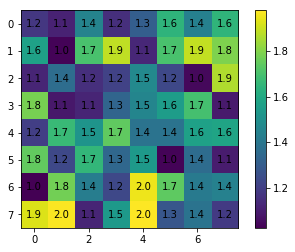

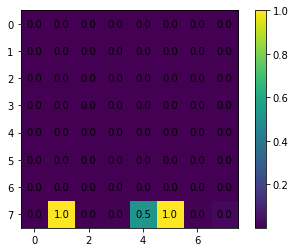

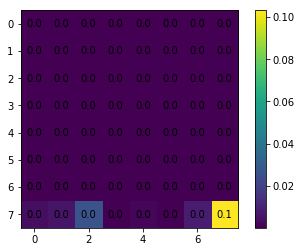

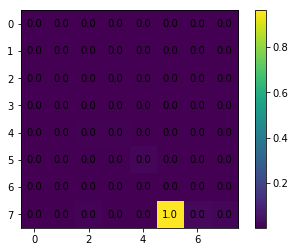

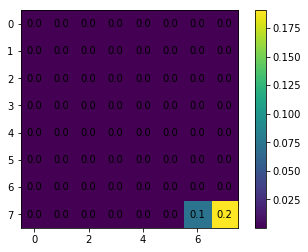

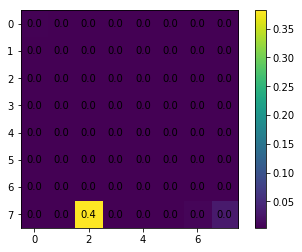

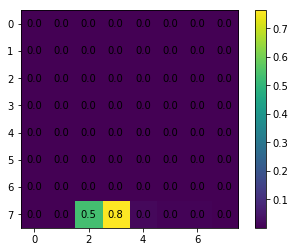

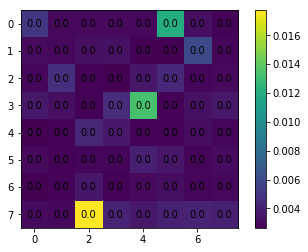

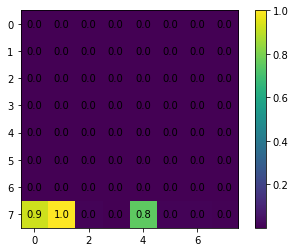

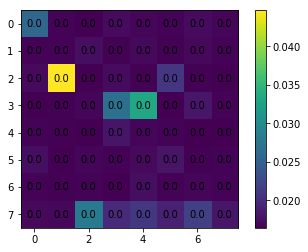

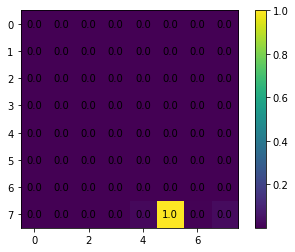

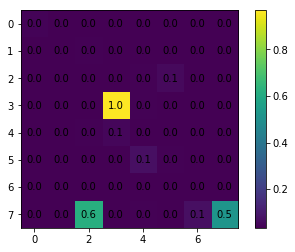

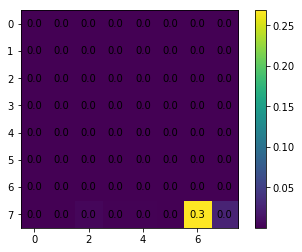

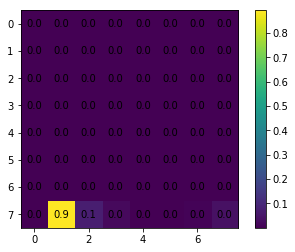

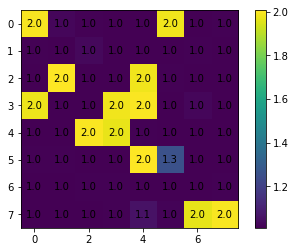

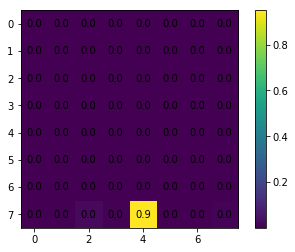

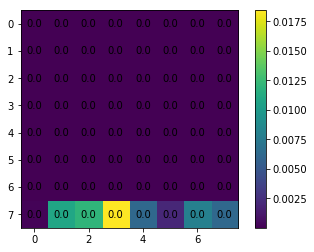

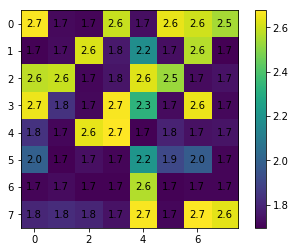

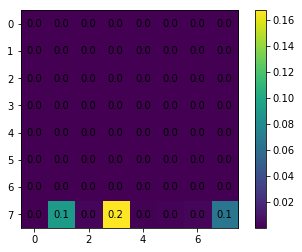

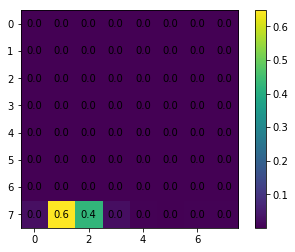

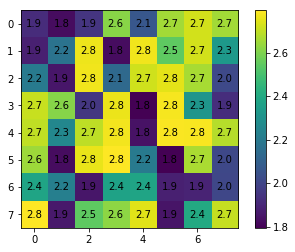

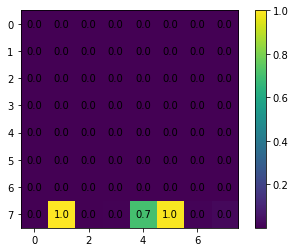

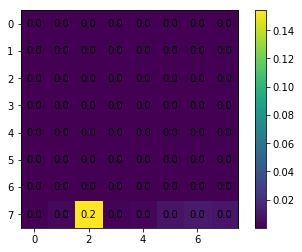

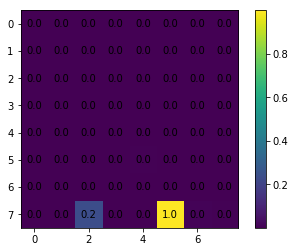

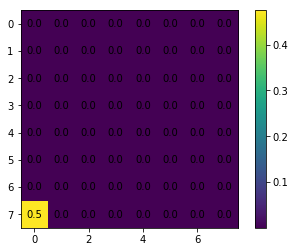

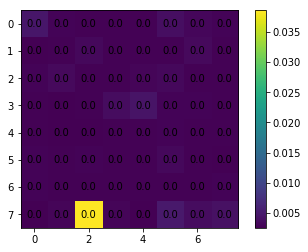

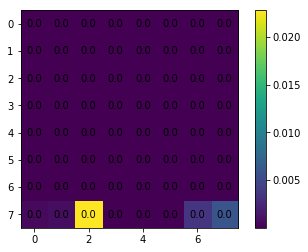

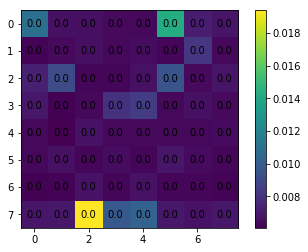

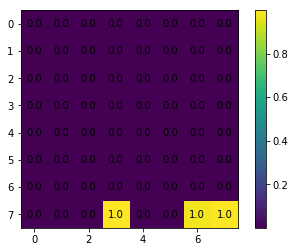

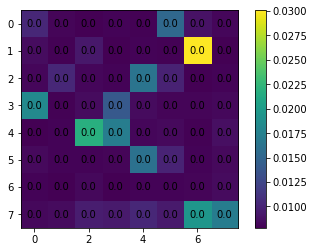

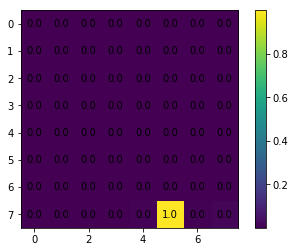

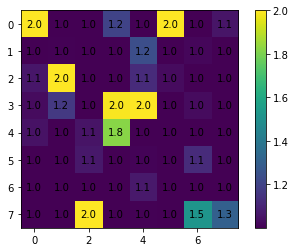

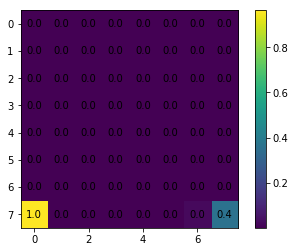

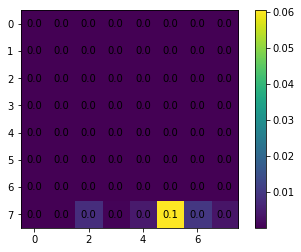

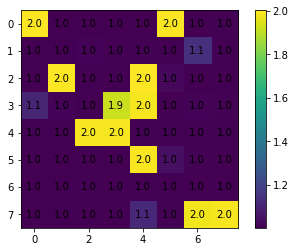

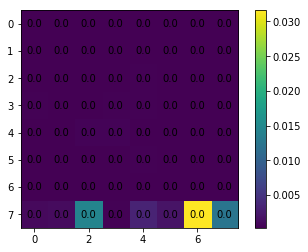

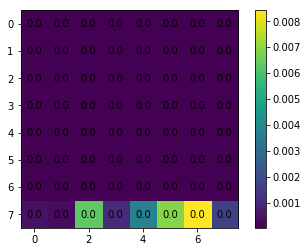

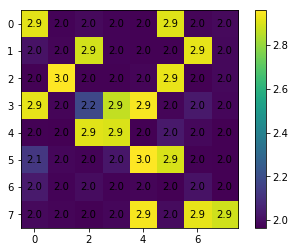

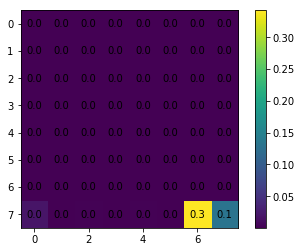

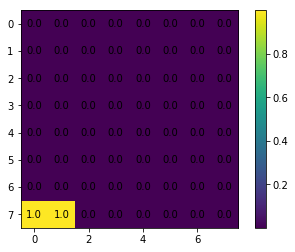

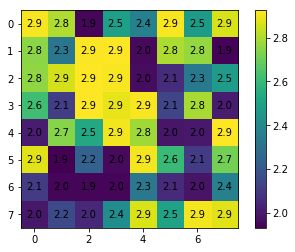

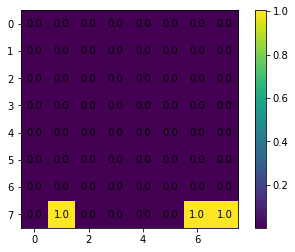

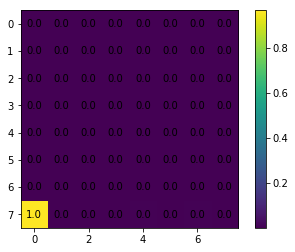

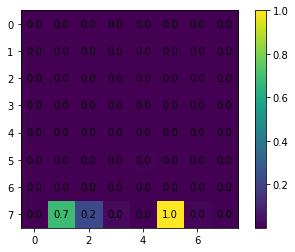

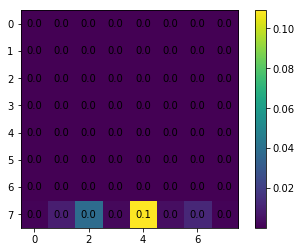

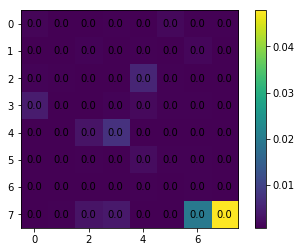

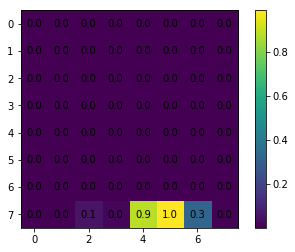

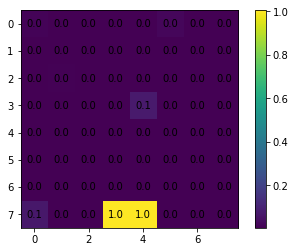

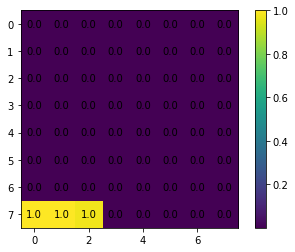

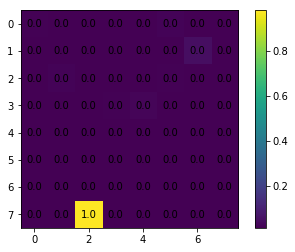

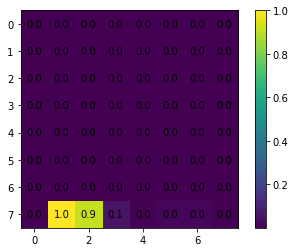

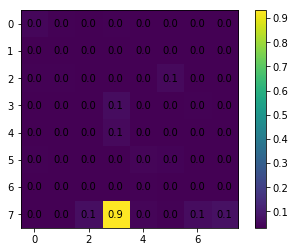

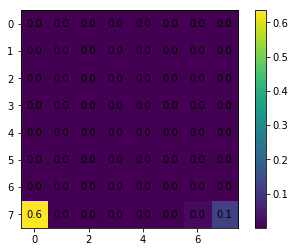

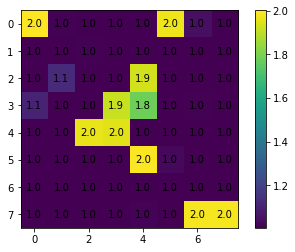

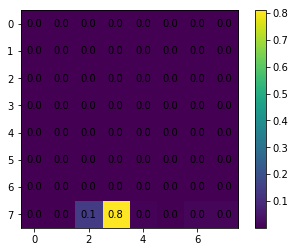

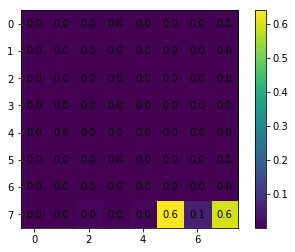

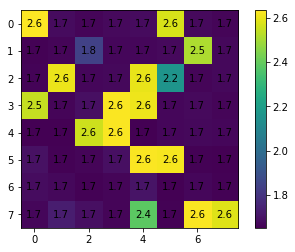

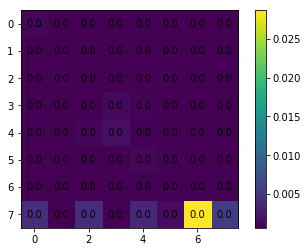

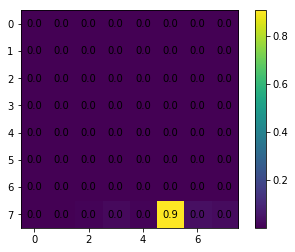

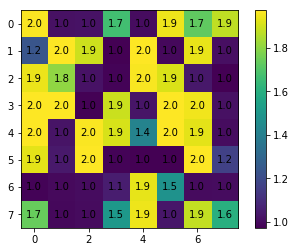

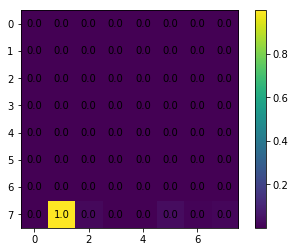

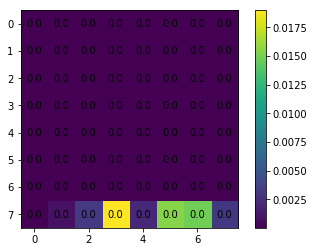

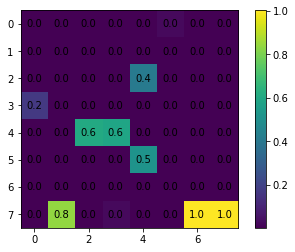

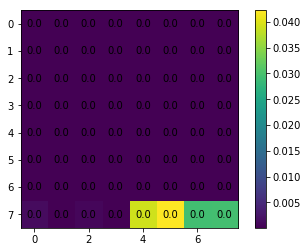

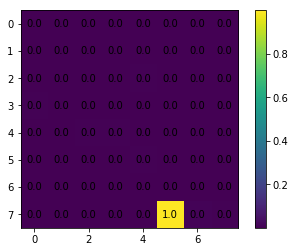

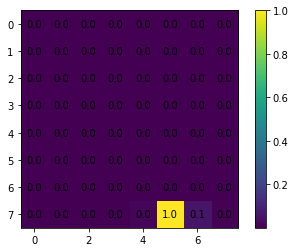

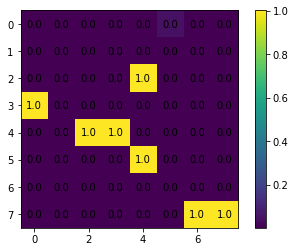

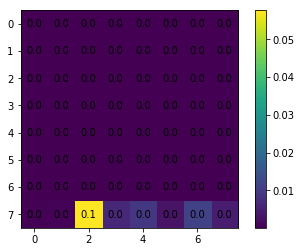

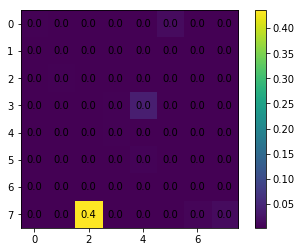

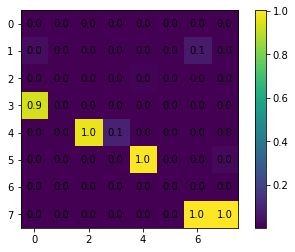

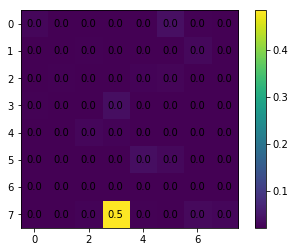

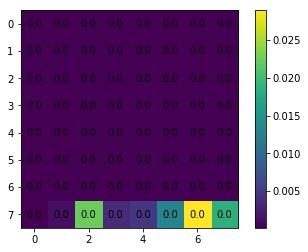

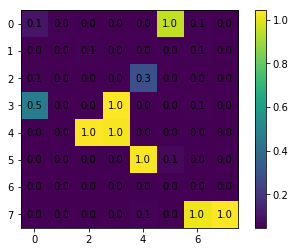

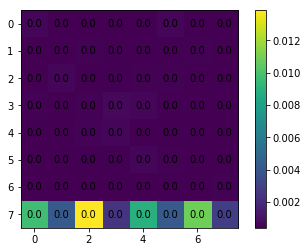

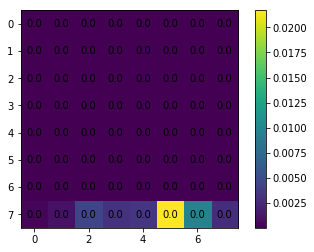

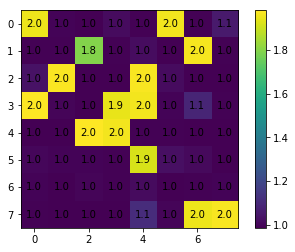

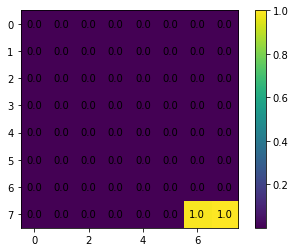

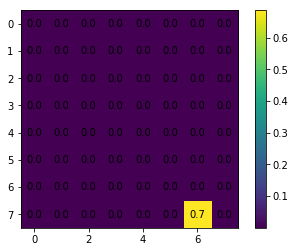

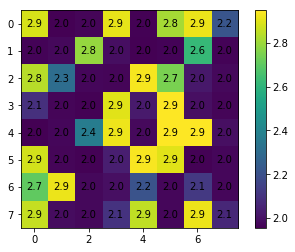

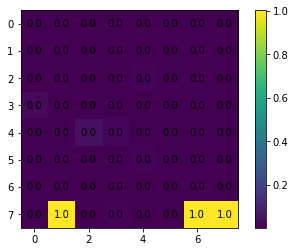

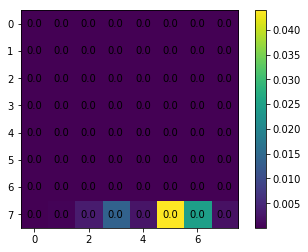

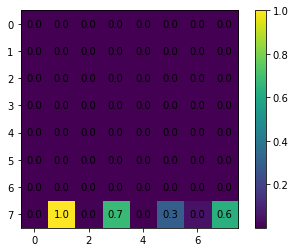

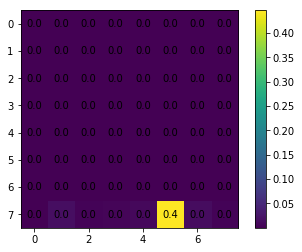

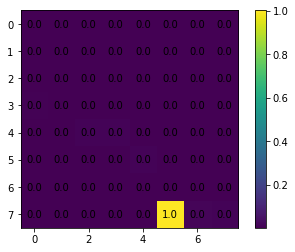

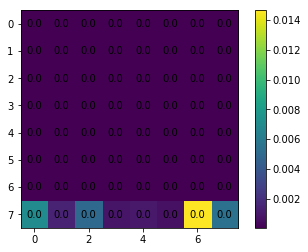

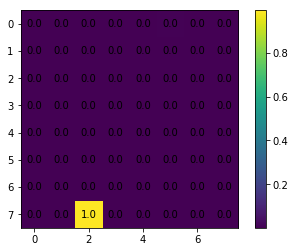

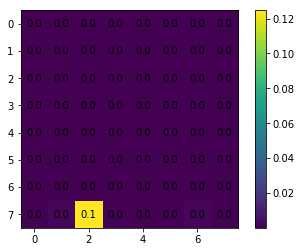

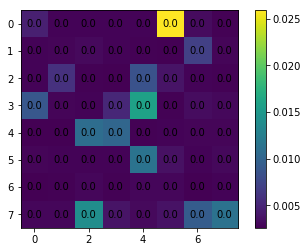

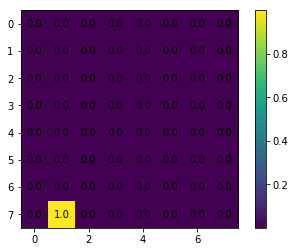

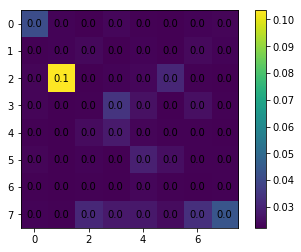

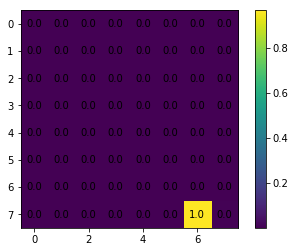

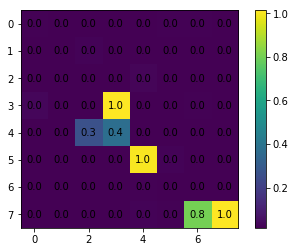

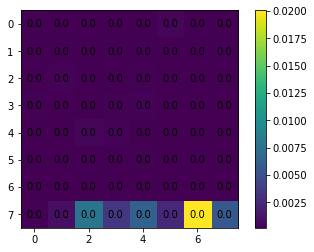

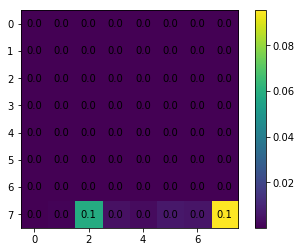

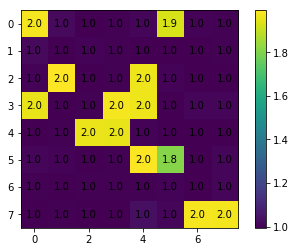

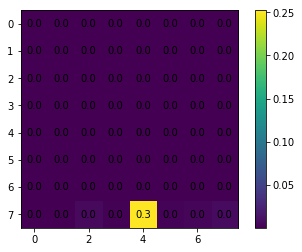

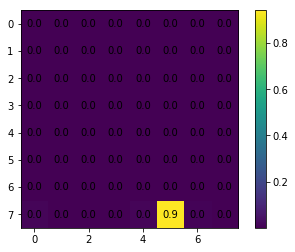

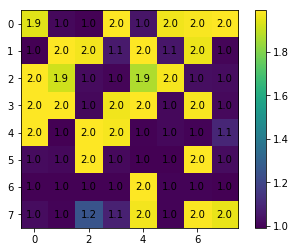

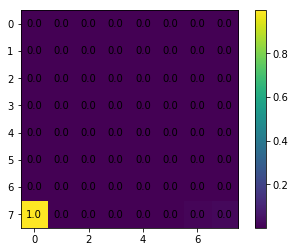

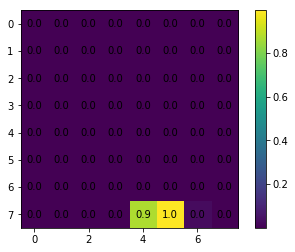

In [11]:
# Complex architecture
Dtest = gan.train(epochs=10000, batch_size=30, sample_interval=100)

/anaconda/envs/drl/lib/python2.7/site-packages/ipykernel/__main__.py:79: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/anaconda/envs/drl/lib/python2.7/site-packages/ipykernel/__main__.py:80: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


0 [D loss: 0.727743, acc.: 21.67%] [G loss: 0.636231]
1 [D loss: 0.735434, acc.: 36.67%] [G loss: 0.656750]
2 [D loss: 0.743422, acc.: 31.67%] [G loss: 0.626935]
3 [D loss: 0.715397, acc.: 38.33%] [G loss: 0.637091]
4 [D loss: 0.723105, acc.: 48.33%] [G loss: 0.636633]
5 [D loss: 0.722825, acc.: 48.33%] [G loss: 0.627886]
6 [D loss: 0.716299, acc.: 46.67%] [G loss: 0.620981]
7 [D loss: 0.736290, acc.: 33.33%] [G loss: 0.627809]
8 [D loss: 0.749028, acc.: 31.67%] [G loss: 0.635999]
9 [D loss: 0.754772, acc.: 25.00%] [G loss: 0.622140]
10 [D loss: 0.759628, acc.: 28.33%] [G loss: 0.619059]
11 [D loss: 0.771838, acc.: 25.00%] [G loss: 0.623194]
12 [D loss: 0.785754, acc.: 16.67%] [G loss: 0.608776]
13 [D loss: 0.771479, acc.: 21.67%] [G loss: 0.619237]
14 [D loss: 0.776441, acc.: 23.33%] [G loss: 0.583260]
15 [D loss: 0.774324, acc.: 20.00%] [G loss: 0.589096]
16 [D loss: 0.763246, acc.: 28.33%] [G loss: 0.593296]
17 [D loss: 0.759147, acc.: 36.67%] [G loss: 0.597216]
18 [D loss: 0.781578

153 [D loss: 0.831201, acc.: 21.67%] [G loss: 0.583405]
154 [D loss: 0.849025, acc.: 23.33%] [G loss: 0.531572]
155 [D loss: 0.846015, acc.: 35.00%] [G loss: 0.552903]
156 [D loss: 0.809651, acc.: 28.33%] [G loss: 0.539059]
157 [D loss: 0.854551, acc.: 30.00%] [G loss: 0.567972]
158 [D loss: 0.827859, acc.: 28.33%] [G loss: 0.554341]
159 [D loss: 0.905451, acc.: 23.33%] [G loss: 0.555686]
160 [D loss: 0.814153, acc.: 30.00%] [G loss: 0.541525]
161 [D loss: 0.834899, acc.: 40.00%] [G loss: 0.554919]
162 [D loss: 0.820680, acc.: 33.33%] [G loss: 0.567294]
163 [D loss: 0.819610, acc.: 31.67%] [G loss: 0.640434]
164 [D loss: 0.825336, acc.: 33.33%] [G loss: 0.549869]
165 [D loss: 0.887077, acc.: 28.33%] [G loss: 0.518507]
166 [D loss: 0.855902, acc.: 23.33%] [G loss: 0.542627]
167 [D loss: 0.789769, acc.: 36.67%] [G loss: 0.672103]
168 [D loss: 0.843297, acc.: 25.00%] [G loss: 0.597297]
169 [D loss: 0.827232, acc.: 28.33%] [G loss: 0.537756]
170 [D loss: 0.784548, acc.: 40.00%] [G loss: 0.

300 [D loss: 0.797592, acc.: 45.00%] [G loss: 0.787967]
301 [D loss: 0.707285, acc.: 51.67%] [G loss: 0.587160]
302 [D loss: 0.793096, acc.: 35.00%] [G loss: 0.680678]
303 [D loss: 0.817580, acc.: 25.00%] [G loss: 0.814804]
304 [D loss: 0.768234, acc.: 45.00%] [G loss: 0.556214]
305 [D loss: 0.763764, acc.: 46.67%] [G loss: 0.734416]
306 [D loss: 0.812011, acc.: 33.33%] [G loss: 0.855773]
307 [D loss: 0.821526, acc.: 35.00%] [G loss: 0.720788]
308 [D loss: 0.768442, acc.: 45.00%] [G loss: 0.646668]
309 [D loss: 0.776089, acc.: 33.33%] [G loss: 0.801989]
310 [D loss: 0.810765, acc.: 43.33%] [G loss: 0.767647]
311 [D loss: 0.742931, acc.: 45.00%] [G loss: 0.645921]
312 [D loss: 0.767525, acc.: 45.00%] [G loss: 0.690281]
313 [D loss: 0.748977, acc.: 38.33%] [G loss: 0.682644]
314 [D loss: 0.755539, acc.: 36.67%] [G loss: 0.741701]
315 [D loss: 0.766894, acc.: 38.33%] [G loss: 0.669386]
316 [D loss: 0.815046, acc.: 35.00%] [G loss: 0.770494]
317 [D loss: 0.845826, acc.: 28.33%] [G loss: 0.

452 [D loss: 0.683623, acc.: 43.33%] [G loss: 0.790361]
453 [D loss: 0.721189, acc.: 43.33%] [G loss: 0.704537]
454 [D loss: 0.764155, acc.: 43.33%] [G loss: 0.770236]
455 [D loss: 0.772978, acc.: 38.33%] [G loss: 0.635001]
456 [D loss: 0.736721, acc.: 48.33%] [G loss: 0.730018]
457 [D loss: 0.742752, acc.: 40.00%] [G loss: 0.862019]
458 [D loss: 0.785828, acc.: 43.33%] [G loss: 0.859000]
459 [D loss: 0.749635, acc.: 45.00%] [G loss: 0.957567]
460 [D loss: 0.870833, acc.: 36.67%] [G loss: 0.755379]
461 [D loss: 0.776837, acc.: 43.33%] [G loss: 0.780820]
462 [D loss: 0.841153, acc.: 35.00%] [G loss: 0.741197]
463 [D loss: 0.847745, acc.: 35.00%] [G loss: 0.769698]
464 [D loss: 0.840443, acc.: 38.33%] [G loss: 0.823038]
465 [D loss: 0.767649, acc.: 46.67%] [G loss: 0.703780]
466 [D loss: 0.839052, acc.: 38.33%] [G loss: 0.804676]
467 [D loss: 0.846203, acc.: 30.00%] [G loss: 0.699478]
468 [D loss: 0.847924, acc.: 40.00%] [G loss: 0.779632]
469 [D loss: 0.833302, acc.: 35.00%] [G loss: 0.

599 [D loss: 0.865010, acc.: 26.67%] [G loss: 0.825147]
600 [D loss: 0.817190, acc.: 36.67%] [G loss: 0.714420]
601 [D loss: 0.788321, acc.: 38.33%] [G loss: 0.604310]
602 [D loss: 0.857078, acc.: 26.67%] [G loss: 0.673450]
603 [D loss: 0.805372, acc.: 30.00%] [G loss: 0.786861]
604 [D loss: 0.842220, acc.: 33.33%] [G loss: 0.702151]
605 [D loss: 0.819564, acc.: 33.33%] [G loss: 0.745481]
606 [D loss: 0.834368, acc.: 33.33%] [G loss: 0.687971]
607 [D loss: 0.811795, acc.: 30.00%] [G loss: 0.621938]
608 [D loss: 0.778583, acc.: 38.33%] [G loss: 0.624030]
609 [D loss: 0.818723, acc.: 38.33%] [G loss: 0.706301]
610 [D loss: 0.776551, acc.: 43.33%] [G loss: 0.726835]
611 [D loss: 0.785223, acc.: 45.00%] [G loss: 0.772395]
612 [D loss: 0.781884, acc.: 43.33%] [G loss: 0.758454]
613 [D loss: 0.865220, acc.: 23.33%] [G loss: 0.927256]
614 [D loss: 0.854368, acc.: 25.00%] [G loss: 0.812276]
615 [D loss: 0.784262, acc.: 33.33%] [G loss: 0.762509]
616 [D loss: 0.836993, acc.: 28.33%] [G loss: 0.

748 [D loss: 0.844766, acc.: 16.67%] [G loss: 0.522725]
749 [D loss: 0.848912, acc.: 15.00%] [G loss: 0.548215]
750 [D loss: 0.834708, acc.: 21.67%] [G loss: 0.549222]
751 [D loss: 0.843789, acc.: 18.33%] [G loss: 0.520151]
752 [D loss: 0.802485, acc.: 25.00%] [G loss: 0.555799]
753 [D loss: 0.824729, acc.: 15.00%] [G loss: 0.540339]
754 [D loss: 0.803685, acc.: 26.67%] [G loss: 0.523660]
755 [D loss: 0.845183, acc.: 13.33%] [G loss: 0.534161]
756 [D loss: 0.817712, acc.: 11.67%] [G loss: 0.555130]
757 [D loss: 0.818585, acc.: 23.33%] [G loss: 0.510129]
758 [D loss: 0.860965, acc.: 11.67%] [G loss: 0.520263]
759 [D loss: 0.833651, acc.: 16.67%] [G loss: 0.523941]
760 [D loss: 0.841950, acc.: 15.00%] [G loss: 0.529576]
761 [D loss: 0.800442, acc.: 31.67%] [G loss: 0.519155]
762 [D loss: 0.842546, acc.: 18.33%] [G loss: 0.534431]
763 [D loss: 0.822910, acc.: 20.00%] [G loss: 0.552858]
764 [D loss: 0.780596, acc.: 20.00%] [G loss: 0.574609]
765 [D loss: 0.826025, acc.: 15.00%] [G loss: 0.

895 [D loss: 0.757092, acc.: 20.00%] [G loss: 0.619078]
896 [D loss: 0.766075, acc.: 16.67%] [G loss: 0.617135]
897 [D loss: 0.750172, acc.: 20.00%] [G loss: 0.625412]
898 [D loss: 0.765842, acc.: 16.67%] [G loss: 0.613483]
899 [D loss: 0.766824, acc.: 11.67%] [G loss: 0.612624]
900 [D loss: 0.751252, acc.: 21.67%] [G loss: 0.622431]
901 [D loss: 0.764508, acc.: 13.33%] [G loss: 0.623137]
902 [D loss: 0.758350, acc.: 18.33%] [G loss: 0.623994]
903 [D loss: 0.756564, acc.: 11.67%] [G loss: 0.619634]
904 [D loss: 0.755191, acc.: 13.33%] [G loss: 0.621755]
905 [D loss: 0.757828, acc.: 10.00%] [G loss: 0.624523]
906 [D loss: 0.776161, acc.: 10.00%] [G loss: 0.631621]
907 [D loss: 0.752383, acc.: 15.00%] [G loss: 0.633147]
908 [D loss: 0.765212, acc.: 11.67%] [G loss: 0.627126]
909 [D loss: 0.749842, acc.: 13.33%] [G loss: 0.638333]
910 [D loss: 0.724113, acc.: 25.00%] [G loss: 0.641181]
911 [D loss: 0.736040, acc.: 23.33%] [G loss: 0.642316]
912 [D loss: 0.739432, acc.: 21.67%] [G loss: 0.

1042 [D loss: 0.688262, acc.: 55.00%] [G loss: 0.752460]
1043 [D loss: 0.687863, acc.: 46.67%] [G loss: 0.754849]
1044 [D loss: 0.699353, acc.: 43.33%] [G loss: 0.749006]
1045 [D loss: 0.692573, acc.: 55.00%] [G loss: 0.755941]
1046 [D loss: 0.681568, acc.: 51.67%] [G loss: 0.761603]
1047 [D loss: 0.690174, acc.: 58.33%] [G loss: 0.756160]
1048 [D loss: 0.689282, acc.: 53.33%] [G loss: 0.761430]
1049 [D loss: 0.689746, acc.: 51.67%] [G loss: 0.755933]
1050 [D loss: 0.684268, acc.: 60.00%] [G loss: 0.764541]
1051 [D loss: 0.690296, acc.: 53.33%] [G loss: 0.767472]
1052 [D loss: 0.670886, acc.: 55.00%] [G loss: 0.767772]
1053 [D loss: 0.680915, acc.: 56.67%] [G loss: 0.778060]
1054 [D loss: 0.679897, acc.: 58.33%] [G loss: 0.770262]
1055 [D loss: 0.687947, acc.: 53.33%] [G loss: 0.765091]
1056 [D loss: 0.695854, acc.: 56.67%] [G loss: 0.763739]
1057 [D loss: 0.674802, acc.: 63.33%] [G loss: 0.783071]
1058 [D loss: 0.681364, acc.: 58.33%] [G loss: 0.769947]
1059 [D loss: 0.678282, acc.: 6

1189 [D loss: 0.646860, acc.: 56.67%] [G loss: 0.888094]
1190 [D loss: 0.641908, acc.: 56.67%] [G loss: 0.878411]
1191 [D loss: 0.633001, acc.: 61.67%] [G loss: 0.884988]
1192 [D loss: 0.633684, acc.: 60.00%] [G loss: 0.869067]
1193 [D loss: 0.633258, acc.: 63.33%] [G loss: 0.883455]
1194 [D loss: 0.638191, acc.: 58.33%] [G loss: 0.872081]
1195 [D loss: 0.621211, acc.: 66.67%] [G loss: 0.894205]
1196 [D loss: 0.632883, acc.: 60.00%] [G loss: 0.886487]
1197 [D loss: 0.640766, acc.: 70.00%] [G loss: 0.886690]
1198 [D loss: 0.631489, acc.: 65.00%] [G loss: 0.874722]
1199 [D loss: 0.631728, acc.: 56.67%] [G loss: 0.890678]
1200 [D loss: 0.635032, acc.: 53.33%] [G loss: 0.868236]
1201 [D loss: 0.633262, acc.: 65.00%] [G loss: 0.880918]
1202 [D loss: 0.639196, acc.: 55.00%] [G loss: 0.888388]
1203 [D loss: 0.639198, acc.: 61.67%] [G loss: 0.885911]
1204 [D loss: 0.639084, acc.: 55.00%] [G loss: 0.886836]
1205 [D loss: 0.632792, acc.: 60.00%] [G loss: 0.891934]
1206 [D loss: 0.639375, acc.: 5

1336 [D loss: 0.615007, acc.: 63.33%] [G loss: 0.961396]
1337 [D loss: 0.600604, acc.: 66.67%] [G loss: 0.952906]
1338 [D loss: 0.610952, acc.: 61.67%] [G loss: 0.951492]
1339 [D loss: 0.611731, acc.: 58.33%] [G loss: 0.961360]
1340 [D loss: 0.622114, acc.: 58.33%] [G loss: 0.949862]
1341 [D loss: 0.609794, acc.: 61.67%] [G loss: 0.947805]
1342 [D loss: 0.609464, acc.: 65.00%] [G loss: 0.944621]
1343 [D loss: 0.616847, acc.: 61.67%] [G loss: 0.944463]
1344 [D loss: 0.617807, acc.: 65.00%] [G loss: 0.938397]
1345 [D loss: 0.621812, acc.: 56.67%] [G loss: 0.957356]
1346 [D loss: 0.605241, acc.: 66.67%] [G loss: 0.955824]
1347 [D loss: 0.607284, acc.: 56.67%] [G loss: 0.948597]
1348 [D loss: 0.608278, acc.: 63.33%] [G loss: 0.951616]
1349 [D loss: 0.611345, acc.: 63.33%] [G loss: 0.950717]
1350 [D loss: 0.605353, acc.: 63.33%] [G loss: 0.958580]
1351 [D loss: 0.616197, acc.: 55.00%] [G loss: 0.950543]
1352 [D loss: 0.608353, acc.: 53.33%] [G loss: 0.956080]
1353 [D loss: 0.598727, acc.: 6

1483 [D loss: 0.610153, acc.: 63.33%] [G loss: 0.954716]
1484 [D loss: 0.615233, acc.: 56.67%] [G loss: 0.946115]
1485 [D loss: 0.611317, acc.: 60.00%] [G loss: 0.945012]
1486 [D loss: 0.612165, acc.: 60.00%] [G loss: 0.944505]
1487 [D loss: 0.602401, acc.: 61.67%] [G loss: 0.962926]
1488 [D loss: 0.612823, acc.: 60.00%] [G loss: 0.942731]
1489 [D loss: 0.610549, acc.: 60.00%] [G loss: 0.969434]
1490 [D loss: 0.609134, acc.: 58.33%] [G loss: 0.940998]
1491 [D loss: 0.604971, acc.: 61.67%] [G loss: 0.953789]
1492 [D loss: 0.595359, acc.: 65.00%] [G loss: 0.945512]
1493 [D loss: 0.603722, acc.: 65.00%] [G loss: 0.937942]
1494 [D loss: 0.599508, acc.: 68.33%] [G loss: 0.951955]
1495 [D loss: 0.598312, acc.: 60.00%] [G loss: 0.953916]
1496 [D loss: 0.613739, acc.: 60.00%] [G loss: 0.945696]
1497 [D loss: 0.603734, acc.: 66.67%] [G loss: 0.954777]
1498 [D loss: 0.604794, acc.: 60.00%] [G loss: 0.947946]
1499 [D loss: 0.605534, acc.: 63.33%] [G loss: 0.973456]
1500 [D loss: 0.604378, acc.: 7

1629 [D loss: 0.616943, acc.: 60.00%] [G loss: 0.929753]
1630 [D loss: 0.614001, acc.: 68.33%] [G loss: 0.928405]
1631 [D loss: 0.619964, acc.: 63.33%] [G loss: 0.916721]
1632 [D loss: 0.611947, acc.: 63.33%] [G loss: 0.923897]
1633 [D loss: 0.618038, acc.: 60.00%] [G loss: 0.927476]
1634 [D loss: 0.619917, acc.: 61.67%] [G loss: 0.913617]
1635 [D loss: 0.617921, acc.: 58.33%] [G loss: 0.916645]
1636 [D loss: 0.614893, acc.: 61.67%] [G loss: 0.908623]
1637 [D loss: 0.621695, acc.: 63.33%] [G loss: 0.913672]
1638 [D loss: 0.613400, acc.: 70.00%] [G loss: 0.909437]
1639 [D loss: 0.612033, acc.: 70.00%] [G loss: 0.924326]
1640 [D loss: 0.620431, acc.: 66.67%] [G loss: 0.902691]
1641 [D loss: 0.622530, acc.: 63.33%] [G loss: 0.908300]
1642 [D loss: 0.619448, acc.: 63.33%] [G loss: 0.916786]
1643 [D loss: 0.625875, acc.: 65.00%] [G loss: 0.912395]
1644 [D loss: 0.620354, acc.: 65.00%] [G loss: 0.921787]
1645 [D loss: 0.632256, acc.: 63.33%] [G loss: 0.905764]
1646 [D loss: 0.622508, acc.: 6

1774 [D loss: 0.635569, acc.: 66.67%] [G loss: 0.884686]
1775 [D loss: 0.631387, acc.: 61.67%] [G loss: 0.880273]
1776 [D loss: 0.625811, acc.: 61.67%] [G loss: 0.889013]
1777 [D loss: 0.637538, acc.: 58.33%] [G loss: 0.892814]
1778 [D loss: 0.631711, acc.: 68.33%] [G loss: 0.895423]
1779 [D loss: 0.621128, acc.: 65.00%] [G loss: 0.876843]
1780 [D loss: 0.626789, acc.: 65.00%] [G loss: 0.876767]
1781 [D loss: 0.625495, acc.: 65.00%] [G loss: 0.875168]
1782 [D loss: 0.626722, acc.: 65.00%] [G loss: 0.894614]
1783 [D loss: 0.626945, acc.: 71.67%] [G loss: 0.878100]
1784 [D loss: 0.615841, acc.: 73.33%] [G loss: 0.878207]
1785 [D loss: 0.632926, acc.: 63.33%] [G loss: 0.885944]
1786 [D loss: 0.625993, acc.: 73.33%] [G loss: 0.899321]
1787 [D loss: 0.647962, acc.: 66.67%] [G loss: 0.878264]
1788 [D loss: 0.625559, acc.: 68.33%] [G loss: 0.900553]
1789 [D loss: 0.620118, acc.: 65.00%] [G loss: 0.879298]
1790 [D loss: 0.625853, acc.: 63.33%] [G loss: 0.877837]
1791 [D loss: 0.636586, acc.: 6

1920 [D loss: 0.619837, acc.: 75.00%] [G loss: 0.876037]
1921 [D loss: 0.642857, acc.: 71.67%] [G loss: 0.876563]
1922 [D loss: 0.640536, acc.: 68.33%] [G loss: 0.846603]
1923 [D loss: 0.656269, acc.: 68.33%] [G loss: 0.859783]
1924 [D loss: 0.624428, acc.: 75.00%] [G loss: 0.879663]
1925 [D loss: 0.638891, acc.: 63.33%] [G loss: 0.882617]
1926 [D loss: 0.629467, acc.: 73.33%] [G loss: 0.867170]
1927 [D loss: 0.599819, acc.: 76.67%] [G loss: 0.855632]
1928 [D loss: 0.652387, acc.: 68.33%] [G loss: 0.846075]
1929 [D loss: 0.639719, acc.: 66.67%] [G loss: 0.882092]
1930 [D loss: 0.609435, acc.: 75.00%] [G loss: 0.869394]
1931 [D loss: 0.636585, acc.: 78.33%] [G loss: 0.854514]
1932 [D loss: 0.636612, acc.: 70.00%] [G loss: 0.848180]
1933 [D loss: 0.639545, acc.: 75.00%] [G loss: 0.894771]
1934 [D loss: 0.633367, acc.: 71.67%] [G loss: 0.855385]
1935 [D loss: 0.638734, acc.: 66.67%] [G loss: 0.884099]
1936 [D loss: 0.610566, acc.: 65.00%] [G loss: 0.876853]
1937 [D loss: 0.620705, acc.: 7

2067 [D loss: 0.630636, acc.: 71.67%] [G loss: 0.840527]
2068 [D loss: 0.643615, acc.: 71.67%] [G loss: 0.871493]
2069 [D loss: 0.656332, acc.: 70.00%] [G loss: 0.821287]
2070 [D loss: 0.645020, acc.: 76.67%] [G loss: 0.828220]
2071 [D loss: 0.641509, acc.: 73.33%] [G loss: 0.852884]
2072 [D loss: 0.648363, acc.: 68.33%] [G loss: 0.836305]
2073 [D loss: 0.636757, acc.: 73.33%] [G loss: 0.882407]
2074 [D loss: 0.644351, acc.: 73.33%] [G loss: 0.863636]
2075 [D loss: 0.652712, acc.: 75.00%] [G loss: 0.837971]
2076 [D loss: 0.642427, acc.: 76.67%] [G loss: 0.841703]
2077 [D loss: 0.656742, acc.: 71.67%] [G loss: 0.833226]
2078 [D loss: 0.635524, acc.: 71.67%] [G loss: 0.856248]
2079 [D loss: 0.650049, acc.: 70.00%] [G loss: 0.838028]
2080 [D loss: 0.630093, acc.: 76.67%] [G loss: 0.835082]
2081 [D loss: 0.651566, acc.: 70.00%] [G loss: 0.821333]
2082 [D loss: 0.643048, acc.: 76.67%] [G loss: 0.835473]
2083 [D loss: 0.630583, acc.: 83.33%] [G loss: 0.853553]
2084 [D loss: 0.640952, acc.: 8

2213 [D loss: 0.638005, acc.: 73.33%] [G loss: 0.818010]
2214 [D loss: 0.653549, acc.: 76.67%] [G loss: 0.810812]
2215 [D loss: 0.658053, acc.: 71.67%] [G loss: 0.782189]
2216 [D loss: 0.635883, acc.: 75.00%] [G loss: 0.815241]
2217 [D loss: 0.647980, acc.: 71.67%] [G loss: 0.805379]
2218 [D loss: 0.652287, acc.: 78.33%] [G loss: 0.802195]
2219 [D loss: 0.657167, acc.: 78.33%] [G loss: 0.809157]
2220 [D loss: 0.653870, acc.: 80.00%] [G loss: 0.821682]
2221 [D loss: 0.659271, acc.: 75.00%] [G loss: 0.795277]
2222 [D loss: 0.643665, acc.: 71.67%] [G loss: 0.794702]
2223 [D loss: 0.656305, acc.: 66.67%] [G loss: 0.802923]
2224 [D loss: 0.652793, acc.: 81.67%] [G loss: 0.808734]
2225 [D loss: 0.655683, acc.: 76.67%] [G loss: 0.815744]
2226 [D loss: 0.631933, acc.: 76.67%] [G loss: 0.839144]
2227 [D loss: 0.649231, acc.: 71.67%] [G loss: 0.787868]
2228 [D loss: 0.646437, acc.: 81.67%] [G loss: 0.793146]
2229 [D loss: 0.658936, acc.: 80.00%] [G loss: 0.797479]
2230 [D loss: 0.651978, acc.: 7

2357 [D loss: 0.654032, acc.: 80.00%] [G loss: 0.782409]
2358 [D loss: 0.657922, acc.: 78.33%] [G loss: 0.771366]
2359 [D loss: 0.647351, acc.: 78.33%] [G loss: 0.787790]
2360 [D loss: 0.632137, acc.: 81.67%] [G loss: 0.767643]
2361 [D loss: 0.639235, acc.: 70.00%] [G loss: 0.749687]
2362 [D loss: 0.658520, acc.: 75.00%] [G loss: 0.767437]
2363 [D loss: 0.647988, acc.: 81.67%] [G loss: 0.792226]
2364 [D loss: 0.655996, acc.: 78.33%] [G loss: 0.787971]
2365 [D loss: 0.655814, acc.: 75.00%] [G loss: 0.765302]
2366 [D loss: 0.647256, acc.: 81.67%] [G loss: 0.768156]
2367 [D loss: 0.654607, acc.: 73.33%] [G loss: 0.795131]
2368 [D loss: 0.659074, acc.: 68.33%] [G loss: 0.768506]
2369 [D loss: 0.657901, acc.: 76.67%] [G loss: 0.757713]
2370 [D loss: 0.669208, acc.: 71.67%] [G loss: 0.756882]
2371 [D loss: 0.660981, acc.: 75.00%] [G loss: 0.778965]
2372 [D loss: 0.653321, acc.: 68.33%] [G loss: 0.794217]
2373 [D loss: 0.663066, acc.: 68.33%] [G loss: 0.778717]
2374 [D loss: 0.651266, acc.: 7

2501 [D loss: 0.678828, acc.: 48.33%] [G loss: 0.752066]
2502 [D loss: 0.658272, acc.: 58.33%] [G loss: 0.769413]
2503 [D loss: 0.675554, acc.: 60.00%] [G loss: 0.751793]
2504 [D loss: 0.659422, acc.: 55.00%] [G loss: 0.739728]
2505 [D loss: 0.660775, acc.: 51.67%] [G loss: 0.763129]
2506 [D loss: 0.650402, acc.: 66.67%] [G loss: 0.772906]
2507 [D loss: 0.673432, acc.: 53.33%] [G loss: 0.754465]
2508 [D loss: 0.653592, acc.: 63.33%] [G loss: 0.761310]
2509 [D loss: 0.661722, acc.: 56.67%] [G loss: 0.763885]
2510 [D loss: 0.649123, acc.: 63.33%] [G loss: 0.740388]
2511 [D loss: 0.653995, acc.: 65.00%] [G loss: 0.776957]
2512 [D loss: 0.666756, acc.: 53.33%] [G loss: 0.751190]
2513 [D loss: 0.664969, acc.: 55.00%] [G loss: 0.785229]
2514 [D loss: 0.669206, acc.: 56.67%] [G loss: 0.757451]
2515 [D loss: 0.657622, acc.: 60.00%] [G loss: 0.764627]
2516 [D loss: 0.672195, acc.: 50.00%] [G loss: 0.749216]
2517 [D loss: 0.653795, acc.: 61.67%] [G loss: 0.745963]
2518 [D loss: 0.649146, acc.: 7

2648 [D loss: 0.653111, acc.: 70.00%] [G loss: 0.767783]
2649 [D loss: 0.673018, acc.: 61.67%] [G loss: 0.757178]
2650 [D loss: 0.674720, acc.: 60.00%] [G loss: 0.745111]
2651 [D loss: 0.668485, acc.: 73.33%] [G loss: 0.757717]
2652 [D loss: 0.667511, acc.: 63.33%] [G loss: 0.748787]
2653 [D loss: 0.665321, acc.: 63.33%] [G loss: 0.752582]
2654 [D loss: 0.664000, acc.: 61.67%] [G loss: 0.766421]
2655 [D loss: 0.666968, acc.: 68.33%] [G loss: 0.753272]
2656 [D loss: 0.672173, acc.: 70.00%] [G loss: 0.765768]
2657 [D loss: 0.668127, acc.: 80.00%] [G loss: 0.735473]
2658 [D loss: 0.670739, acc.: 75.00%] [G loss: 0.754078]
2659 [D loss: 0.662713, acc.: 68.33%] [G loss: 0.747818]
2660 [D loss: 0.659798, acc.: 60.00%] [G loss: 0.748710]
2661 [D loss: 0.665378, acc.: 70.00%] [G loss: 0.759894]
2662 [D loss: 0.657594, acc.: 68.33%] [G loss: 0.782107]
2663 [D loss: 0.677859, acc.: 63.33%] [G loss: 0.741492]
2664 [D loss: 0.654128, acc.: 73.33%] [G loss: 0.739630]
2665 [D loss: 0.660891, acc.: 5

2793 [D loss: 0.679727, acc.: 51.67%] [G loss: 0.758352]
2794 [D loss: 0.681427, acc.: 50.00%] [G loss: 0.727200]
2795 [D loss: 0.658623, acc.: 56.67%] [G loss: 0.740708]
2796 [D loss: 0.690647, acc.: 36.67%] [G loss: 0.733168]
2797 [D loss: 0.664549, acc.: 51.67%] [G loss: 0.745474]
2798 [D loss: 0.667150, acc.: 45.00%] [G loss: 0.740044]
2799 [D loss: 0.673938, acc.: 46.67%] [G loss: 0.745558]
2800 [D loss: 0.678294, acc.: 40.00%] [G loss: 0.731293]
2801 [D loss: 0.655772, acc.: 55.00%] [G loss: 0.725015]
2802 [D loss: 0.670596, acc.: 48.33%] [G loss: 0.722402]
2803 [D loss: 0.666702, acc.: 55.00%] [G loss: 0.750859]
2804 [D loss: 0.680468, acc.: 43.33%] [G loss: 0.730854]
2805 [D loss: 0.682192, acc.: 30.00%] [G loss: 0.736283]
2806 [D loss: 0.674090, acc.: 48.33%] [G loss: 0.731828]
2807 [D loss: 0.664282, acc.: 56.67%] [G loss: 0.724706]
2808 [D loss: 0.671803, acc.: 60.00%] [G loss: 0.735136]
2809 [D loss: 0.667869, acc.: 46.67%] [G loss: 0.735303]
2810 [D loss: 0.668455, acc.: 5

2938 [D loss: 0.668965, acc.: 70.00%] [G loss: 0.724920]
2939 [D loss: 0.659913, acc.: 65.00%] [G loss: 0.710693]
2940 [D loss: 0.674289, acc.: 66.67%] [G loss: 0.718594]
2941 [D loss: 0.666593, acc.: 60.00%] [G loss: 0.719851]
2942 [D loss: 0.661146, acc.: 68.33%] [G loss: 0.721964]
2943 [D loss: 0.669304, acc.: 68.33%] [G loss: 0.711660]
2944 [D loss: 0.678334, acc.: 66.67%] [G loss: 0.718772]
2945 [D loss: 0.683086, acc.: 43.33%] [G loss: 0.709112]
2946 [D loss: 0.666752, acc.: 66.67%] [G loss: 0.712905]
2947 [D loss: 0.670023, acc.: 61.67%] [G loss: 0.711871]
2948 [D loss: 0.676248, acc.: 60.00%] [G loss: 0.723871]
2949 [D loss: 0.677536, acc.: 61.67%] [G loss: 0.712343]
2950 [D loss: 0.668114, acc.: 63.33%] [G loss: 0.713889]
2951 [D loss: 0.671148, acc.: 58.33%] [G loss: 0.724622]
2952 [D loss: 0.676941, acc.: 58.33%] [G loss: 0.716449]
2953 [D loss: 0.684617, acc.: 55.00%] [G loss: 0.720640]
2954 [D loss: 0.668240, acc.: 60.00%] [G loss: 0.718754]
2955 [D loss: 0.678847, acc.: 5

3085 [D loss: 0.685749, acc.: 46.67%] [G loss: 0.698570]
3086 [D loss: 0.695653, acc.: 41.67%] [G loss: 0.697041]
3087 [D loss: 0.681071, acc.: 48.33%] [G loss: 0.707406]
3088 [D loss: 0.688531, acc.: 43.33%] [G loss: 0.702920]
3089 [D loss: 0.688236, acc.: 41.67%] [G loss: 0.699611]
3090 [D loss: 0.688006, acc.: 46.67%] [G loss: 0.690915]
3091 [D loss: 0.690028, acc.: 40.00%] [G loss: 0.695444]
3092 [D loss: 0.688904, acc.: 43.33%] [G loss: 0.712585]
3093 [D loss: 0.688864, acc.: 43.33%] [G loss: 0.694637]
3094 [D loss: 0.680366, acc.: 51.67%] [G loss: 0.693070]
3095 [D loss: 0.677254, acc.: 51.67%] [G loss: 0.697591]
3096 [D loss: 0.691345, acc.: 41.67%] [G loss: 0.690540]
3097 [D loss: 0.676581, acc.: 50.00%] [G loss: 0.696349]
3098 [D loss: 0.682275, acc.: 38.33%] [G loss: 0.696563]
3099 [D loss: 0.694263, acc.: 41.67%] [G loss: 0.691216]
3100 [D loss: 0.680030, acc.: 50.00%] [G loss: 0.698708]
3101 [D loss: 0.692424, acc.: 38.33%] [G loss: 0.707586]
3102 [D loss: 0.676984, acc.: 5

3231 [D loss: 0.686739, acc.: 46.67%] [G loss: 0.695892]
3232 [D loss: 0.681162, acc.: 43.33%] [G loss: 0.701343]
3233 [D loss: 0.681712, acc.: 41.67%] [G loss: 0.692987]
3234 [D loss: 0.682857, acc.: 40.00%] [G loss: 0.695565]
3235 [D loss: 0.685181, acc.: 46.67%] [G loss: 0.694445]
3236 [D loss: 0.684460, acc.: 48.33%] [G loss: 0.702963]
3237 [D loss: 0.690198, acc.: 38.33%] [G loss: 0.699219]
3238 [D loss: 0.672951, acc.: 50.00%] [G loss: 0.696125]
3239 [D loss: 0.680650, acc.: 41.67%] [G loss: 0.685073]
3240 [D loss: 0.682891, acc.: 40.00%] [G loss: 0.692519]
3241 [D loss: 0.673802, acc.: 48.33%] [G loss: 0.687856]
3242 [D loss: 0.669679, acc.: 51.67%] [G loss: 0.683834]
3243 [D loss: 0.683036, acc.: 43.33%] [G loss: 0.688873]
3244 [D loss: 0.689937, acc.: 40.00%] [G loss: 0.690898]
3245 [D loss: 0.680637, acc.: 41.67%] [G loss: 0.695787]
3246 [D loss: 0.687304, acc.: 41.67%] [G loss: 0.692765]
3247 [D loss: 0.675698, acc.: 46.67%] [G loss: 0.690821]
3248 [D loss: 0.691509, acc.: 4

3380 [D loss: 0.681966, acc.: 50.00%] [G loss: 0.693356]
3381 [D loss: 0.678942, acc.: 51.67%] [G loss: 0.693691]
3382 [D loss: 0.685962, acc.: 45.00%] [G loss: 0.699938]
3383 [D loss: 0.683992, acc.: 43.33%] [G loss: 0.706303]
3384 [D loss: 0.671422, acc.: 46.67%] [G loss: 0.708140]
3385 [D loss: 0.683944, acc.: 43.33%] [G loss: 0.702070]
3386 [D loss: 0.681952, acc.: 43.33%] [G loss: 0.700251]
3387 [D loss: 0.681996, acc.: 46.67%] [G loss: 0.703537]
3388 [D loss: 0.682379, acc.: 40.00%] [G loss: 0.695169]
3389 [D loss: 0.683050, acc.: 43.33%] [G loss: 0.695103]
3390 [D loss: 0.677837, acc.: 50.00%] [G loss: 0.704904]
3391 [D loss: 0.676328, acc.: 50.00%] [G loss: 0.695480]
3392 [D loss: 0.683840, acc.: 43.33%] [G loss: 0.694473]
3393 [D loss: 0.687965, acc.: 38.33%] [G loss: 0.699885]
3394 [D loss: 0.678518, acc.: 41.67%] [G loss: 0.699585]
3395 [D loss: 0.680131, acc.: 56.67%] [G loss: 0.698417]
3396 [D loss: 0.685506, acc.: 41.67%] [G loss: 0.700566]
3397 [D loss: 0.683597, acc.: 4

3528 [D loss: 0.679467, acc.: 71.67%] [G loss: 0.692142]
3529 [D loss: 0.677717, acc.: 73.33%] [G loss: 0.692201]
3530 [D loss: 0.681769, acc.: 55.00%] [G loss: 0.695077]
3531 [D loss: 0.683656, acc.: 71.67%] [G loss: 0.693468]
3532 [D loss: 0.683714, acc.: 63.33%] [G loss: 0.692287]
3533 [D loss: 0.677270, acc.: 75.00%] [G loss: 0.693514]
3534 [D loss: 0.689528, acc.: 61.67%] [G loss: 0.691386]
3535 [D loss: 0.685203, acc.: 75.00%] [G loss: 0.693471]
3536 [D loss: 0.678901, acc.: 63.33%] [G loss: 0.693500]
3537 [D loss: 0.679911, acc.: 76.67%] [G loss: 0.691185]
3538 [D loss: 0.677058, acc.: 75.00%] [G loss: 0.693755]
3539 [D loss: 0.686856, acc.: 71.67%] [G loss: 0.693491]
3540 [D loss: 0.684606, acc.: 61.67%] [G loss: 0.691894]
3541 [D loss: 0.682769, acc.: 71.67%] [G loss: 0.694475]
3542 [D loss: 0.682534, acc.: 76.67%] [G loss: 0.692722]
3543 [D loss: 0.685271, acc.: 71.67%] [G loss: 0.694273]
3544 [D loss: 0.680205, acc.: 73.33%] [G loss: 0.691934]
3545 [D loss: 0.684325, acc.: 6

3673 [D loss: 0.693083, acc.: 41.67%] [G loss: 0.688481]
3674 [D loss: 0.686710, acc.: 63.33%] [G loss: 0.690148]
3675 [D loss: 0.686392, acc.: 53.33%] [G loss: 0.688906]
3676 [D loss: 0.678458, acc.: 51.67%] [G loss: 0.688108]
3677 [D loss: 0.688092, acc.: 43.33%] [G loss: 0.690476]
3678 [D loss: 0.689122, acc.: 53.33%] [G loss: 0.688019]
3679 [D loss: 0.680352, acc.: 63.33%] [G loss: 0.687817]
3680 [D loss: 0.691186, acc.: 53.33%] [G loss: 0.690306]
3681 [D loss: 0.687277, acc.: 58.33%] [G loss: 0.689662]
3682 [D loss: 0.689143, acc.: 51.67%] [G loss: 0.687093]
3683 [D loss: 0.686560, acc.: 55.00%] [G loss: 0.688040]
3684 [D loss: 0.687796, acc.: 46.67%] [G loss: 0.688268]
3685 [D loss: 0.688166, acc.: 46.67%] [G loss: 0.690769]
3686 [D loss: 0.682589, acc.: 45.00%] [G loss: 0.690471]
3687 [D loss: 0.684721, acc.: 53.33%] [G loss: 0.690292]
3688 [D loss: 0.685079, acc.: 53.33%] [G loss: 0.689412]
3689 [D loss: 0.685937, acc.: 51.67%] [G loss: 0.689567]
3690 [D loss: 0.681786, acc.: 5

3818 [D loss: 0.695150, acc.: 33.33%] [G loss: 0.689045]
3819 [D loss: 0.686282, acc.: 46.67%] [G loss: 0.689033]
3820 [D loss: 0.688177, acc.: 41.67%] [G loss: 0.688472]
3821 [D loss: 0.692650, acc.: 43.33%] [G loss: 0.690823]
3822 [D loss: 0.698906, acc.: 33.33%] [G loss: 0.691029]
3823 [D loss: 0.690607, acc.: 38.33%] [G loss: 0.690951]
3824 [D loss: 0.689009, acc.: 41.67%] [G loss: 0.689436]
3825 [D loss: 0.690477, acc.: 41.67%] [G loss: 0.690457]
3826 [D loss: 0.689708, acc.: 48.33%] [G loss: 0.691271]
3827 [D loss: 0.683499, acc.: 40.00%] [G loss: 0.692022]
3828 [D loss: 0.689777, acc.: 43.33%] [G loss: 0.692320]
3829 [D loss: 0.686671, acc.: 43.33%] [G loss: 0.690757]
3830 [D loss: 0.693096, acc.: 38.33%] [G loss: 0.689402]
3831 [D loss: 0.678946, acc.: 45.00%] [G loss: 0.689521]
3832 [D loss: 0.676708, acc.: 43.33%] [G loss: 0.690762]
3833 [D loss: 0.693848, acc.: 28.33%] [G loss: 0.690240]
3834 [D loss: 0.691300, acc.: 35.00%] [G loss: 0.690593]
3835 [D loss: 0.694933, acc.: 2

3966 [D loss: 0.687549, acc.: 43.33%] [G loss: 0.699932]
3967 [D loss: 0.689783, acc.: 36.67%] [G loss: 0.700100]
3968 [D loss: 0.685470, acc.: 40.00%] [G loss: 0.697195]
3969 [D loss: 0.683240, acc.: 56.67%] [G loss: 0.698161]
3970 [D loss: 0.687573, acc.: 45.00%] [G loss: 0.697441]
3971 [D loss: 0.681011, acc.: 45.00%] [G loss: 0.697654]
3972 [D loss: 0.688899, acc.: 41.67%] [G loss: 0.698957]
3973 [D loss: 0.681893, acc.: 48.33%] [G loss: 0.698264]
3974 [D loss: 0.681054, acc.: 50.00%] [G loss: 0.697087]
3975 [D loss: 0.688247, acc.: 40.00%] [G loss: 0.701367]
3976 [D loss: 0.682171, acc.: 53.33%] [G loss: 0.697857]
3977 [D loss: 0.685250, acc.: 45.00%] [G loss: 0.695796]
3978 [D loss: 0.688864, acc.: 38.33%] [G loss: 0.697294]
3979 [D loss: 0.679076, acc.: 53.33%] [G loss: 0.697332]
3980 [D loss: 0.690249, acc.: 45.00%] [G loss: 0.697604]
3981 [D loss: 0.690576, acc.: 45.00%] [G loss: 0.694173]
3982 [D loss: 0.679231, acc.: 46.67%] [G loss: 0.697659]
3983 [D loss: 0.686066, acc.: 4

4112 [D loss: 0.690735, acc.: 45.00%] [G loss: 0.693106]
4113 [D loss: 0.686676, acc.: 38.33%] [G loss: 0.695126]
4114 [D loss: 0.685987, acc.: 40.00%] [G loss: 0.694636]
4115 [D loss: 0.689604, acc.: 31.67%] [G loss: 0.691413]
4116 [D loss: 0.685522, acc.: 43.33%] [G loss: 0.694467]
4117 [D loss: 0.690260, acc.: 41.67%] [G loss: 0.694802]
4118 [D loss: 0.689579, acc.: 38.33%] [G loss: 0.692333]
4119 [D loss: 0.681492, acc.: 40.00%] [G loss: 0.692266]
4120 [D loss: 0.686675, acc.: 40.00%] [G loss: 0.693366]
4121 [D loss: 0.684981, acc.: 30.00%] [G loss: 0.693908]
4122 [D loss: 0.687556, acc.: 48.33%] [G loss: 0.694381]
4123 [D loss: 0.685114, acc.: 38.33%] [G loss: 0.694128]
4124 [D loss: 0.687035, acc.: 40.00%] [G loss: 0.694517]
4125 [D loss: 0.697972, acc.: 31.67%] [G loss: 0.695129]
4126 [D loss: 0.689915, acc.: 36.67%] [G loss: 0.694339]
4127 [D loss: 0.680601, acc.: 45.00%] [G loss: 0.694765]
4128 [D loss: 0.677145, acc.: 53.33%] [G loss: 0.694714]
4129 [D loss: 0.687408, acc.: 4

4259 [D loss: 0.685390, acc.: 41.67%] [G loss: 0.687721]
4260 [D loss: 0.685475, acc.: 31.67%] [G loss: 0.687416]
4261 [D loss: 0.688033, acc.: 35.00%] [G loss: 0.687057]
4262 [D loss: 0.692944, acc.: 31.67%] [G loss: 0.687735]
4263 [D loss: 0.677375, acc.: 38.33%] [G loss: 0.687975]
4264 [D loss: 0.696970, acc.: 30.00%] [G loss: 0.687339]
4265 [D loss: 0.685411, acc.: 36.67%] [G loss: 0.687238]
4266 [D loss: 0.691627, acc.: 38.33%] [G loss: 0.687399]
4267 [D loss: 0.688258, acc.: 36.67%] [G loss: 0.687249]
4268 [D loss: 0.690191, acc.: 43.33%] [G loss: 0.686950]
4269 [D loss: 0.689663, acc.: 35.00%] [G loss: 0.687378]
4270 [D loss: 0.691706, acc.: 36.67%] [G loss: 0.687034]
4271 [D loss: 0.693267, acc.: 40.00%] [G loss: 0.687203]
4272 [D loss: 0.690985, acc.: 30.00%] [G loss: 0.686835]
4273 [D loss: 0.692214, acc.: 28.33%] [G loss: 0.686976]
4274 [D loss: 0.694116, acc.: 33.33%] [G loss: 0.686788]
4275 [D loss: 0.695120, acc.: 30.00%] [G loss: 0.687414]
4276 [D loss: 0.698533, acc.: 2

4407 [D loss: 0.685285, acc.: 43.33%] [G loss: 0.685388]
4408 [D loss: 0.692078, acc.: 33.33%] [G loss: 0.685251]
4409 [D loss: 0.691769, acc.: 35.00%] [G loss: 0.685350]
4410 [D loss: 0.693331, acc.: 40.00%] [G loss: 0.685459]
4411 [D loss: 0.689493, acc.: 45.00%] [G loss: 0.685361]
4412 [D loss: 0.685157, acc.: 43.33%] [G loss: 0.685279]
4413 [D loss: 0.686359, acc.: 45.00%] [G loss: 0.685394]
4414 [D loss: 0.688708, acc.: 35.00%] [G loss: 0.685317]
4415 [D loss: 0.690780, acc.: 36.67%] [G loss: 0.685798]
4416 [D loss: 0.683072, acc.: 43.33%] [G loss: 0.685256]
4417 [D loss: 0.691514, acc.: 43.33%] [G loss: 0.685299]
4418 [D loss: 0.689588, acc.: 40.00%] [G loss: 0.685476]
4419 [D loss: 0.688639, acc.: 41.67%] [G loss: 0.685292]
4420 [D loss: 0.689563, acc.: 38.33%] [G loss: 0.685266]
4421 [D loss: 0.690367, acc.: 38.33%] [G loss: 0.685178]
4422 [D loss: 0.685090, acc.: 45.00%] [G loss: 0.685344]
4423 [D loss: 0.682388, acc.: 45.00%] [G loss: 0.685251]
4424 [D loss: 0.689303, acc.: 4

4555 [D loss: 0.679325, acc.: 46.67%] [G loss: 0.684886]
4556 [D loss: 0.678131, acc.: 46.67%] [G loss: 0.684938]
4557 [D loss: 0.691028, acc.: 40.00%] [G loss: 0.685196]
4558 [D loss: 0.683762, acc.: 46.67%] [G loss: 0.684696]
4559 [D loss: 0.684622, acc.: 43.33%] [G loss: 0.684877]
4560 [D loss: 0.687255, acc.: 41.67%] [G loss: 0.685080]
4561 [D loss: 0.692093, acc.: 38.33%] [G loss: 0.685024]
4562 [D loss: 0.686274, acc.: 46.67%] [G loss: 0.684937]
4563 [D loss: 0.677350, acc.: 43.33%] [G loss: 0.685208]
4564 [D loss: 0.684660, acc.: 48.33%] [G loss: 0.684960]
4565 [D loss: 0.692786, acc.: 38.33%] [G loss: 0.685012]
4566 [D loss: 0.685144, acc.: 38.33%] [G loss: 0.685126]
4567 [D loss: 0.689087, acc.: 41.67%] [G loss: 0.684999]
4568 [D loss: 0.684781, acc.: 45.00%] [G loss: 0.684972]
4569 [D loss: 0.684500, acc.: 45.00%] [G loss: 0.684967]
4570 [D loss: 0.684973, acc.: 45.00%] [G loss: 0.685093]
4571 [D loss: 0.679438, acc.: 45.00%] [G loss: 0.684904]
4572 [D loss: 0.688956, acc.: 4

4701 [D loss: 0.692050, acc.: 36.67%] [G loss: 0.680294]
4702 [D loss: 0.688527, acc.: 45.00%] [G loss: 0.679764]
4703 [D loss: 0.687450, acc.: 43.33%] [G loss: 0.681086]
4704 [D loss: 0.692208, acc.: 41.67%] [G loss: 0.680528]
4705 [D loss: 0.683995, acc.: 48.33%] [G loss: 0.681429]
4706 [D loss: 0.687169, acc.: 48.33%] [G loss: 0.680504]
4707 [D loss: 0.690084, acc.: 45.00%] [G loss: 0.680691]
4708 [D loss: 0.686813, acc.: 46.67%] [G loss: 0.680833]
4709 [D loss: 0.683426, acc.: 50.00%] [G loss: 0.680482]
4710 [D loss: 0.679327, acc.: 43.33%] [G loss: 0.680926]
4711 [D loss: 0.684051, acc.: 46.67%] [G loss: 0.680741]
4712 [D loss: 0.691020, acc.: 41.67%] [G loss: 0.680727]
4713 [D loss: 0.694561, acc.: 36.67%] [G loss: 0.681546]
4714 [D loss: 0.690721, acc.: 40.00%] [G loss: 0.681715]
4715 [D loss: 0.688628, acc.: 43.33%] [G loss: 0.683364]
4716 [D loss: 0.692900, acc.: 38.33%] [G loss: 0.681768]
4717 [D loss: 0.680685, acc.: 46.67%] [G loss: 0.682480]
4718 [D loss: 0.686925, acc.: 4

4847 [D loss: 0.687070, acc.: 50.00%] [G loss: 0.688901]
4848 [D loss: 0.685877, acc.: 56.67%] [G loss: 0.688088]
4849 [D loss: 0.685309, acc.: 41.67%] [G loss: 0.688536]
4850 [D loss: 0.686858, acc.: 48.33%] [G loss: 0.689134]
4851 [D loss: 0.684894, acc.: 45.00%] [G loss: 0.688233]
4852 [D loss: 0.682914, acc.: 48.33%] [G loss: 0.688044]
4853 [D loss: 0.677850, acc.: 56.67%] [G loss: 0.687837]
4854 [D loss: 0.688515, acc.: 48.33%] [G loss: 0.688213]
4855 [D loss: 0.680919, acc.: 51.67%] [G loss: 0.687520]
4856 [D loss: 0.677596, acc.: 45.00%] [G loss: 0.687561]
4857 [D loss: 0.682672, acc.: 46.67%] [G loss: 0.687269]
4858 [D loss: 0.685557, acc.: 46.67%] [G loss: 0.687765]
4859 [D loss: 0.688343, acc.: 50.00%] [G loss: 0.687002]
4860 [D loss: 0.688090, acc.: 41.67%] [G loss: 0.686625]
4861 [D loss: 0.685958, acc.: 41.67%] [G loss: 0.687381]
4862 [D loss: 0.686283, acc.: 48.33%] [G loss: 0.686563]
4863 [D loss: 0.690887, acc.: 33.33%] [G loss: 0.686897]
4864 [D loss: 0.686839, acc.: 4

4993 [D loss: 0.686639, acc.: 50.00%] [G loss: 0.682350]
4994 [D loss: 0.691343, acc.: 35.00%] [G loss: 0.681907]
4995 [D loss: 0.683247, acc.: 46.67%] [G loss: 0.681444]
4996 [D loss: 0.685604, acc.: 43.33%] [G loss: 0.681797]
4997 [D loss: 0.689142, acc.: 36.67%] [G loss: 0.680376]
4998 [D loss: 0.689388, acc.: 43.33%] [G loss: 0.681264]
4999 [D loss: 0.684312, acc.: 43.33%] [G loss: 0.680305]
5000 [D loss: 0.682819, acc.: 41.67%] [G loss: 0.682257]
5001 [D loss: 0.684449, acc.: 45.00%] [G loss: 0.681771]
5002 [D loss: 0.691098, acc.: 36.67%] [G loss: 0.679912]
5003 [D loss: 0.687612, acc.: 43.33%] [G loss: 0.681489]
5004 [D loss: 0.688070, acc.: 46.67%] [G loss: 0.681351]
5005 [D loss: 0.685887, acc.: 40.00%] [G loss: 0.681110]
5006 [D loss: 0.686664, acc.: 38.33%] [G loss: 0.681626]
5007 [D loss: 0.681949, acc.: 46.67%] [G loss: 0.681327]
5008 [D loss: 0.689231, acc.: 46.67%] [G loss: 0.680236]
5009 [D loss: 0.686624, acc.: 45.00%] [G loss: 0.681285]
5010 [D loss: 0.693848, acc.: 3

5140 [D loss: 0.688557, acc.: 43.33%] [G loss: 0.681923]
5141 [D loss: 0.685959, acc.: 40.00%] [G loss: 0.682177]
5142 [D loss: 0.679278, acc.: 46.67%] [G loss: 0.681680]
5143 [D loss: 0.689440, acc.: 35.00%] [G loss: 0.681887]
5144 [D loss: 0.686934, acc.: 36.67%] [G loss: 0.682010]
5145 [D loss: 0.687761, acc.: 43.33%] [G loss: 0.681858]
5146 [D loss: 0.693404, acc.: 41.67%] [G loss: 0.682708]
5147 [D loss: 0.688377, acc.: 40.00%] [G loss: 0.682744]
5148 [D loss: 0.681258, acc.: 45.00%] [G loss: 0.682445]
5149 [D loss: 0.685814, acc.: 43.33%] [G loss: 0.681774]
5150 [D loss: 0.686195, acc.: 40.00%] [G loss: 0.682205]
5151 [D loss: 0.683752, acc.: 43.33%] [G loss: 0.682826]
5152 [D loss: 0.689867, acc.: 43.33%] [G loss: 0.682789]
5153 [D loss: 0.689837, acc.: 43.33%] [G loss: 0.683107]
5154 [D loss: 0.686695, acc.: 43.33%] [G loss: 0.683266]
5155 [D loss: 0.686651, acc.: 43.33%] [G loss: 0.682864]
5156 [D loss: 0.678419, acc.: 45.00%] [G loss: 0.682686]
5157 [D loss: 0.692442, acc.: 3

5284 [D loss: 0.683850, acc.: 56.67%] [G loss: 0.685173]
5285 [D loss: 0.686204, acc.: 51.67%] [G loss: 0.681952]
5286 [D loss: 0.687365, acc.: 56.67%] [G loss: 0.683585]
5287 [D loss: 0.682264, acc.: 58.33%] [G loss: 0.683282]
5288 [D loss: 0.689103, acc.: 46.67%] [G loss: 0.681579]
5289 [D loss: 0.686580, acc.: 51.67%] [G loss: 0.684545]
5290 [D loss: 0.689056, acc.: 48.33%] [G loss: 0.680365]
5291 [D loss: 0.692764, acc.: 48.33%] [G loss: 0.684958]
5292 [D loss: 0.685322, acc.: 51.67%] [G loss: 0.681243]
5293 [D loss: 0.685004, acc.: 50.00%] [G loss: 0.683265]
5294 [D loss: 0.679552, acc.: 60.00%] [G loss: 0.679433]
5295 [D loss: 0.688415, acc.: 56.67%] [G loss: 0.681796]
5296 [D loss: 0.688841, acc.: 60.00%] [G loss: 0.680556]
5297 [D loss: 0.684074, acc.: 58.33%] [G loss: 0.679107]
5298 [D loss: 0.696781, acc.: 41.67%] [G loss: 0.682535]
5299 [D loss: 0.690903, acc.: 45.00%] [G loss: 0.681384]
5300 [D loss: 0.690408, acc.: 56.67%] [G loss: 0.680353]
5301 [D loss: 0.689533, acc.: 5

5431 [D loss: 0.687111, acc.: 46.67%] [G loss: 0.687253]
5432 [D loss: 0.684569, acc.: 40.00%] [G loss: 0.687077]
5433 [D loss: 0.681819, acc.: 45.00%] [G loss: 0.686856]
5434 [D loss: 0.687541, acc.: 43.33%] [G loss: 0.687431]
5435 [D loss: 0.685430, acc.: 40.00%] [G loss: 0.687469]
5436 [D loss: 0.690573, acc.: 35.00%] [G loss: 0.688006]
5437 [D loss: 0.684655, acc.: 46.67%] [G loss: 0.687782]
5438 [D loss: 0.686095, acc.: 33.33%] [G loss: 0.688038]
5439 [D loss: 0.681478, acc.: 41.67%] [G loss: 0.687756]
5440 [D loss: 0.690752, acc.: 33.33%] [G loss: 0.688429]
5441 [D loss: 0.680283, acc.: 43.33%] [G loss: 0.688352]
5442 [D loss: 0.684705, acc.: 41.67%] [G loss: 0.687988]
5443 [D loss: 0.688517, acc.: 38.33%] [G loss: 0.688184]
5444 [D loss: 0.689346, acc.: 35.00%] [G loss: 0.688829]
5445 [D loss: 0.688677, acc.: 38.33%] [G loss: 0.689186]
5446 [D loss: 0.686732, acc.: 35.00%] [G loss: 0.689292]
5447 [D loss: 0.685707, acc.: 41.67%] [G loss: 0.689094]
5448 [D loss: 0.683049, acc.: 3

5576 [D loss: 0.688992, acc.: 53.33%] [G loss: 0.691430]
5577 [D loss: 0.690736, acc.: 41.67%] [G loss: 0.692533]
5578 [D loss: 0.683988, acc.: 38.33%] [G loss: 0.690710]
5579 [D loss: 0.690552, acc.: 55.00%] [G loss: 0.691146]
5580 [D loss: 0.682141, acc.: 50.00%] [G loss: 0.691254]
5581 [D loss: 0.687326, acc.: 43.33%] [G loss: 0.690770]
5582 [D loss: 0.688488, acc.: 51.67%] [G loss: 0.692089]
5583 [D loss: 0.677310, acc.: 53.33%] [G loss: 0.689456]
5584 [D loss: 0.684681, acc.: 46.67%] [G loss: 0.691118]
5585 [D loss: 0.687758, acc.: 40.00%] [G loss: 0.690779]
5586 [D loss: 0.688454, acc.: 35.00%] [G loss: 0.690944]
5587 [D loss: 0.693235, acc.: 46.67%] [G loss: 0.690531]
5588 [D loss: 0.690224, acc.: 48.33%] [G loss: 0.688737]
5589 [D loss: 0.690106, acc.: 48.33%] [G loss: 0.690344]
5590 [D loss: 0.687931, acc.: 41.67%] [G loss: 0.688840]
5591 [D loss: 0.683278, acc.: 41.67%] [G loss: 0.691760]
5592 [D loss: 0.685920, acc.: 45.00%] [G loss: 0.689868]
5593 [D loss: 0.692127, acc.: 4

5725 [D loss: 0.688315, acc.: 38.33%] [G loss: 0.688880]
5726 [D loss: 0.688890, acc.: 41.67%] [G loss: 0.688985]
5727 [D loss: 0.686967, acc.: 43.33%] [G loss: 0.689026]
5728 [D loss: 0.680579, acc.: 48.33%] [G loss: 0.688848]
5729 [D loss: 0.691001, acc.: 41.67%] [G loss: 0.688433]
5730 [D loss: 0.681319, acc.: 50.00%] [G loss: 0.688365]
5731 [D loss: 0.691940, acc.: 33.33%] [G loss: 0.688232]
5732 [D loss: 0.687117, acc.: 38.33%] [G loss: 0.688449]
5733 [D loss: 0.686245, acc.: 45.00%] [G loss: 0.688866]
5734 [D loss: 0.689033, acc.: 35.00%] [G loss: 0.688639]
5735 [D loss: 0.681080, acc.: 40.00%] [G loss: 0.688605]
5736 [D loss: 0.680355, acc.: 43.33%] [G loss: 0.688605]
5737 [D loss: 0.688856, acc.: 35.00%] [G loss: 0.688379]
5738 [D loss: 0.688410, acc.: 50.00%] [G loss: 0.688118]
5739 [D loss: 0.677444, acc.: 48.33%] [G loss: 0.687869]
5740 [D loss: 0.695938, acc.: 35.00%] [G loss: 0.688461]
5741 [D loss: 0.684696, acc.: 40.00%] [G loss: 0.688093]
5742 [D loss: 0.685978, acc.: 3

5873 [D loss: 0.686592, acc.: 38.33%] [G loss: 0.683087]
5874 [D loss: 0.689000, acc.: 38.33%] [G loss: 0.682517]
5875 [D loss: 0.686437, acc.: 33.33%] [G loss: 0.682141]
5876 [D loss: 0.685117, acc.: 40.00%] [G loss: 0.682345]
5877 [D loss: 0.687977, acc.: 38.33%] [G loss: 0.682215]
5878 [D loss: 0.689995, acc.: 40.00%] [G loss: 0.683098]
5879 [D loss: 0.692183, acc.: 33.33%] [G loss: 0.681881]
5880 [D loss: 0.692852, acc.: 28.33%] [G loss: 0.682198]
5881 [D loss: 0.685260, acc.: 41.67%] [G loss: 0.682951]
5882 [D loss: 0.686696, acc.: 40.00%] [G loss: 0.682680]
5883 [D loss: 0.691622, acc.: 35.00%] [G loss: 0.682133]
5884 [D loss: 0.684292, acc.: 41.67%] [G loss: 0.681940]
5885 [D loss: 0.692164, acc.: 31.67%] [G loss: 0.682356]
5886 [D loss: 0.687315, acc.: 41.67%] [G loss: 0.681958]
5887 [D loss: 0.688562, acc.: 35.00%] [G loss: 0.682897]
5888 [D loss: 0.695286, acc.: 38.33%] [G loss: 0.682622]
5889 [D loss: 0.694734, acc.: 30.00%] [G loss: 0.682368]
5890 [D loss: 0.686774, acc.: 3

6019 [D loss: 0.688915, acc.: 46.67%] [G loss: 0.690029]
6020 [D loss: 0.693818, acc.: 41.67%] [G loss: 0.689947]
6021 [D loss: 0.676807, acc.: 45.00%] [G loss: 0.690114]
6022 [D loss: 0.684061, acc.: 53.33%] [G loss: 0.689743]
6023 [D loss: 0.688568, acc.: 36.67%] [G loss: 0.690691]
6024 [D loss: 0.689603, acc.: 38.33%] [G loss: 0.690029]
6025 [D loss: 0.688957, acc.: 41.67%] [G loss: 0.689914]
6026 [D loss: 0.677829, acc.: 51.67%] [G loss: 0.690958]
6027 [D loss: 0.683962, acc.: 40.00%] [G loss: 0.690236]
6028 [D loss: 0.690905, acc.: 46.67%] [G loss: 0.690550]
6029 [D loss: 0.690492, acc.: 46.67%] [G loss: 0.690123]
6030 [D loss: 0.677598, acc.: 55.00%] [G loss: 0.690236]
6031 [D loss: 0.669830, acc.: 45.00%] [G loss: 0.690741]
6032 [D loss: 0.686390, acc.: 45.00%] [G loss: 0.690520]
6033 [D loss: 0.687984, acc.: 46.67%] [G loss: 0.690154]
6034 [D loss: 0.681659, acc.: 43.33%] [G loss: 0.690936]
6035 [D loss: 0.681389, acc.: 50.00%] [G loss: 0.690016]
6036 [D loss: 0.689931, acc.: 4

6166 [D loss: 0.688205, acc.: 43.33%] [G loss: 0.689255]
6167 [D loss: 0.681279, acc.: 43.33%] [G loss: 0.688971]
6168 [D loss: 0.685612, acc.: 46.67%] [G loss: 0.688798]
6169 [D loss: 0.679608, acc.: 43.33%] [G loss: 0.688446]
6170 [D loss: 0.676389, acc.: 41.67%] [G loss: 0.689162]
6171 [D loss: 0.686521, acc.: 48.33%] [G loss: 0.688704]
6172 [D loss: 0.687878, acc.: 45.00%] [G loss: 0.688755]
6173 [D loss: 0.682232, acc.: 35.00%] [G loss: 0.689149]
6174 [D loss: 0.686224, acc.: 45.00%] [G loss: 0.688540]
6175 [D loss: 0.682385, acc.: 43.33%] [G loss: 0.688861]
6176 [D loss: 0.696902, acc.: 31.67%] [G loss: 0.688764]
6177 [D loss: 0.692603, acc.: 40.00%] [G loss: 0.689106]
6178 [D loss: 0.684886, acc.: 35.00%] [G loss: 0.688428]
6179 [D loss: 0.680569, acc.: 51.67%] [G loss: 0.688646]
6180 [D loss: 0.686914, acc.: 45.00%] [G loss: 0.688513]
6181 [D loss: 0.684918, acc.: 38.33%] [G loss: 0.688652]
6182 [D loss: 0.683921, acc.: 40.00%] [G loss: 0.688185]
6183 [D loss: 0.674881, acc.: 4

6313 [D loss: 0.689177, acc.: 38.33%] [G loss: 0.687049]
6314 [D loss: 0.683112, acc.: 40.00%] [G loss: 0.686831]
6315 [D loss: 0.680909, acc.: 41.67%] [G loss: 0.686870]
6316 [D loss: 0.685452, acc.: 36.67%] [G loss: 0.686626]
6317 [D loss: 0.682401, acc.: 40.00%] [G loss: 0.686315]
6318 [D loss: 0.693363, acc.: 33.33%] [G loss: 0.686444]
6319 [D loss: 0.670865, acc.: 46.67%] [G loss: 0.686852]
6320 [D loss: 0.685639, acc.: 38.33%] [G loss: 0.686727]
6321 [D loss: 0.688672, acc.: 38.33%] [G loss: 0.687142]
6322 [D loss: 0.689193, acc.: 31.67%] [G loss: 0.686413]
6323 [D loss: 0.692985, acc.: 36.67%] [G loss: 0.686227]
6324 [D loss: 0.695693, acc.: 35.00%] [G loss: 0.686917]
6325 [D loss: 0.679727, acc.: 40.00%] [G loss: 0.686439]
6326 [D loss: 0.683089, acc.: 40.00%] [G loss: 0.686210]
6327 [D loss: 0.679609, acc.: 40.00%] [G loss: 0.686465]
6328 [D loss: 0.678500, acc.: 43.33%] [G loss: 0.686525]
6329 [D loss: 0.689037, acc.: 31.67%] [G loss: 0.686036]
6330 [D loss: 0.689005, acc.: 3

6459 [D loss: 0.685454, acc.: 33.33%] [G loss: 0.688133]
6460 [D loss: 0.689787, acc.: 35.00%] [G loss: 0.687933]
6461 [D loss: 0.683848, acc.: 41.67%] [G loss: 0.687859]
6462 [D loss: 0.678858, acc.: 38.33%] [G loss: 0.687931]
6463 [D loss: 0.685597, acc.: 45.00%] [G loss: 0.688312]
6464 [D loss: 0.685930, acc.: 35.00%] [G loss: 0.687957]
6465 [D loss: 0.685639, acc.: 35.00%] [G loss: 0.687903]
6466 [D loss: 0.686133, acc.: 38.33%] [G loss: 0.688003]
6467 [D loss: 0.685776, acc.: 41.67%] [G loss: 0.687836]
6468 [D loss: 0.689780, acc.: 35.00%] [G loss: 0.687703]
6469 [D loss: 0.678940, acc.: 35.00%] [G loss: 0.687922]
6470 [D loss: 0.676837, acc.: 41.67%] [G loss: 0.688221]
6471 [D loss: 0.683388, acc.: 35.00%] [G loss: 0.687935]
6472 [D loss: 0.681550, acc.: 41.67%] [G loss: 0.687966]
6473 [D loss: 0.684146, acc.: 38.33%] [G loss: 0.687884]
6474 [D loss: 0.689614, acc.: 33.33%] [G loss: 0.687880]
6475 [D loss: 0.679298, acc.: 41.67%] [G loss: 0.688017]
6476 [D loss: 0.685989, acc.: 4

6608 [D loss: 0.695601, acc.: 33.33%] [G loss: 0.682617]
6609 [D loss: 0.688370, acc.: 35.00%] [G loss: 0.684090]
6610 [D loss: 0.683230, acc.: 35.00%] [G loss: 0.683362]
6611 [D loss: 0.675277, acc.: 36.67%] [G loss: 0.684012]
6612 [D loss: 0.688962, acc.: 33.33%] [G loss: 0.683644]
6613 [D loss: 0.690082, acc.: 36.67%] [G loss: 0.683047]
6614 [D loss: 0.689266, acc.: 40.00%] [G loss: 0.683135]
6615 [D loss: 0.680412, acc.: 38.33%] [G loss: 0.683956]
6616 [D loss: 0.690708, acc.: 30.00%] [G loss: 0.683414]
6617 [D loss: 0.674649, acc.: 40.00%] [G loss: 0.683656]
6618 [D loss: 0.688642, acc.: 31.67%] [G loss: 0.684843]
6619 [D loss: 0.693511, acc.: 31.67%] [G loss: 0.684274]
6620 [D loss: 0.679080, acc.: 36.67%] [G loss: 0.684363]
6621 [D loss: 0.674550, acc.: 45.00%] [G loss: 0.685020]
6622 [D loss: 0.683974, acc.: 35.00%] [G loss: 0.684561]
6623 [D loss: 0.687288, acc.: 35.00%] [G loss: 0.684706]
6624 [D loss: 0.688335, acc.: 33.33%] [G loss: 0.685062]
6625 [D loss: 0.690195, acc.: 2

6755 [D loss: 0.685692, acc.: 35.00%] [G loss: 0.692107]
6756 [D loss: 0.691713, acc.: 36.67%] [G loss: 0.691754]
6757 [D loss: 0.678287, acc.: 40.00%] [G loss: 0.691611]
6758 [D loss: 0.687249, acc.: 35.00%] [G loss: 0.691854]
6759 [D loss: 0.685490, acc.: 40.00%] [G loss: 0.691790]
6760 [D loss: 0.687868, acc.: 40.00%] [G loss: 0.691473]
6761 [D loss: 0.681556, acc.: 43.33%] [G loss: 0.690670]
6762 [D loss: 0.687596, acc.: 36.67%] [G loss: 0.691130]
6763 [D loss: 0.680247, acc.: 41.67%] [G loss: 0.691442]
6764 [D loss: 0.691900, acc.: 30.00%] [G loss: 0.690050]
6765 [D loss: 0.687444, acc.: 41.67%] [G loss: 0.690086]
6766 [D loss: 0.680837, acc.: 36.67%] [G loss: 0.690778]
6767 [D loss: 0.681069, acc.: 30.00%] [G loss: 0.691300]
6768 [D loss: 0.675824, acc.: 43.33%] [G loss: 0.690249]
6769 [D loss: 0.680840, acc.: 45.00%] [G loss: 0.689736]
6770 [D loss: 0.674353, acc.: 36.67%] [G loss: 0.690291]
6771 [D loss: 0.684545, acc.: 38.33%] [G loss: 0.690175]
6772 [D loss: 0.679059, acc.: 3

6901 [D loss: 0.695813, acc.: 26.67%] [G loss: 0.688098]
6902 [D loss: 0.685874, acc.: 36.67%] [G loss: 0.688334]
6903 [D loss: 0.674793, acc.: 36.67%] [G loss: 0.687904]
6904 [D loss: 0.690461, acc.: 31.67%] [G loss: 0.688054]
6905 [D loss: 0.682600, acc.: 38.33%] [G loss: 0.688075]
6906 [D loss: 0.682612, acc.: 38.33%] [G loss: 0.687704]
6907 [D loss: 0.688909, acc.: 28.33%] [G loss: 0.687391]
6908 [D loss: 0.689770, acc.: 35.00%] [G loss: 0.688080]
6909 [D loss: 0.685863, acc.: 31.67%] [G loss: 0.687896]
6910 [D loss: 0.679809, acc.: 36.67%] [G loss: 0.687889]
6911 [D loss: 0.684455, acc.: 33.33%] [G loss: 0.688092]
6912 [D loss: 0.688856, acc.: 30.00%] [G loss: 0.687792]
6913 [D loss: 0.681045, acc.: 36.67%] [G loss: 0.688071]
6914 [D loss: 0.685798, acc.: 33.33%] [G loss: 0.687821]
6915 [D loss: 0.679292, acc.: 38.33%] [G loss: 0.687823]
6916 [D loss: 0.682149, acc.: 31.67%] [G loss: 0.688009]
6917 [D loss: 0.679808, acc.: 35.00%] [G loss: 0.687556]
6918 [D loss: 0.682305, acc.: 3

7049 [D loss: 0.689667, acc.: 30.00%] [G loss: 0.689128]
7050 [D loss: 0.669976, acc.: 40.00%] [G loss: 0.689057]
7051 [D loss: 0.677490, acc.: 38.33%] [G loss: 0.689068]
7052 [D loss: 0.683470, acc.: 41.67%] [G loss: 0.689165]
7053 [D loss: 0.682951, acc.: 38.33%] [G loss: 0.689211]
7054 [D loss: 0.690657, acc.: 28.33%] [G loss: 0.689129]
7055 [D loss: 0.686990, acc.: 33.33%] [G loss: 0.689418]
7056 [D loss: 0.682464, acc.: 36.67%] [G loss: 0.689337]
7057 [D loss: 0.685646, acc.: 38.33%] [G loss: 0.689386]
7058 [D loss: 0.681401, acc.: 36.67%] [G loss: 0.689346]
7059 [D loss: 0.680817, acc.: 40.00%] [G loss: 0.689221]
7060 [D loss: 0.682553, acc.: 33.33%] [G loss: 0.689476]
7061 [D loss: 0.675057, acc.: 41.67%] [G loss: 0.689304]
7062 [D loss: 0.699005, acc.: 28.33%] [G loss: 0.689399]
7063 [D loss: 0.689716, acc.: 33.33%] [G loss: 0.689516]
7064 [D loss: 0.693000, acc.: 31.67%] [G loss: 0.689364]
7065 [D loss: 0.683244, acc.: 38.33%] [G loss: 0.689451]
7066 [D loss: 0.685712, acc.: 4

7195 [D loss: 0.688717, acc.: 36.67%] [G loss: 0.686291]
7196 [D loss: 0.686569, acc.: 40.00%] [G loss: 0.686390]
7197 [D loss: 0.682137, acc.: 41.67%] [G loss: 0.686453]
7198 [D loss: 0.687404, acc.: 33.33%] [G loss: 0.686171]
7199 [D loss: 0.689447, acc.: 40.00%] [G loss: 0.686157]
7200 [D loss: 0.683800, acc.: 38.33%] [G loss: 0.686303]
7201 [D loss: 0.687848, acc.: 38.33%] [G loss: 0.686519]
7202 [D loss: 0.679384, acc.: 40.00%] [G loss: 0.685950]
7203 [D loss: 0.677958, acc.: 38.33%] [G loss: 0.686271]
7204 [D loss: 0.687939, acc.: 33.33%] [G loss: 0.686286]
7205 [D loss: 0.686725, acc.: 36.67%] [G loss: 0.685996]
7206 [D loss: 0.683904, acc.: 40.00%] [G loss: 0.686217]
7207 [D loss: 0.686592, acc.: 30.00%] [G loss: 0.685889]
7208 [D loss: 0.685774, acc.: 33.33%] [G loss: 0.686036]
7209 [D loss: 0.680858, acc.: 35.00%] [G loss: 0.686432]
7210 [D loss: 0.685148, acc.: 31.67%] [G loss: 0.686025]
7211 [D loss: 0.691926, acc.: 35.00%] [G loss: 0.686026]
7212 [D loss: 0.685231, acc.: 3

7340 [D loss: 0.694885, acc.: 25.00%] [G loss: 0.690719]
7341 [D loss: 0.686425, acc.: 31.67%] [G loss: 0.690734]
7342 [D loss: 0.686793, acc.: 35.00%] [G loss: 0.690939]
7343 [D loss: 0.683713, acc.: 30.00%] [G loss: 0.691009]
7344 [D loss: 0.682080, acc.: 40.00%] [G loss: 0.690998]
7345 [D loss: 0.690267, acc.: 30.00%] [G loss: 0.691124]
7346 [D loss: 0.687636, acc.: 35.00%] [G loss: 0.690819]
7347 [D loss: 0.677344, acc.: 31.67%] [G loss: 0.691038]
7348 [D loss: 0.672353, acc.: 41.67%] [G loss: 0.691136]
7349 [D loss: 0.687063, acc.: 28.33%] [G loss: 0.690910]
7350 [D loss: 0.674527, acc.: 35.00%] [G loss: 0.691186]
7351 [D loss: 0.681697, acc.: 35.00%] [G loss: 0.690978]
7352 [D loss: 0.694593, acc.: 26.67%] [G loss: 0.691296]
7353 [D loss: 0.682389, acc.: 30.00%] [G loss: 0.691027]
7354 [D loss: 0.680809, acc.: 43.33%] [G loss: 0.691041]
7355 [D loss: 0.682979, acc.: 38.33%] [G loss: 0.691042]
7356 [D loss: 0.665377, acc.: 43.33%] [G loss: 0.691153]
7357 [D loss: 0.682162, acc.: 3

7488 [D loss: 0.687781, acc.: 38.33%] [G loss: 0.689545]
7489 [D loss: 0.675254, acc.: 40.00%] [G loss: 0.689306]
7490 [D loss: 0.686180, acc.: 40.00%] [G loss: 0.689392]
7491 [D loss: 0.684256, acc.: 36.67%] [G loss: 0.689575]
7492 [D loss: 0.697240, acc.: 25.00%] [G loss: 0.689302]
7493 [D loss: 0.687499, acc.: 33.33%] [G loss: 0.689296]
7494 [D loss: 0.680601, acc.: 36.67%] [G loss: 0.689271]
7495 [D loss: 0.658022, acc.: 41.67%] [G loss: 0.689315]
7496 [D loss: 0.682159, acc.: 36.67%] [G loss: 0.689168]
7497 [D loss: 0.678816, acc.: 36.67%] [G loss: 0.689132]
7498 [D loss: 0.698678, acc.: 28.33%] [G loss: 0.689311]
7499 [D loss: 0.669407, acc.: 38.33%] [G loss: 0.688971]
7500 [D loss: 0.685697, acc.: 40.00%] [G loss: 0.689138]
7501 [D loss: 0.673786, acc.: 36.67%] [G loss: 0.689122]
7502 [D loss: 0.682685, acc.: 35.00%] [G loss: 0.688924]
7503 [D loss: 0.687183, acc.: 35.00%] [G loss: 0.688985]
7504 [D loss: 0.684718, acc.: 33.33%] [G loss: 0.689112]
7505 [D loss: 0.685232, acc.: 3

7632 [D loss: 0.671576, acc.: 40.00%] [G loss: 0.689798]
7633 [D loss: 0.679668, acc.: 31.67%] [G loss: 0.689862]
7634 [D loss: 0.695361, acc.: 25.00%] [G loss: 0.689845]
7635 [D loss: 0.694356, acc.: 36.67%] [G loss: 0.690021]
7636 [D loss: 0.681979, acc.: 33.33%] [G loss: 0.689896]
7637 [D loss: 0.684914, acc.: 35.00%] [G loss: 0.690006]
7638 [D loss: 0.676893, acc.: 36.67%] [G loss: 0.690052]
7639 [D loss: 0.675040, acc.: 40.00%] [G loss: 0.689931]
7640 [D loss: 0.691717, acc.: 33.33%] [G loss: 0.689789]
7641 [D loss: 0.682373, acc.: 36.67%] [G loss: 0.690064]
7642 [D loss: 0.678769, acc.: 35.00%] [G loss: 0.690210]
7643 [D loss: 0.685367, acc.: 36.67%] [G loss: 0.690131]
7644 [D loss: 0.685538, acc.: 31.67%] [G loss: 0.690116]
7645 [D loss: 0.674765, acc.: 45.00%] [G loss: 0.690231]
7646 [D loss: 0.670664, acc.: 36.67%] [G loss: 0.690332]
7647 [D loss: 0.682530, acc.: 31.67%] [G loss: 0.690300]
7648 [D loss: 0.683080, acc.: 38.33%] [G loss: 0.690285]
7649 [D loss: 0.692437, acc.: 2

7779 [D loss: 0.680384, acc.: 36.67%] [G loss: 0.690166]
7780 [D loss: 0.683736, acc.: 35.00%] [G loss: 0.690322]
7781 [D loss: 0.680458, acc.: 33.33%] [G loss: 0.690652]
7782 [D loss: 0.665263, acc.: 38.33%] [G loss: 0.690470]
7783 [D loss: 0.679425, acc.: 40.00%] [G loss: 0.690224]
7784 [D loss: 0.682118, acc.: 41.67%] [G loss: 0.690545]
7785 [D loss: 0.680547, acc.: 45.00%] [G loss: 0.690673]
7786 [D loss: 0.675186, acc.: 41.67%] [G loss: 0.690609]
7787 [D loss: 0.678631, acc.: 43.33%] [G loss: 0.690808]
7788 [D loss: 0.682355, acc.: 41.67%] [G loss: 0.690487]
7789 [D loss: 0.696054, acc.: 41.67%] [G loss: 0.690495]
7790 [D loss: 0.675220, acc.: 36.67%] [G loss: 0.690713]
7791 [D loss: 0.676477, acc.: 40.00%] [G loss: 0.690920]
7792 [D loss: 0.689128, acc.: 48.33%] [G loss: 0.690666]
7793 [D loss: 0.684309, acc.: 48.33%] [G loss: 0.691254]
7794 [D loss: 0.696880, acc.: 35.00%] [G loss: 0.690907]
7795 [D loss: 0.673436, acc.: 45.00%] [G loss: 0.691185]
7796 [D loss: 0.685108, acc.: 3

7925 [D loss: 0.684099, acc.: 33.33%] [G loss: 0.689928]
7926 [D loss: 0.680391, acc.: 40.00%] [G loss: 0.689723]
7927 [D loss: 0.676663, acc.: 35.00%] [G loss: 0.689710]
7928 [D loss: 0.670382, acc.: 40.00%] [G loss: 0.689657]
7929 [D loss: 0.687105, acc.: 26.67%] [G loss: 0.689763]
7930 [D loss: 0.691276, acc.: 28.33%] [G loss: 0.689880]
7931 [D loss: 0.680950, acc.: 30.00%] [G loss: 0.689521]
7932 [D loss: 0.673622, acc.: 35.00%] [G loss: 0.689872]
7933 [D loss: 0.685827, acc.: 33.33%] [G loss: 0.689591]
7934 [D loss: 0.682408, acc.: 31.67%] [G loss: 0.689697]
7935 [D loss: 0.685569, acc.: 33.33%] [G loss: 0.689427]
7936 [D loss: 0.672073, acc.: 38.33%] [G loss: 0.689752]
7937 [D loss: 0.690092, acc.: 30.00%] [G loss: 0.689761]
7938 [D loss: 0.683672, acc.: 35.00%] [G loss: 0.689739]
7939 [D loss: 0.678978, acc.: 35.00%] [G loss: 0.689677]
7940 [D loss: 0.688803, acc.: 28.33%] [G loss: 0.689567]
7941 [D loss: 0.673137, acc.: 31.67%] [G loss: 0.689445]
7942 [D loss: 0.681201, acc.: 3

8072 [D loss: 0.687981, acc.: 31.67%] [G loss: 0.691337]
8073 [D loss: 0.687548, acc.: 36.67%] [G loss: 0.691348]
8074 [D loss: 0.664477, acc.: 35.00%] [G loss: 0.691186]
8075 [D loss: 0.679948, acc.: 35.00%] [G loss: 0.691653]
8076 [D loss: 0.678210, acc.: 38.33%] [G loss: 0.691388]
8077 [D loss: 0.688222, acc.: 33.33%] [G loss: 0.691755]
8078 [D loss: 0.686589, acc.: 26.67%] [G loss: 0.691162]
8079 [D loss: 0.681085, acc.: 35.00%] [G loss: 0.691217]
8080 [D loss: 0.676161, acc.: 28.33%] [G loss: 0.691365]
8081 [D loss: 0.686718, acc.: 31.67%] [G loss: 0.691536]
8082 [D loss: 0.687694, acc.: 33.33%] [G loss: 0.691330]
8083 [D loss: 0.677393, acc.: 43.33%] [G loss: 0.691530]
8084 [D loss: 0.669996, acc.: 46.67%] [G loss: 0.691351]
8085 [D loss: 0.690513, acc.: 36.67%] [G loss: 0.691606]
8086 [D loss: 0.671274, acc.: 41.67%] [G loss: 0.691548]
8087 [D loss: 0.698640, acc.: 36.67%] [G loss: 0.691591]
8088 [D loss: 0.677179, acc.: 40.00%] [G loss: 0.691490]
8089 [D loss: 0.676623, acc.: 4

8218 [D loss: 0.681392, acc.: 31.67%] [G loss: 0.690255]
8219 [D loss: 0.687705, acc.: 31.67%] [G loss: 0.690373]
8220 [D loss: 0.675409, acc.: 38.33%] [G loss: 0.690238]
8221 [D loss: 0.668659, acc.: 35.00%] [G loss: 0.690167]
8222 [D loss: 0.700460, acc.: 26.67%] [G loss: 0.690315]
8223 [D loss: 0.686831, acc.: 28.33%] [G loss: 0.690346]
8224 [D loss: 0.665575, acc.: 38.33%] [G loss: 0.690297]
8225 [D loss: 0.685068, acc.: 28.33%] [G loss: 0.690101]
8226 [D loss: 0.678586, acc.: 33.33%] [G loss: 0.690294]
8227 [D loss: 0.689797, acc.: 30.00%] [G loss: 0.690211]
8228 [D loss: 0.680977, acc.: 35.00%] [G loss: 0.690270]
8229 [D loss: 0.667691, acc.: 38.33%] [G loss: 0.690378]
8230 [D loss: 0.681688, acc.: 33.33%] [G loss: 0.690187]
8231 [D loss: 0.687756, acc.: 33.33%] [G loss: 0.690332]
8232 [D loss: 0.692970, acc.: 25.00%] [G loss: 0.690288]
8233 [D loss: 0.687031, acc.: 31.67%] [G loss: 0.690166]
8234 [D loss: 0.672288, acc.: 33.33%] [G loss: 0.690365]
8235 [D loss: 0.671948, acc.: 3

8367 [D loss: 0.683285, acc.: 33.33%] [G loss: 0.691085]
8368 [D loss: 0.685849, acc.: 26.67%] [G loss: 0.691114]
8369 [D loss: 0.688602, acc.: 23.33%] [G loss: 0.691170]
8370 [D loss: 0.686280, acc.: 31.67%] [G loss: 0.691045]
8371 [D loss: 0.676010, acc.: 31.67%] [G loss: 0.691013]
8372 [D loss: 0.688335, acc.: 38.33%] [G loss: 0.691149]
8373 [D loss: 0.700793, acc.: 23.33%] [G loss: 0.691146]
8374 [D loss: 0.694330, acc.: 28.33%] [G loss: 0.691082]
8375 [D loss: 0.685880, acc.: 26.67%] [G loss: 0.691317]
8376 [D loss: 0.687632, acc.: 31.67%] [G loss: 0.691188]
8377 [D loss: 0.687430, acc.: 31.67%] [G loss: 0.691379]
8378 [D loss: 0.676282, acc.: 36.67%] [G loss: 0.691212]
8379 [D loss: 0.686306, acc.: 33.33%] [G loss: 0.691318]
8380 [D loss: 0.675441, acc.: 40.00%] [G loss: 0.691160]
8381 [D loss: 0.668766, acc.: 38.33%] [G loss: 0.691382]
8382 [D loss: 0.675975, acc.: 40.00%] [G loss: 0.691387]
8383 [D loss: 0.674422, acc.: 36.67%] [G loss: 0.691567]
8384 [D loss: 0.686372, acc.: 3

8512 [D loss: 0.672055, acc.: 40.00%] [G loss: 0.690907]
8513 [D loss: 0.682169, acc.: 31.67%] [G loss: 0.690809]
8514 [D loss: 0.678906, acc.: 36.67%] [G loss: 0.690743]
8515 [D loss: 0.690682, acc.: 30.00%] [G loss: 0.690822]
8516 [D loss: 0.683602, acc.: 21.67%] [G loss: 0.690710]
8517 [D loss: 0.683907, acc.: 28.33%] [G loss: 0.690539]
8518 [D loss: 0.675344, acc.: 33.33%] [G loss: 0.690751]
8519 [D loss: 0.676632, acc.: 35.00%] [G loss: 0.690593]
8520 [D loss: 0.685077, acc.: 41.67%] [G loss: 0.690562]
8521 [D loss: 0.669815, acc.: 38.33%] [G loss: 0.690765]
8522 [D loss: 0.671312, acc.: 30.00%] [G loss: 0.690767]
8523 [D loss: 0.671160, acc.: 36.67%] [G loss: 0.690629]
8524 [D loss: 0.679406, acc.: 38.33%] [G loss: 0.690607]
8525 [D loss: 0.685051, acc.: 33.33%] [G loss: 0.690422]
8526 [D loss: 0.675143, acc.: 33.33%] [G loss: 0.690465]
8527 [D loss: 0.693421, acc.: 21.67%] [G loss: 0.690603]
8528 [D loss: 0.692096, acc.: 33.33%] [G loss: 0.690145]
8529 [D loss: 0.683206, acc.: 3

8659 [D loss: 0.683916, acc.: 41.67%] [G loss: 0.690700]
8660 [D loss: 0.673454, acc.: 35.00%] [G loss: 0.690816]
8661 [D loss: 0.681757, acc.: 36.67%] [G loss: 0.690707]
8662 [D loss: 0.682502, acc.: 33.33%] [G loss: 0.690608]
8663 [D loss: 0.676593, acc.: 36.67%] [G loss: 0.690639]
8664 [D loss: 0.682587, acc.: 33.33%] [G loss: 0.690467]
8665 [D loss: 0.688832, acc.: 30.00%] [G loss: 0.690540]
8666 [D loss: 0.685528, acc.: 30.00%] [G loss: 0.690661]
8667 [D loss: 0.680703, acc.: 25.00%] [G loss: 0.690485]
8668 [D loss: 0.679532, acc.: 33.33%] [G loss: 0.690687]
8669 [D loss: 0.673717, acc.: 30.00%] [G loss: 0.690597]
8670 [D loss: 0.680653, acc.: 33.33%] [G loss: 0.690575]
8671 [D loss: 0.678004, acc.: 30.00%] [G loss: 0.690631]
8672 [D loss: 0.687329, acc.: 33.33%] [G loss: 0.690517]
8673 [D loss: 0.689897, acc.: 35.00%] [G loss: 0.690173]
8674 [D loss: 0.670873, acc.: 33.33%] [G loss: 0.690202]
8675 [D loss: 0.675545, acc.: 30.00%] [G loss: 0.690070]
8676 [D loss: 0.670150, acc.: 3

8808 [D loss: 0.677649, acc.: 41.67%] [G loss: 0.691895]
8809 [D loss: 0.673337, acc.: 36.67%] [G loss: 0.691988]
8810 [D loss: 0.685657, acc.: 35.00%] [G loss: 0.691971]
8811 [D loss: 0.660562, acc.: 45.00%] [G loss: 0.692064]
8812 [D loss: 0.667733, acc.: 38.33%] [G loss: 0.692077]
8813 [D loss: 0.675480, acc.: 43.33%] [G loss: 0.691996]
8814 [D loss: 0.675388, acc.: 45.00%] [G loss: 0.692167]
8815 [D loss: 0.673538, acc.: 36.67%] [G loss: 0.692224]
8816 [D loss: 0.668765, acc.: 36.67%] [G loss: 0.692107]
8817 [D loss: 0.684862, acc.: 36.67%] [G loss: 0.692216]
8818 [D loss: 0.675021, acc.: 41.67%] [G loss: 0.692073]
8819 [D loss: 0.686365, acc.: 35.00%] [G loss: 0.691876]
8820 [D loss: 0.685237, acc.: 30.00%] [G loss: 0.691975]
8821 [D loss: 0.695561, acc.: 26.67%] [G loss: 0.692093]
8822 [D loss: 0.669135, acc.: 46.67%] [G loss: 0.692173]
8823 [D loss: 0.667928, acc.: 36.67%] [G loss: 0.692033]
8824 [D loss: 0.687469, acc.: 40.00%] [G loss: 0.692040]
8825 [D loss: 0.672931, acc.: 4

8955 [D loss: 0.684203, acc.: 30.00%] [G loss: 0.692510]
8956 [D loss: 0.676714, acc.: 46.67%] [G loss: 0.692715]
8957 [D loss: 0.686790, acc.: 53.33%] [G loss: 0.692530]
8958 [D loss: 0.687807, acc.: 41.67%] [G loss: 0.692653]
8959 [D loss: 0.669488, acc.: 51.67%] [G loss: 0.692322]
8960 [D loss: 0.681468, acc.: 48.33%] [G loss: 0.692162]
8961 [D loss: 0.684973, acc.: 46.67%] [G loss: 0.692368]
8962 [D loss: 0.672454, acc.: 31.67%] [G loss: 0.692408]
8963 [D loss: 0.689254, acc.: 41.67%] [G loss: 0.692217]
8964 [D loss: 0.691085, acc.: 40.00%] [G loss: 0.692428]
8965 [D loss: 0.678557, acc.: 40.00%] [G loss: 0.692344]
8966 [D loss: 0.674820, acc.: 40.00%] [G loss: 0.692398]
8967 [D loss: 0.675164, acc.: 41.67%] [G loss: 0.692322]
8968 [D loss: 0.677078, acc.: 45.00%] [G loss: 0.692261]
8969 [D loss: 0.694958, acc.: 33.33%] [G loss: 0.692146]
8970 [D loss: 0.674974, acc.: 46.67%] [G loss: 0.692108]
8971 [D loss: 0.679476, acc.: 36.67%] [G loss: 0.692261]
8972 [D loss: 0.666911, acc.: 4

9101 [D loss: 0.682003, acc.: 31.67%] [G loss: 0.690647]
9102 [D loss: 0.681802, acc.: 30.00%] [G loss: 0.690443]
9103 [D loss: 0.692824, acc.: 28.33%] [G loss: 0.690435]
9104 [D loss: 0.687895, acc.: 26.67%] [G loss: 0.690552]
9105 [D loss: 0.683065, acc.: 28.33%] [G loss: 0.690739]
9106 [D loss: 0.666169, acc.: 35.00%] [G loss: 0.690498]
9107 [D loss: 0.671561, acc.: 30.00%] [G loss: 0.690692]
9108 [D loss: 0.678539, acc.: 30.00%] [G loss: 0.690425]
9109 [D loss: 0.694114, acc.: 31.67%] [G loss: 0.690602]
9110 [D loss: 0.667842, acc.: 33.33%] [G loss: 0.690645]
9111 [D loss: 0.678244, acc.: 30.00%] [G loss: 0.690778]
9112 [D loss: 0.673067, acc.: 40.00%] [G loss: 0.690369]
9113 [D loss: 0.694215, acc.: 23.33%] [G loss: 0.690676]
9114 [D loss: 0.665415, acc.: 36.67%] [G loss: 0.690554]
9115 [D loss: 0.673522, acc.: 35.00%] [G loss: 0.690339]
9116 [D loss: 0.678876, acc.: 30.00%] [G loss: 0.690597]
9117 [D loss: 0.673040, acc.: 33.33%] [G loss: 0.690575]
9118 [D loss: 0.679063, acc.: 3

9249 [D loss: 0.666538, acc.: 38.33%] [G loss: 0.692446]
9250 [D loss: 0.661111, acc.: 36.67%] [G loss: 0.692285]
9251 [D loss: 0.680419, acc.: 36.67%] [G loss: 0.692372]
9252 [D loss: 0.688680, acc.: 35.00%] [G loss: 0.692266]
9253 [D loss: 0.683562, acc.: 33.33%] [G loss: 0.692328]
9254 [D loss: 0.688173, acc.: 28.33%] [G loss: 0.692370]
9255 [D loss: 0.689466, acc.: 33.33%] [G loss: 0.692521]
9256 [D loss: 0.681116, acc.: 26.67%] [G loss: 0.692207]
9257 [D loss: 0.660265, acc.: 40.00%] [G loss: 0.692249]
9258 [D loss: 0.695943, acc.: 41.67%] [G loss: 0.692230]
9259 [D loss: 0.675871, acc.: 33.33%] [G loss: 0.692351]
9260 [D loss: 0.681059, acc.: 33.33%] [G loss: 0.692353]
9261 [D loss: 0.681285, acc.: 36.67%] [G loss: 0.692309]
9262 [D loss: 0.680907, acc.: 30.00%] [G loss: 0.692268]
9263 [D loss: 0.668862, acc.: 36.67%] [G loss: 0.692248]
9264 [D loss: 0.693120, acc.: 26.67%] [G loss: 0.692380]
9265 [D loss: 0.693607, acc.: 31.67%] [G loss: 0.692339]
9266 [D loss: 0.667187, acc.: 3

9396 [D loss: 0.669664, acc.: 50.00%] [G loss: 0.692972]
9397 [D loss: 0.669483, acc.: 45.00%] [G loss: 0.692968]
9398 [D loss: 0.692525, acc.: 40.00%] [G loss: 0.693038]
9399 [D loss: 0.670241, acc.: 36.67%] [G loss: 0.693065]
9400 [D loss: 0.689360, acc.: 31.67%] [G loss: 0.693002]
9401 [D loss: 0.686043, acc.: 35.00%] [G loss: 0.692974]
9402 [D loss: 0.673138, acc.: 41.67%] [G loss: 0.693010]
9403 [D loss: 0.677727, acc.: 43.33%] [G loss: 0.693017]
9404 [D loss: 0.671009, acc.: 38.33%] [G loss: 0.693054]
9405 [D loss: 0.694003, acc.: 36.67%] [G loss: 0.692997]
9406 [D loss: 0.692375, acc.: 43.33%] [G loss: 0.692666]
9407 [D loss: 0.668533, acc.: 41.67%] [G loss: 0.693067]
9408 [D loss: 0.664031, acc.: 38.33%] [G loss: 0.692904]
9409 [D loss: 0.692128, acc.: 38.33%] [G loss: 0.693031]
9410 [D loss: 0.664051, acc.: 48.33%] [G loss: 0.692899]
9411 [D loss: 0.689353, acc.: 33.33%] [G loss: 0.692953]
9412 [D loss: 0.678484, acc.: 43.33%] [G loss: 0.692923]
9413 [D loss: 0.672427, acc.: 5

9543 [D loss: 0.669133, acc.: 36.67%] [G loss: 0.691963]
9544 [D loss: 0.672669, acc.: 38.33%] [G loss: 0.691988]
9545 [D loss: 0.678322, acc.: 30.00%] [G loss: 0.692003]
9546 [D loss: 0.688823, acc.: 25.00%] [G loss: 0.691945]
9547 [D loss: 0.680600, acc.: 31.67%] [G loss: 0.691991]
9548 [D loss: 0.670435, acc.: 36.67%] [G loss: 0.692004]
9549 [D loss: 0.681069, acc.: 36.67%] [G loss: 0.692037]
9550 [D loss: 0.678170, acc.: 31.67%] [G loss: 0.692039]
9551 [D loss: 0.682199, acc.: 26.67%] [G loss: 0.692086]
9552 [D loss: 0.679778, acc.: 26.67%] [G loss: 0.692093]
9553 [D loss: 0.667952, acc.: 36.67%] [G loss: 0.692077]
9554 [D loss: 0.678095, acc.: 31.67%] [G loss: 0.692099]
9555 [D loss: 0.677943, acc.: 30.00%] [G loss: 0.692048]
9556 [D loss: 0.685658, acc.: 26.67%] [G loss: 0.692028]
9557 [D loss: 0.685428, acc.: 28.33%] [G loss: 0.692245]
9558 [D loss: 0.671744, acc.: 30.00%] [G loss: 0.692016]
9559 [D loss: 0.693793, acc.: 28.33%] [G loss: 0.692123]
9560 [D loss: 0.686886, acc.: 2

9691 [D loss: 0.670960, acc.: 63.33%] [G loss: 0.693440]
9692 [D loss: 0.682226, acc.: 63.33%] [G loss: 0.693598]
9693 [D loss: 0.678579, acc.: 65.00%] [G loss: 0.693447]
9694 [D loss: 0.672812, acc.: 55.00%] [G loss: 0.693501]
9695 [D loss: 0.686939, acc.: 60.00%] [G loss: 0.693479]
9696 [D loss: 0.688659, acc.: 60.00%] [G loss: 0.693808]
9697 [D loss: 0.668896, acc.: 60.00%] [G loss: 0.693645]
9698 [D loss: 0.675355, acc.: 65.00%] [G loss: 0.693900]
9699 [D loss: 0.689074, acc.: 66.67%] [G loss: 0.693643]
9700 [D loss: 0.678547, acc.: 65.00%] [G loss: 0.693937]
9701 [D loss: 0.679665, acc.: 71.67%] [G loss: 0.693728]
9702 [D loss: 0.688833, acc.: 68.33%] [G loss: 0.694034]
9703 [D loss: 0.668609, acc.: 76.67%] [G loss: 0.694048]
9704 [D loss: 0.663046, acc.: 78.33%] [G loss: 0.693787]
9705 [D loss: 0.687729, acc.: 73.33%] [G loss: 0.693998]
9706 [D loss: 0.675980, acc.: 70.00%] [G loss: 0.693863]
9707 [D loss: 0.691834, acc.: 73.33%] [G loss: 0.693929]
9708 [D loss: 0.683651, acc.: 6

9838 [D loss: 0.677258, acc.: 55.00%] [G loss: 0.693516]
9839 [D loss: 0.674547, acc.: 63.33%] [G loss: 0.693604]
9840 [D loss: 0.691454, acc.: 38.33%] [G loss: 0.693472]
9841 [D loss: 0.677875, acc.: 56.67%] [G loss: 0.693540]
9842 [D loss: 0.680378, acc.: 56.67%] [G loss: 0.693549]
9843 [D loss: 0.678861, acc.: 65.00%] [G loss: 0.693584]
9844 [D loss: 0.690210, acc.: 43.33%] [G loss: 0.693598]
9845 [D loss: 0.671896, acc.: 63.33%] [G loss: 0.693486]
9846 [D loss: 0.691736, acc.: 55.00%] [G loss: 0.693462]
9847 [D loss: 0.673085, acc.: 51.67%] [G loss: 0.693669]
9848 [D loss: 0.678973, acc.: 55.00%] [G loss: 0.693488]
9849 [D loss: 0.675210, acc.: 51.67%] [G loss: 0.693411]
9850 [D loss: 0.676220, acc.: 56.67%] [G loss: 0.693361]
9851 [D loss: 0.690294, acc.: 63.33%] [G loss: 0.693610]
9852 [D loss: 0.688159, acc.: 56.67%] [G loss: 0.693436]
9853 [D loss: 0.686925, acc.: 43.33%] [G loss: 0.693515]
9854 [D loss: 0.676489, acc.: 53.33%] [G loss: 0.693371]
9855 [D loss: 0.652382, acc.: 6

9986 [D loss: 0.666259, acc.: 90.00%] [G loss: 0.694621]
9987 [D loss: 0.686520, acc.: 83.33%] [G loss: 0.694999]
9988 [D loss: 0.687073, acc.: 78.33%] [G loss: 0.694848]
9989 [D loss: 0.667465, acc.: 85.00%] [G loss: 0.694966]
9990 [D loss: 0.679059, acc.: 83.33%] [G loss: 0.695194]
9991 [D loss: 0.696729, acc.: 78.33%] [G loss: 0.695208]
9992 [D loss: 0.660073, acc.: 78.33%] [G loss: 0.695271]
9993 [D loss: 0.684568, acc.: 71.67%] [G loss: 0.695340]
9994 [D loss: 0.673523, acc.: 80.00%] [G loss: 0.695505]
9995 [D loss: 0.664816, acc.: 83.33%] [G loss: 0.695268]
9996 [D loss: 0.665869, acc.: 81.67%] [G loss: 0.694863]
9997 [D loss: 0.671061, acc.: 76.67%] [G loss: 0.695093]
9998 [D loss: 0.683879, acc.: 76.67%] [G loss: 0.695267]
9999 [D loss: 0.667822, acc.: 75.00%] [G loss: 0.695279]


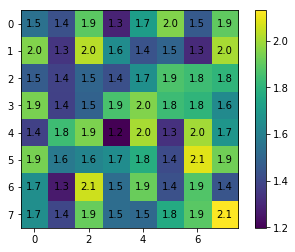

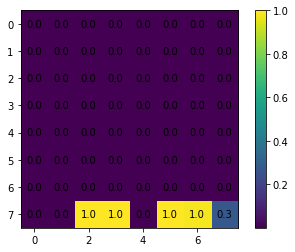

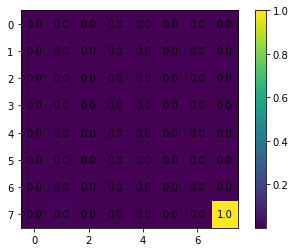

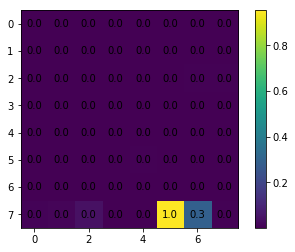

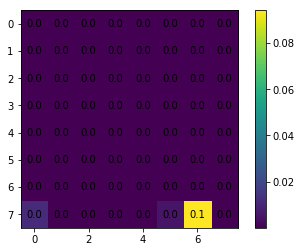

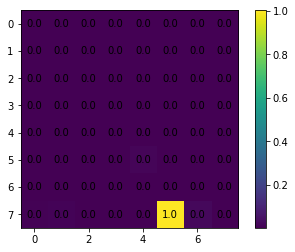

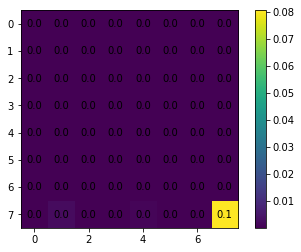

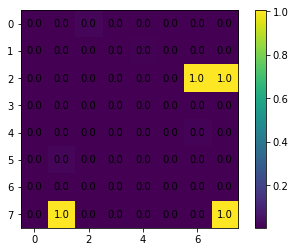

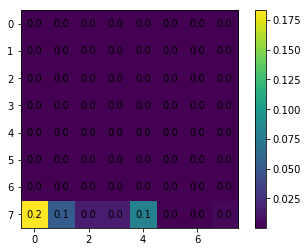

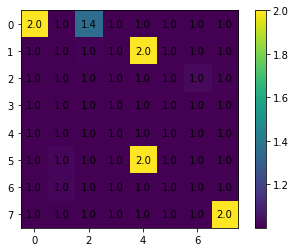

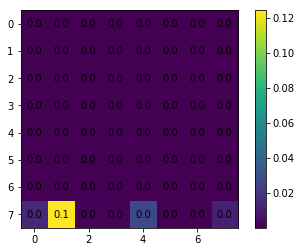

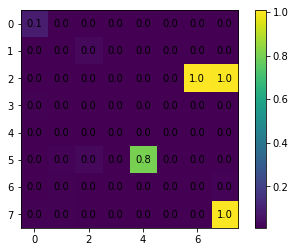

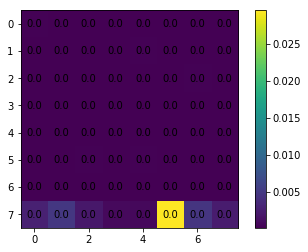

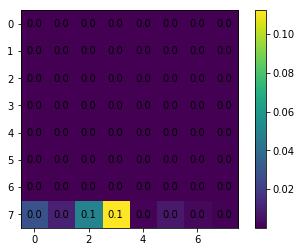

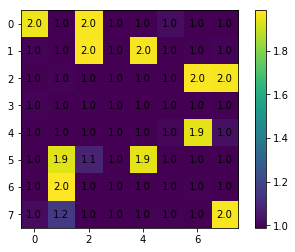

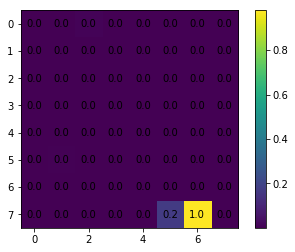

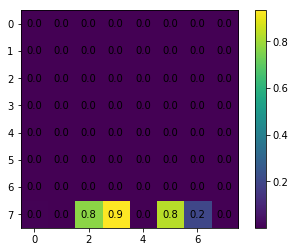

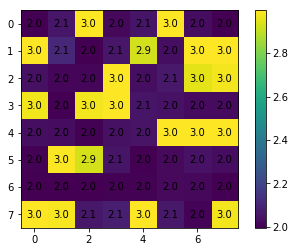

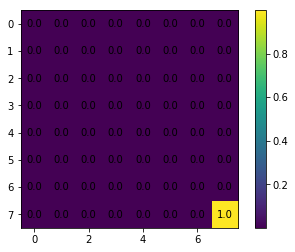

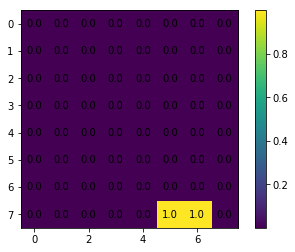

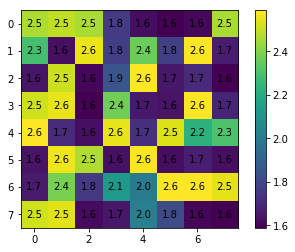

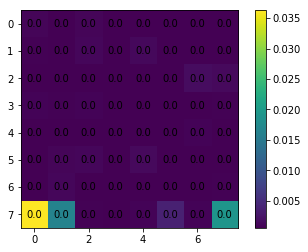

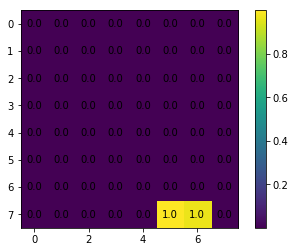

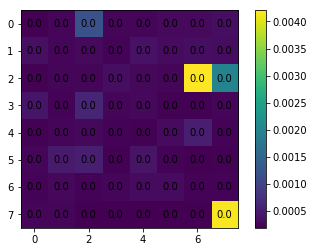

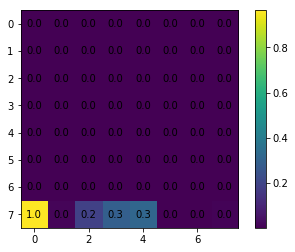

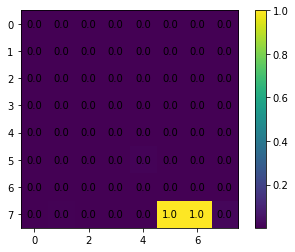

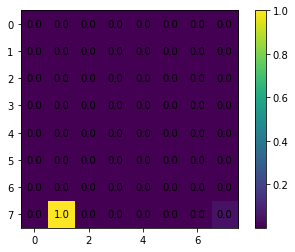

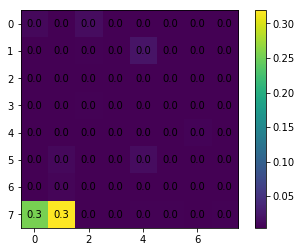

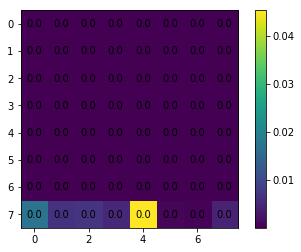

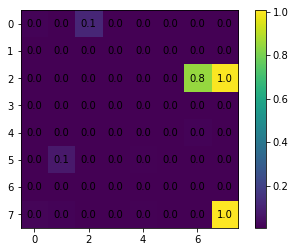

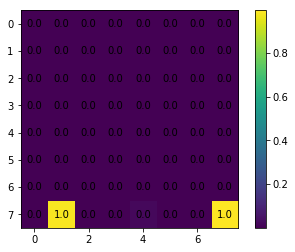

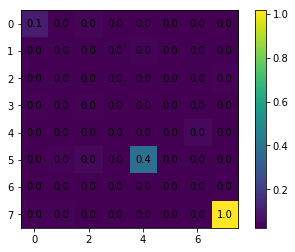

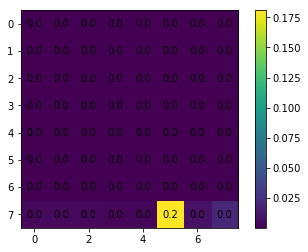

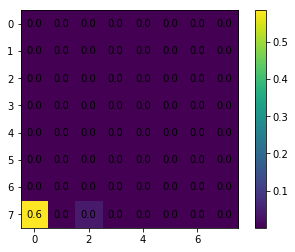

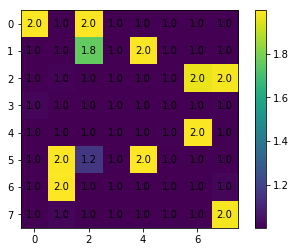

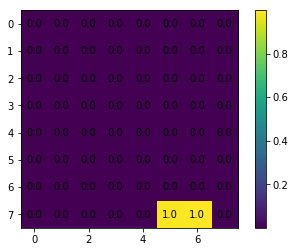

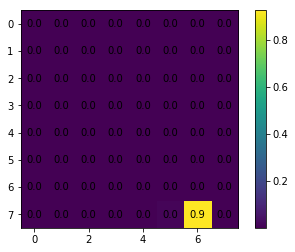

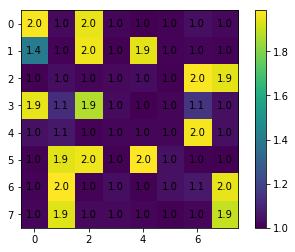

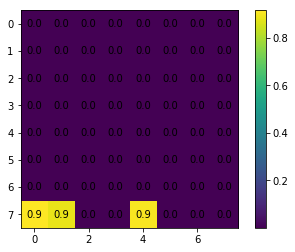

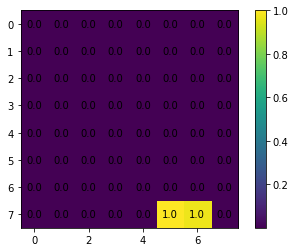

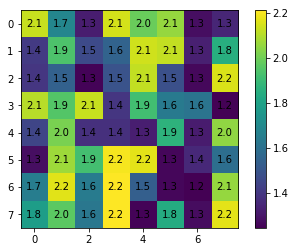

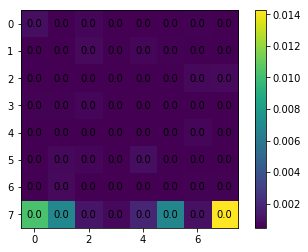

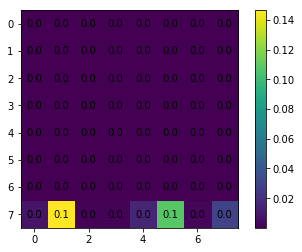

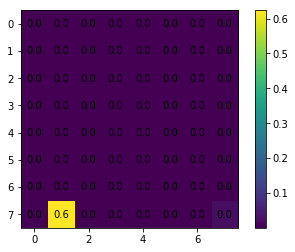

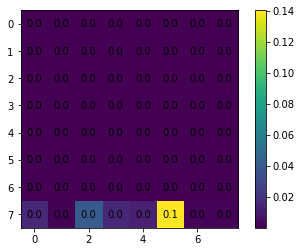

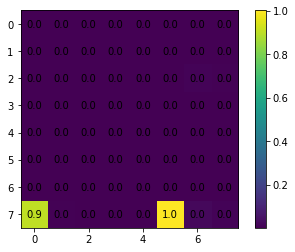

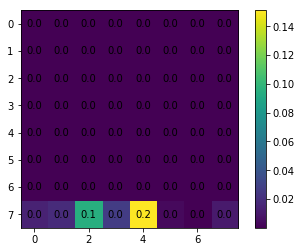

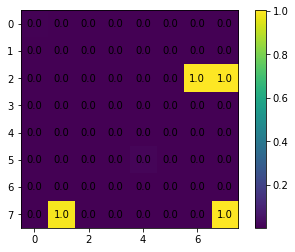

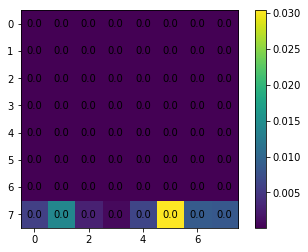

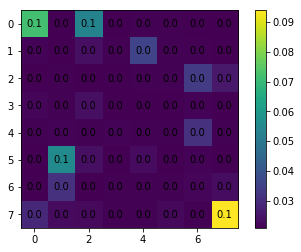

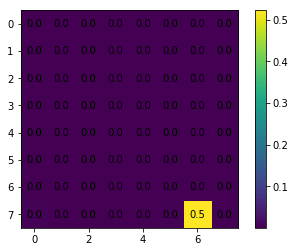

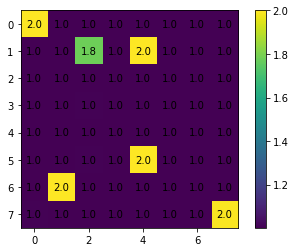

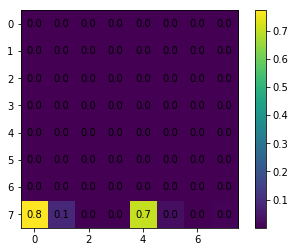

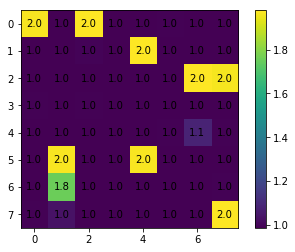

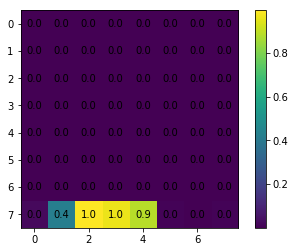

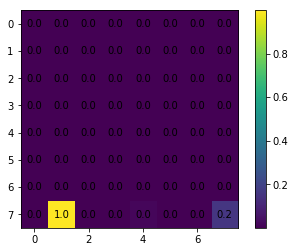

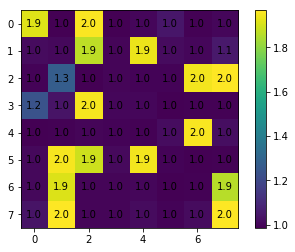

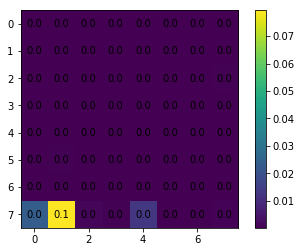

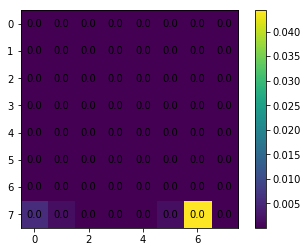

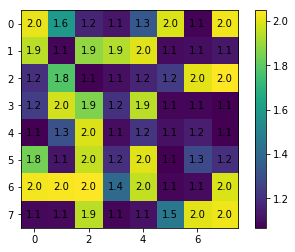

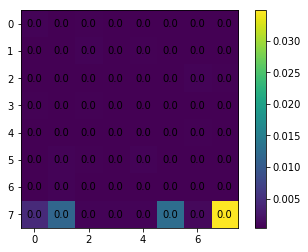

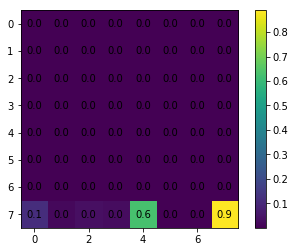

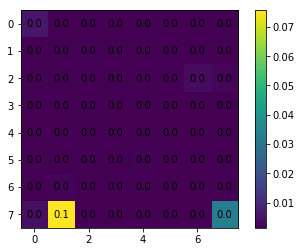

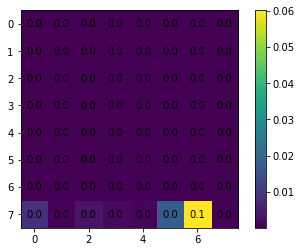

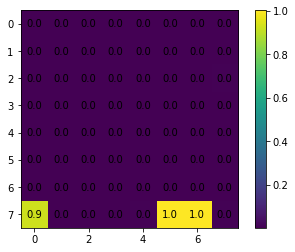

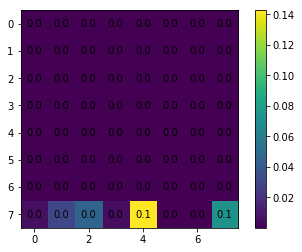

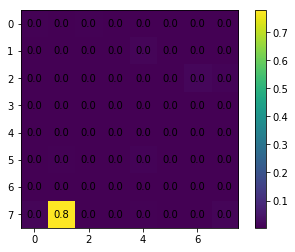

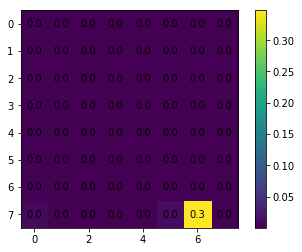

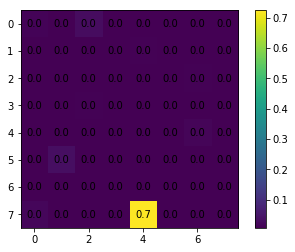

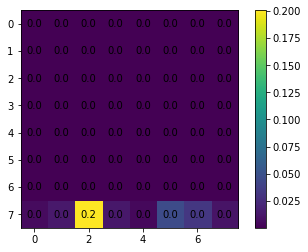

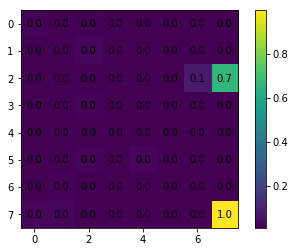

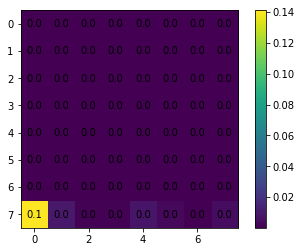

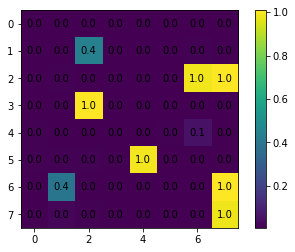

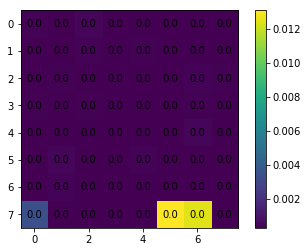

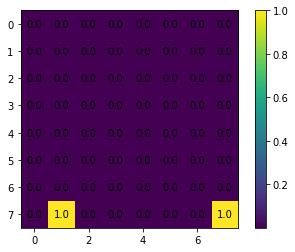

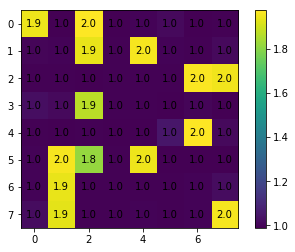

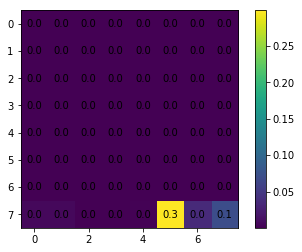

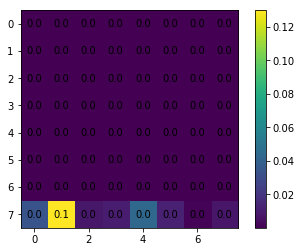

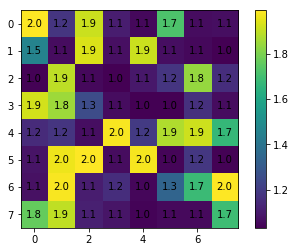

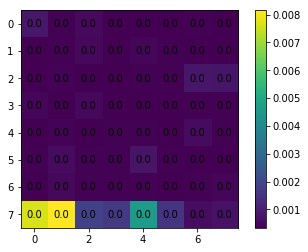

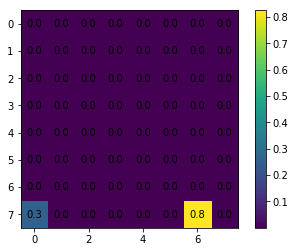

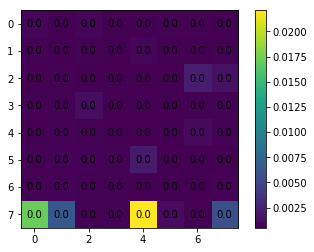

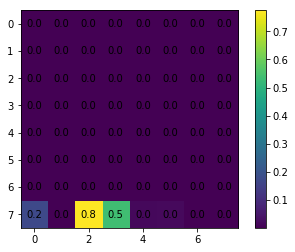

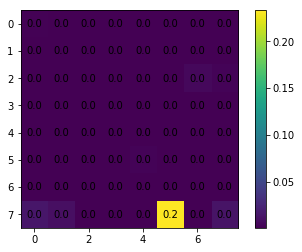

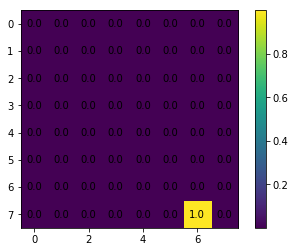

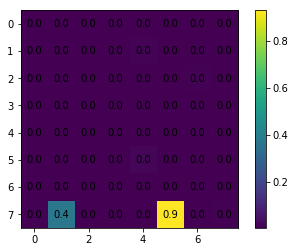

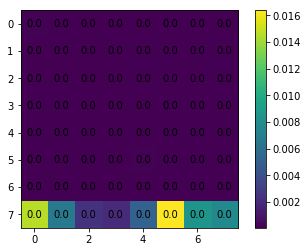

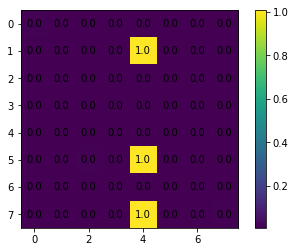

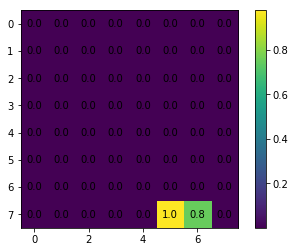

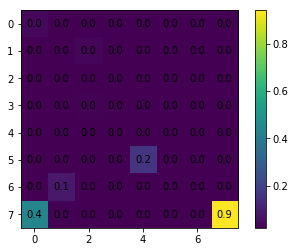

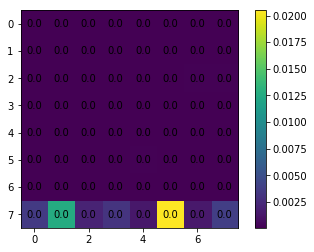

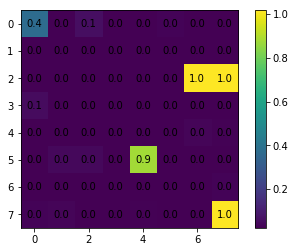

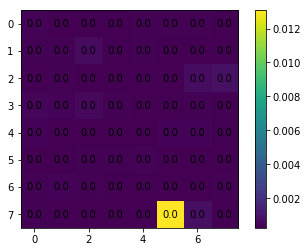

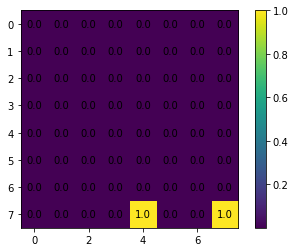

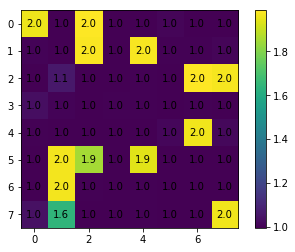

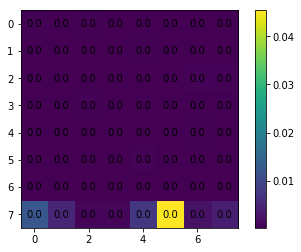

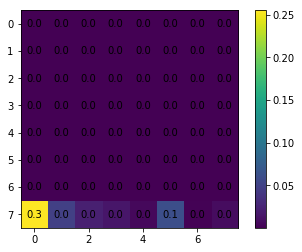

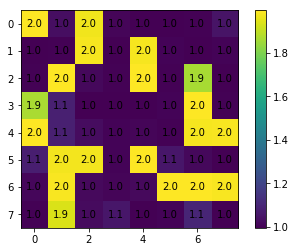

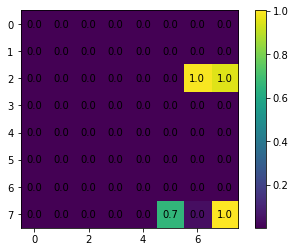

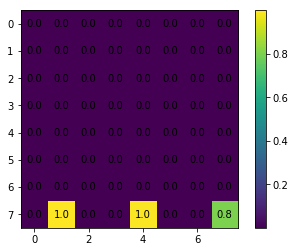

In [113]:
# Simple architecture
Dtest = gan.train(epochs=10000, batch_size=30, sample_interval=100)

# A TEST

In [12]:
b = Dtest['6000']['rewards']
#b

array([[3.35474306e-04],
       [3.59052177e-04],
       [1.86254143e-04],
       [1.94798688e-04],
       [1.92455840e-04],
       [2.67721374e-04],
       [2.02812938e-04],
       [2.03863776e-04],
       [1.78331802e-04],
       [1.81560004e-04],
       [1.93651891e-04],
       [2.50434405e-04],
       [1.87379132e-04],
       [1.80027377e-04],
       [2.01049421e-04],
       [3.11171123e-04],
       [2.24473264e-04],
       [2.08795962e-04],
       [2.10783288e-04],
       [1.92742060e-04],
       [2.02290121e-04],
       [2.12995601e-04],
       [2.23242401e-04],
       [2.19891674e-04],
       [2.27866836e-04],
       [1.84947870e-04],
       [1.86459954e-04],
       [2.04557291e-04],
       [2.00712377e-04],
       [2.29846348e-04],
       [1.87189553e-04],
       [2.02417490e-04],
       [2.09373298e-04],
       [2.09224549e-04],
       [2.02429659e-04],
       [2.06045672e-04],
       [1.97699461e-04],
       [2.27705466e-04],
       [1.93200120e-04],
       [1.90277600e-04],


In [4]:
import gym
from gym.envs.registration import register, spec

MY_ENV_NAME='FrozenLakeNonskid8x8-v1'
register(
        id=MY_ENV_NAME,
        entry_point='myfrozen.frozen_test:FrozenLakeEnv',
        kwargs={'map_name': '8x8', 'is_slippery': False},
        timestep_limit=100,
        reward_threshold=0.78, # optimum = .8196
)

env = gym.make(MY_ENV_NAME)

In [5]:
env.render()


SFFFFFFF
FFHFFFFF
FFFFFHFF
FFHFFFFF
FFHFFFFF
FFFFHFFF
FFFFHFFF
FFFFFFFG


In [42]:
def to_onehot(size,value):
  my_onehot = np.zeros((size))
  my_onehot[value] = 1.0
  return my_onehot

OBSERVATION_SPACE = env.observation_space.n
ACTION_SPACE = env.action_space.n

# Assume gridworld is always square
OBS_SQR = int(math.sqrt(OBSERVATION_SPACE))
STATEGRID = np.zeros((OBS_SQR,OBS_SQR))

def compute_reward(s,new_s,a):
    zerostates = {12, 21, 29, 37, 44, 52, 61}
    s = to_onehot(OBSERVATION_SPACE,s)
    new_s = to_onehot(OBSERVATION_SPACE,new_s)
    a = to_onehot(ACTION_SPACE,a)
    vectorized = np.hstack((s,new_s,a))
    index = list(zerostates)
    vectorized = np.delete(vectorized, index)
    return np.dot(gen_imgs,vectorized)
    
def run_episode(env,Q,learning_rate,gamma,episode):
    observation = env.reset()
    done = False
    t_reward = 0
    max_steps = 60
    #max_steps = env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')
    move_counter = 0
    for j in range(max_steps):
        if done:
            break

        curr_state = observation

        #action = np.argmax(Q[curr_state,:]  + np.random.randn(1, env.action_space.n)*(1./(episode+1)))
        action = np.argmax(Q[curr_state,:]  + np.random.randn(1, env.action_space.n))
        #action = np.argmax(Q[curr_state,:])
        
        move_counter+=1
        
        observation, true_reward, done, info = env.step(action)
        
        reward = compute_reward(curr_state,observation,action)
        
        #collect.append((curr_state,action,observation,reward))

        t_reward += reward

        #Q(state, action) = R(state, action) + Gamma * Max[Q(next state, all actions)]
        Q[curr_state,action] += learning_rate * (reward+ gamma*np.max(Q[observation,:])-Q[curr_state,action])

    return Q, t_reward, done, move_counter, true_reward

In [43]:
def trainer(epochs=1000,learning_rate = 0.81,discount = 0.96):
    #env = gym.make('FrozenLake-v0')
    #env = wrappers.Monitor(env, '/tmp/FrozenLake-experiment-6',force=True)

    reward_per_ep = list()
    wins = 0
    losses = 0
    
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    
    for i in range(epochs):
        #print i
        Q, t_reward, done, move_counter, true_reward = run_episode(env,Q,learning_rate,discount,i)
        #print done
        reward_per_ep.append(t_reward)

        if done:
            if true_reward > 0 : # Win
                wins += 1
            else: # Loss
                losses += 1
        time.sleep(.1)        
        clear_output(wait=True)
        print("Game #: %s" % (i+1,))
        print("Moves this round %s" % move_counter)
        print("Final Position:")
        env.render()
        print("Wins/Losses %s/%s" % (wins, losses))
    return Q, reward_per_ep

In [17]:
coeff = Dtest['6000']['coeff']

In [44]:
%%time
#coeff = Dtest['8700']['coeff']
q, rpe = trainer(epochs=2000,discount = 0.5)

Game #: 2000
Moves this round 6
Final Position:
  (Right)
SFFFFFFF
FFHFFFFF
FFFFFHFF
FFHFFFFF
FFHFFFFF
FFFFHFFF
FFFFHFFF
FFFFFGFF
Wins/Losses 32/1928
CPU times: user 19 s, sys: 4.09 s, total: 23.1 s
Wall time: 3min 44s



SFFFFFFF
FFHFFFFF
FFFFFHFF
FFHFFFFF
FFHFFFFF
FFFFHFFF
FFFFHFFF
FFFFFGFF


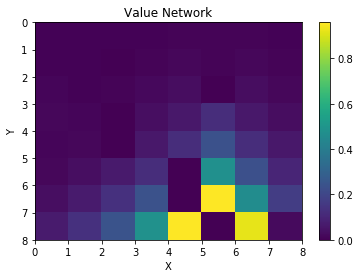

In [45]:
# Plot out the values the critic gives for the agent being in
# a specific state, i.e. in a specific location in the env.
def plot_value(initial_state):
    # Assume gridworld is always a square
    obs_sqr = math.sqrt(OBSERVATION_SPACE)
    np_w_cri_r = np.zeros((OBS_SQR,OBS_SQR))
    # make a working copy.
    working_state = initial_state.copy()
    for x in range(0,OBS_SQR):
        for y in range(0,OBS_SQR):
            my_state = working_state.copy()
            # Place the player at a given X/Y location.
            my_state[x,y] = 1
            obs_predict = my_state.reshape(1,OBSERVATION_SPACE,)
            obs_predict = np.squeeze(obs_predict)
            index, = np.where(obs_predict == 1.)
            value = np.max(q[index,:])
            #value = 0
            np_w_cri_r[x,y] = value
    np_w_cri_r.shape
    pylab.pcolor(np_w_cri_r)
    pylab.title("Value Network")
    pylab.colorbar()
    pylab.xlabel("X")
    pylab.ylabel("Y")
    pylab.gca().invert_yaxis()
    pylab.draw()

env.reset()
env.render()
plot_value(STATEGRID)

In [33]:
A2A=['<','v','>','^']
def show_policy(initial_state):
    grid = np.zeros((OBS_SQR,OBS_SQR), dtype='<U2')
    for x in range(0,OBS_SQR):
        for y in range(0,OBS_SQR):
            my_state = initial_state.copy()
            my_state[x,y] = 1

            obs_predict = my_state.reshape(1,OBSERVATION_SPACE,)
            obs_predict = np.squeeze(obs_predict)
            index, = np.where(obs_predict == 1.)
            action = np.argmax(q[index,:])
            grid[x,y] = A2A[action]
    grid
    return grid

env.reset()
env.render()

grid = show_policy(STATEGRID)
print(grid)


SFFFFFFF
FFHFFFFF
FFFFFHFF
FFHFFFFF
FFHFFFFF
FFFFHFFF
FFFFHFFF
FFFGFFFF
[[u'>' u'v' u'<' u'v' u'v' u'<' u'<' u'<']
 [u'v' u'v' u'<' u'v' u'<' u'<' u'<' u'<']
 [u'v' u'v' u'<' u'v' u'<' u'<' u'^' u'^']
 [u'v' u'v' u'<' u'v' u'v' u'v' u'<' u'v']
 [u'v' u'v' u'<' u'v' u'<' u'<' u'<' u'<']
 [u'v' u'v' u'v' u'v' u'<' u'^' u'<' u'v']
 [u'v' u'v' u'v' u'v' u'<' u'<' u'<' u'v']
 [u'>' u'v' u'<' u'<' u'<' u'<' u'<' u'<']]


## Second example

In [16]:
coeff = Dtest['3600']['coeff']

In [49]:
%%time
#coeff = Dtest['8700']['coeff']
q, rpe = trainer(epochs=2000)

Game #: 2000
Moves this round 30
Final Position:
  (Down)
SFFFFFFF
FFHFFFFF
FFFFFHFF
FFHFFFFF
FFHFFFFF
FFFFHFFF
FFFFHFFF
FFFFFGFF
Wins/Losses 41/1715
CPU times: user 21 s, sys: 3.81 s, total: 24.8 s
Wall time: 3min 48s



SFFFFFFF
FFHFFFFF
FFFFFHFF
FFHFFFFF
FFHFFFFF
FFFFHFFF
FFFFHFFF
FFFFFGFF


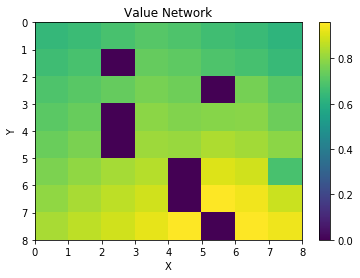

In [50]:
# Plot out the values the critic gives for the agent being in
# a specific state, i.e. in a specific location in the env.
def plot_value(initial_state):
    # Assume gridworld is always a square
    obs_sqr = math.sqrt(OBSERVATION_SPACE)
    np_w_cri_r = np.zeros((OBS_SQR,OBS_SQR))
    # make a working copy.
    working_state = initial_state.copy()
    for x in range(0,OBS_SQR):
        for y in range(0,OBS_SQR):
            my_state = working_state.copy()
            # Place the player at a given X/Y location.
            my_state[x,y] = 1
            obs_predict = my_state.reshape(1,OBSERVATION_SPACE,)
            obs_predict = np.squeeze(obs_predict)
            index, = np.where(obs_predict == 1.)
            value = np.max(q[index,:])
            #value = 0
            np_w_cri_r[x,y] = value
    np_w_cri_r.shape
    pylab.pcolor(np_w_cri_r)
    pylab.title("Value Network")
    pylab.colorbar()
    pylab.xlabel("X")
    pylab.ylabel("Y")
    pylab.gca().invert_yaxis()
    pylab.draw()

env.reset()
env.render()
plot_value(STATEGRID)

In [51]:
A2A=['<','v','>','^']
def show_policy(initial_state):
    grid = np.zeros((OBS_SQR,OBS_SQR), dtype='<U2')
    for x in range(0,OBS_SQR):
        for y in range(0,OBS_SQR):
            my_state = initial_state.copy()
            my_state[x,y] = 1

            obs_predict = my_state.reshape(1,OBSERVATION_SPACE,)
            obs_predict = np.squeeze(obs_predict)
            index, = np.where(obs_predict == 1.)
            action = np.argmax(q[index,:])
            grid[x,y] = A2A[action]
    grid
    return grid

env.reset()
env.render()

grid = show_policy(STATEGRID)
print(grid)


SFFFFFFF
FFHFFFFF
FFFFFHFF
FFHFFFFF
FFHFFFFF
FFFFHFFF
FFFFHFFF
FFFFFGFF
[[u'v' u'v' u'>' u'v' u'v' u'<' u'v' u'<']
 [u'v' u'v' u'<' u'v' u'v' u'<' u'v' u'<']
 [u'v' u'v' u'>' u'v' u'v' u'<' u'v' u'<']
 [u'v' u'v' u'<' u'v' u'v' u'v' u'v' u'<']
 [u'>' u'v' u'<' u'v' u'>' u'v' u'v' u'<']
 [u'v' u'v' u'v' u'v' u'<' u'v' u'v' u'<']
 [u'>' u'v' u'v' u'v' u'<' u'v' u'v' u'v']
 [u'>' u'>' u'>' u'>' u'>' u'<' u'<' u'<']]
